In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
from PIL import Image
import pandas as pd
from tqdm import tqdm
import os
import warnings
from collections import Counter
import copy
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns



class Fitzpatrick17kDataset(Dataset):
    """
    Custom Dataset for Fitzpatrick17k with pre-downloaded images
    """
    def __init__(self, csv_file, image_dir, transform=None, task='malignant',
                 augment_minority=False, minority_group=None):

        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.task = task
        self.augment_minority = augment_minority
        self.minority_group = minority_group

        print(f"Loaded {len(self.df)} samples from {csv_file}")

        # Remove samples with invalid Fitzpatrick scale (-1)
        before_filter = len(self.df)
        self.df = self.df[self.df['fitzpatrick_scale'] != -1].reset_index(drop=True)
        after_filter = len(self.df)
        if before_filter != after_filter:
            print(f"Filtered out {before_filter - after_filter} samples with fitzpatrick_scale = -1")

        # Binary classification: malignant (1) vs non-malignant (0)
        label_mapping = {
            'malignant': 1,
            'benign': 0,
            'non-neoplastic': 0
        }
        self.df['binary_label'] = self.df['three_partition_label'].map(label_mapping)


        # Binary sensitive attribute:
        # Lighter skin (Fitzpatrick 1-4) = 0, Darker skin (Fitzpatrick 5-6) = 1 (marginalized)
        self.df['sensitive_binary'] = (self.df['fitzpatrick_scale'] >= 5).astype(int)

        print(f"Final dataset size: {len(self.df)} samples")
        print(f"  - Malignant: {(self.df['binary_label'] == 1).sum()}")
        print(f"  - Non-malignant: {(self.df['binary_label'] == 0).sum()}")
        print(f"  - Lighter skin (1-4): {(self.df['sensitive_binary'] == 0).sum()}")
        print(f"  - Darker skin (5-6): {(self.df['sensitive_binary'] == 1).sum()}")

        # Extra augmentation transform for minority group
        if augment_minority:
            self.extra_augment = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.7),
                transforms.RandomVerticalFlip(p=0.3),
                transforms.RandomRotation(30),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Get image filename
        img_filename = row['image_filename']


        img_path = os.path.join(self.image_dir, img_filename)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')

        # Apply augmentation
        sensitive = int(row['sensitive_binary'])
        if self.augment_minority and sensitive == self.minority_group and self.transform:
            image = self.extra_augment(image)
        elif self.transform:
            image = self.transform(image)

        label = int(row['binary_label'])

        return image, label, sensitive


class WeightedFitzpatrick17kDataset(Fitzpatrick17kDataset):
    """Dataset that returns sample weights for reweighting"""
    def __init__(self, *args, sample_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.sample_weights = sample_weights

    def __getitem__(self, idx):
        image, label, sensitive = super().__getitem__(idx)
        weight = self.sample_weights[idx] if self.sample_weights is not None else 1.0
        return image, label, sensitive, weight

In [2]:
class FairnessAwareLoss(nn.Module):
    """
    Cross-entropy + fairness penalty (Demographic Parity on predicted probabilities)
    """
    def __init__(self, base_loss=None, lambda_fair=0.1):
        super().__init__()
        self.base_loss = base_loss if base_loss is not None else nn.CrossEntropyLoss()
        self.lambda_fair = lambda_fair

    def forward(self, outputs, labels, sensitive):
        ce_loss = self.base_loss(outputs, labels)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        s0 = (sensitive == 0)
        s1 = (sensitive == 1)

        if s0.any() and s1.any():
            pos_rate_0 = probs[s0].mean()
            pos_rate_1 = probs[s1].mean()
            dp_diff = torch.abs(pos_rate_0 - pos_rate_1)
        else:
            dp_diff = torch.tensor(0.0, device=outputs.device)

        loss = ce_loss + self.lambda_fair * dp_diff
        return loss


In [3]:
class AdversarialDebiasing(nn.Module):
    """
    Adversarial Debiasing for Demographic Parity
    """
    def __init__(self, classifier, num_classes=2, num_sensitive=2, hidden_dim=32):
        super().__init__()
        self.classifier = classifier
        self.num_classes = num_classes
        self.num_sensitive = num_sensitive

        self.adversary = nn.Sequential(
            nn.Linear(num_classes, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_sensitive)
        )

    def forward(self, x):
        return self.classifier(x)

    def forward_adversary(self, classifier_output):
        return self.adversary(classifier_output.detach())

In [4]:
def get_transforms(input_size=224):
    """Get data transforms"""
    # training transform
    train_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform


def get_model(model_name='resnet34', num_classes=2, pretrained=True):
    """Load CNN model"""
    if model_name == 'resnet34':
        model = models.resnet34(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=pretrained)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'mobilenetv2':
        model = models.mobilenet_v2(pretrained=pretrained)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError(f"Model {model_name} not supported")

    return model


def calculate_sample_weights(df, sensitive_col='sensitive_binary', label_col='binary_label'):
    """Calculate sample weights for reweighting scheme"""
    group_counts = df.groupby([sensitive_col, label_col]).size()
    total_samples = len(df)

    weights = []
    for idx, row in df.iterrows():
        sensitive = row[sensitive_col]
        label = row[label_col]
        group_size = group_counts.get((sensitive, label), 1)
        weight = total_samples / (len(group_counts) * group_size)
        weights.append(weight)

    weights = np.array(weights)
    weights = weights / weights.mean()

    return weights


def create_balanced_sampler(df, sensitive_col='sensitive_binary', label_col='binary_label'):
    """Create a weighted sampler for re-sampling"""
    group_labels = df[sensitive_col].astype(str) + '_' + df[label_col].astype(str)
    class_counts = Counter(group_labels)
    weights = [1.0 / class_counts[label] for label in group_labels]
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)
    return sampler

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device, use_sample_weights=False):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        if use_sample_weights:
            images, labels, _, weights = batch
            weights = weights.to(device)
        else:
            images, labels, _ = batch
            weights = None

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        if use_sample_weights and weights is not None:
            loss = criterion(outputs, labels)
            loss = (loss * weights).mean()
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


def train_epoch_with_fairness_loss(model, dataloader, fairness_criterion, optimizer, device):
    """Train for one epoch using FairnessAwareLoss"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training with Fairness Loss"):
        if len(batch) == 4:
            images, labels, sensitive, _ = batch
        else:
            images, labels, sensitive = batch

        images = images.to(device)
        labels = labels.to(device)
        sensitive = sensitive.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = fairness_criterion(outputs, labels, sensitive)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


def train_epoch_adversarial(model, dataloader, classifier_criterion, adversary_criterion,
                           classifier_optimizer, adversary_optimizer, device,
                           lambda_adv=1.0, adversary_steps=3):
    """Train for one epoch using adversarial debiasing"""
    model.train()
    running_total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training (Adversarial)"):
        if len(batch) == 4:
            images, labels, sensitive, _ = batch
        else:
            images, labels, sensitive = batch

        images = images.to(device)
        labels = labels.to(device)
        sensitive = sensitive.to(device)

        # Train Adversary
        for _ in range(adversary_steps):
            adversary_optimizer.zero_grad()
            classifier_outputs = model(images)
            adversary_outputs = model.forward_adversary(classifier_outputs)
            adv_loss = adversary_criterion(adversary_outputs, sensitive)
            adv_loss.backward()
            adversary_optimizer.step()

        # Train Classifier
        classifier_optimizer.zero_grad()
        classifier_outputs = model(images)
        clf_loss = classifier_criterion(classifier_outputs, labels)
        adversary_outputs = model.adversary(classifier_outputs)
        uniform_target = torch.ones_like(adversary_outputs) / model.num_sensitive
        adv_confusion_loss = nn.functional.kl_div(
            nn.functional.log_softmax(adversary_outputs, dim=1),
            uniform_target,
            reduction='batchmean'
        )
        total_loss = clf_loss - lambda_adv * adv_confusion_loss
        total_loss.backward()
        classifier_optimizer.step()

        running_total_loss += total_loss.item() * images.size(0)

        _, preds = torch.max(classifier_outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_total_loss = running_total_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_total_loss, epoch_acc

In [6]:
def evaluate(model, dataloader, criterion, device, return_probabilities=True):
    """Evaluate model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_sensitive = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            if len(batch) == 4:
                images, labels, sensitive, _ = batch
            else:
                images, labels, sensitive = batch

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            if loss.dim() > 0:
                loss = loss.mean()

            running_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_sensitive.extend(sensitive.cpu().numpy())
            if return_probabilities:
                all_probs.extend(probs[:, 1].cpu().numpy() if probs.shape[1] > 1 else probs[:, 0].cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_sensitive), np.array(all_probs)

In [7]:
def calibrate_thresholds(labels, probabilities, sensitive_attrs, target_metric='equalized_odds'):
    """Find optimal thresholds per group to achieve fairness"""
    sensitive_values = np.unique(sensitive_attrs)
    thresholds = {}

    if target_metric == 'equalized_odds':
        for s in sensitive_values:
            mask = sensitive_attrs == s
            fpr, tpr, thresh = roc_curve(labels[mask], probabilities[mask])
            idx = np.argmax(tpr - fpr)
            thresholds[s] = thresh[idx]

    elif target_metric == 'demographic_parity':
        target_positive_rate = np.mean(labels)

        for s in sensitive_values:
            mask = sensitive_attrs == s
            thresholds_to_try = np.linspace(0, 1, 100)
            best_threshold = 0.5
            best_diff = float('inf')

            for thresh in thresholds_to_try:
                preds = (probabilities[mask] >= thresh).astype(int)
                pos_rate = np.mean(preds)
                diff = abs(pos_rate - target_positive_rate)
                if diff < best_diff:
                    best_diff = diff
                    best_threshold = thresh

            thresholds[s] = best_threshold

    return thresholds


def apply_calibrated_thresholds(probabilities, sensitive_attrs, thresholds):
    """Apply group-specific thresholds to predictions"""
    predictions = np.zeros_like(probabilities, dtype=int)

    for s, thresh in thresholds.items():
        mask = sensitive_attrs == s
        predictions[mask] = (probabilities[mask] >= thresh).astype(int)

    return predictions

In [8]:
def calculate_demographic_parity(predictions, sensitive_attrs):
    """Calculate Demographic Parity Difference"""
    sensitive_values = np.unique(sensitive_attrs)
    positive_rates = {}

    for s in sensitive_values:
        mask = sensitive_attrs == s
        positive_rate = np.mean(predictions[mask] == 1)
        positive_rates[s] = positive_rate

    dp_diff = abs(positive_rates[sensitive_values[0]] - positive_rates[sensitive_values[1]])

    return dp_diff


def calculate_equalized_odds(predictions, labels, sensitive_attrs):
    """Calculate Equalized Odds Difference"""
    sensitive_values = np.unique(sensitive_attrs)
    tpr_by_group = {}
    fpr_by_group = {}

    for s in sensitive_values:
        mask = sensitive_attrs == s

        y_true_pos = labels[mask] == 1
        if np.sum(y_true_pos) > 0:
            tpr = np.mean(predictions[mask][y_true_pos] == 1)
        else:
            tpr = 0.0
        tpr_by_group[s] = tpr

        y_true_neg = labels[mask] == 0
        if np.sum(y_true_neg) > 0:
            fpr = np.mean(predictions[mask][y_true_neg] == 1)
        else:
            fpr = 0.0
        fpr_by_group[s] = fpr

    tpr_diff = abs(tpr_by_group[sensitive_values[0]] - tpr_by_group[sensitive_values[1]])
    fpr_diff = abs(fpr_by_group[sensitive_values[0]] - fpr_by_group[sensitive_values[1]])
    eo_diff = max(tpr_diff, fpr_diff)

    return eo_diff


def bootstrap_metric(predictions, labels, sensitive_attrs, metric_func, n_iterations=1000, confidence_level=0.95, random_state=42):
    """Perform bootstrap resampling to estimate confidence intervals"""
    np.random.seed(random_state)
    n_samples = len(predictions)
    bootstrap_metrics = []

    for _ in range(n_iterations):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_preds = predictions[indices]
        boot_labels = labels[indices]
        boot_sensitive = sensitive_attrs[indices]
        metric_value = metric_func(boot_preds, boot_labels, boot_sensitive)
        bootstrap_metrics.append(metric_value)

    bootstrap_metrics = np.array(bootstrap_metrics)
    alpha = 1 - confidence_level
    ci_lower = np.percentile(bootstrap_metrics, 100 * alpha / 2)
    ci_upper = np.percentile(bootstrap_metrics, 100 * (1 - alpha / 2))

    return {
        'mean': np.mean(bootstrap_metrics),
        'std': np.std(bootstrap_metrics),
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'samples': bootstrap_metrics
    }


def statistical_comparison(baseline_preds, baseline_labels, baseline_sensitive,
                          treatment_preds, treatment_labels, treatment_sensitive,
                          method_name, n_bootstrap=1000):
    """Perform statistical comparison between baseline and treatment - DP and EO only"""
    print(f"\n{'='*60}")
    print(f"Statistical Comparison: BASELINE vs {method_name}")
    print(f"{'='*60}")

    def dp_metric(preds, labels, sensitive):
        return calculate_demographic_parity(preds, sensitive)

    def eo_metric(preds, labels, sensitive):
        return calculate_equalized_odds(preds, labels, sensitive)

    # Bootstrap for Demographic Parity
    print("\n1. Demographic Parity Gap:")
    baseline_dp_boot = bootstrap_metric(baseline_preds, baseline_labels, baseline_sensitive,
                                       dp_metric, n_iterations=n_bootstrap)
    treatment_dp_boot = bootstrap_metric(treatment_preds, treatment_labels, treatment_sensitive,
                                        dp_metric, n_iterations=n_bootstrap)

    print(f"   Baseline:  {baseline_dp_boot['mean']:.4f} (95% CI: [{baseline_dp_boot['ci_lower']:.4f}, {baseline_dp_boot['ci_upper']:.4f}])")
    print(f"   {method_name}: {treatment_dp_boot['mean']:.4f} (95% CI: [{treatment_dp_boot['ci_lower']:.4f}, {treatment_dp_boot['ci_upper']:.4f}])")

    dp_improvement = baseline_dp_boot['mean'] - treatment_dp_boot['mean']
    print(f"   Improvement: {dp_improvement:.4f}")

    t_stat, p_value_dp = ttest_ind(baseline_dp_boot['samples'], treatment_dp_boot['samples'])
    print(f"   t-test p-value: {p_value_dp:.4f} {'***' if p_value_dp < 0.001 else '**' if p_value_dp < 0.01 else '*' if p_value_dp < 0.05 else 'ns'}")

    # Bootstrap for Equalized Odds
    print("\n2. Equalized Odds Gap:")
    baseline_eo_boot = bootstrap_metric(baseline_preds, baseline_labels, baseline_sensitive,
                                       eo_metric, n_iterations=n_bootstrap)
    treatment_eo_boot = bootstrap_metric(treatment_preds, treatment_labels, treatment_sensitive,
                                        eo_metric, n_iterations=n_bootstrap)

    print(f"   Baseline:  {baseline_eo_boot['mean']:.4f} (95% CI: [{baseline_eo_boot['ci_lower']:.4f}, {baseline_eo_boot['ci_upper']:.4f}])")
    print(f"   {method_name}: {treatment_eo_boot['mean']:.4f} (95% CI: [{treatment_eo_boot['ci_lower']:.4f}, {treatment_eo_boot['ci_upper']:.4f}])")

    eo_improvement = baseline_eo_boot['mean'] - treatment_eo_boot['mean']
    print(f"   Improvement: {eo_improvement:.4f}")

    t_stat, p_value_eo = ttest_ind(baseline_eo_boot['samples'], treatment_eo_boot['samples'])
    print(f"   t-test p-value: {p_value_eo:.4f} {'***' if p_value_eo < 0.001 else '**' if p_value_eo < 0.01 else '*' if p_value_eo < 0.05 else 'ns'}")

    print("\n   Significance: *** p<0.001, ** p<0.01, * p<0.05, ns p>=0.05")

    return {
        'method': method_name,
        'dp_improvement': dp_improvement,
        'dp_p_value': p_value_dp,
        'dp_significant': p_value_dp < 0.05,
        'eo_improvement': eo_improvement,
        'eo_p_value': p_value_eo,
        'eo_significant': p_value_eo < 0.05,
        'baseline_dp_ci': f"[{baseline_dp_boot['ci_lower']:.4f}, {baseline_dp_boot['ci_upper']:.4f}]",
        'treatment_dp_ci': f"[{treatment_dp_boot['ci_lower']:.4f}, {treatment_dp_boot['ci_upper']:.4f}]",
        'baseline_eo_ci': f"[{baseline_eo_boot['ci_lower']:.4f}, {baseline_eo_boot['ci_upper']:.4f}]",
        'treatment_eo_ci': f"[{treatment_eo_boot['ci_lower']:.4f}, {treatment_eo_boot['ci_upper']:.4f}]"
    }


def print_fairness_metrics(name, predictions, labels, sensitive_attrs, probabilities=None):
    """Print fairness metrics - streamlined version"""
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")

    acc = accuracy_score(labels, predictions)
    print(f"Accuracy: {acc:.4f}")

    f1 = f1_score(labels, predictions, average='binary', zero_division=0)
    print(f"F1 Score: {f1:.4f}")

    if probabilities is not None:
        try:
            auc = roc_auc_score(labels, probabilities)
            print(f"AUC-ROC: {auc:.4f}")
        except:
            pass

    dp_gap = calculate_demographic_parity(predictions, sensitive_attrs)
    print(f"DP Gap: {dp_gap:.4f}")

    eo_gap = calculate_equalized_odds(predictions, labels, sensitive_attrs)
    print(f"EO Gap: {eo_gap:.4f}")

    return {
        'accuracy': acc,
        'f1': f1,
        'dp_gap': dp_gap,
        'eo_gap': eo_gap
    }


In [9]:
def train_and_evaluate(model_name, train_loader, val_loader, test_loader,
                      method_name, num_classes=2, num_epochs=20, lr=0.0001,
                      device='cuda', use_sample_weights=False):
    """Train and evaluate a model"""
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()} - {method_name}")
    print(f"{'='*80}")

    model = get_model(model_name, num_classes=num_classes, pretrained=True)
    model = model.to(device)

    if use_sample_weights:
        train_criterion = nn.CrossEntropyLoss(reduction='none')
    else:
        train_criterion = nn.CrossEntropyLoss()

    eval_criterion = nn.CrossEntropyLoss(reduction='mean')

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_val_acc = 0.0
    best_model_state = None
    patience = 0
    patience_limit = 10

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, train_criterion, optimizer, device, use_sample_weights)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        val_loss, val_acc, _, _, _, _ = evaluate(model, val_loader, eval_criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1

        if patience >= patience_limit:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_state)

    _, test_acc, test_preds, test_labels, test_sensitive, test_probs = evaluate(
        model, test_loader, eval_criterion, device
    )

    results = print_fairness_metrics(
        f"Test Results - {model_name.upper()} - {method_name}",
        test_preds, test_labels, test_sensitive, test_probs
    )

    results['model'] = model_name
    results['method'] = method_name

    return model, results, test_preds, test_labels, test_sensitive


def train_and_evaluate_with_fairness_loss(model_name, train_loader, val_loader, test_loader,
                                         method_name, num_classes=2, num_epochs=20, lr=0.0001,
                                         device='cuda', lambda_fair=0.1):
    """Train and evaluate using FairnessAwareLoss"""
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()} - {method_name} (lambda={lambda_fair})")
    print(f"{'='*80}")

    model = get_model(model_name, num_classes=num_classes, pretrained=True)
    model = model.to(device)

    fairness_criterion = FairnessAwareLoss(lambda_fair=lambda_fair)
    eval_criterion = nn.CrossEntropyLoss(reduction='mean')

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_val_acc = 0.0
    best_model_state = None
    patience = 0
    patience_limit = 5

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_epoch_with_fairness_loss(
            model, train_loader, fairness_criterion, optimizer, device
        )
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        val_loss, val_acc, _, _, _, _ = evaluate(model, val_loader, eval_criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1

        if patience >= patience_limit:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_state)

    _, test_acc, test_preds, test_labels, test_sensitive, test_probs = evaluate(
        model, test_loader, eval_criterion, device
    )

    results = print_fairness_metrics(
        f"Test Results - {model_name.upper()} - {method_name}",
        test_preds, test_labels, test_sensitive, test_probs
    )

    results['model'] = model_name
    results['method'] = method_name
    results['lambda_fair'] = lambda_fair

    return model, results, test_preds, test_labels, test_sensitive


def train_and_evaluate_adversarial(model_name, train_loader, val_loader, test_loader,
                                   method_name, num_classes=2, num_epochs=20, lr=0.0001,
                                   device='cuda', lambda_adv=1.0, adversary_steps=3):
    """Train and evaluate using adversarial debiasing"""
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()} - {method_name} (lambda_adv={lambda_adv})")
    print(f"{'='*80}")

    base_classifier = get_model(model_name, num_classes=num_classes, pretrained=True)
    model = AdversarialDebiasing(base_classifier, num_classes=num_classes, num_sensitive=2)
    model = model.to(device)

    classifier_criterion = nn.CrossEntropyLoss()
    adversary_criterion = nn.CrossEntropyLoss()
    eval_criterion = nn.CrossEntropyLoss(reduction='mean')

    classifier_params = model.classifier.parameters()
    adversary_params = model.adversary.parameters()

    classifier_optimizer = optim.Adam(classifier_params, lr=lr)
    adversary_optimizer = optim.Adam(adversary_params, lr=lr * 2)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(classifier_optimizer, mode='min', patience=3, factor=0.5)

    best_val_acc = 0.0
    best_model_state = None
    patience = 0
    patience_limit = 5

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_epoch_adversarial(
            model, train_loader, classifier_criterion, adversary_criterion,
            classifier_optimizer, adversary_optimizer, device, lambda_adv, adversary_steps
        )
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        val_loss, val_acc, _, _, _, _ = evaluate(model, val_loader, eval_criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1

        if patience >= patience_limit:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_state)

    _, test_acc, test_preds, test_labels, test_sensitive, test_probs = evaluate(
        model, test_loader, eval_criterion, device
    )

    results = print_fairness_metrics(
        f"Test Results - {model_name.upper()} - {method_name}",
        test_preds, test_labels, test_sensitive, test_probs
    )

    results['model'] = model_name
    results['method'] = method_name
    results['lambda_adv'] = lambda_adv

    return model, results, test_preds, test_labels, test_sensitive

In [10]:
def split_data(csv_file, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """Split data into train/val/test"""
    from sklearn.model_selection import train_test_split

    df = pd.read_csv(csv_file)

    print(f"Original dataset: {len(df)} samples")

    before_filter = len(df)
    df = df[df['fitzpatrick_scale'] != -1].reset_index(drop=True)
    after_filter = len(df)
    if before_filter != after_filter:
        print(f"Filtered out {before_filter - after_filter} samples with fitzpatrick_scale = -1")

    label_mapping = {'malignant': 1, 'benign': 0, 'non-neoplastic': 0}
    df['binary_label'] = df['three_partition_label'].map(label_mapping)


    train_df, temp_df = train_test_split(df, test_size=(1-train_ratio), stratify=df['binary_label'], random_state=random_state)
    val_ratio_adj = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(temp_df, test_size=(1-val_ratio_adj), stratify=temp_df['binary_label'], random_state=random_state)

    train_df.to_csv('train_split.csv', index=False)
    val_df.to_csv('val_split.csv', index=False)
    test_df.to_csv('test_split.csv', index=False)

    print(f"\nDataset split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

    return 'train_split.csv', 'val_split.csv', 'test_split.csv'

In [ ]:
def main():
    # CONFIGURATION
    IMAGE_DIR = '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick'
    METADATA_CSV = '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/image_metadata.csv'

    BATCH_SIZE = 32
    NUM_EPOCHS = 30
    LEARNING_RATE = 0.0001
    NUM_CLASSES = 2
    MODELS = ['resnet34', 'densenet121', 'mobilenetv2']
    LAMBDA_FAIR = 0.1
    LAMBDA_ADV = 0.8
    ADV_STEPS = 5
    N_BOOTSTRAP = 1000

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Split data
    train_csv, val_csv, test_csv = split_data(METADATA_CSV)
    train_transform, val_transform = get_transforms()

    # Determine minority group
    df = pd.read_csv(train_csv)
    df = df[df['fitzpatrick_scale'] != -1].reset_index(drop=True)
    df['sensitive_binary'] = (df['fitzpatrick_scale'] >= 5).astype(int)

    group_counts = df['sensitive_binary'].value_counts()
    minority_group = group_counts.idxmin()

    print(f"\nSkin type grouping:")
    print(f"  Lighter skin (1-4) - Group 0: {(df['sensitive_binary'] == 0).sum()} samples")
    print(f"  Darker skin (5-6) - Group 1: {(df['sensitive_binary'] == 1).sum()} samples")
    print(f"Minority group (for augmentation): {minority_group}")

    all_results = []
    all_predictions = {}
    statistical_results = []

    for model_name in MODELS:
        print(f"\n{'#'*80}")
        print(f"MODEL: {model_name.upper()}")
        print(f"{'#'*80}")

        # BASELINE
        print("\n>>> BASELINE (No Fairness Intervention)")
        train_dataset = Fitzpatrick17kDataset(train_csv, IMAGE_DIR, transform=train_transform)
        val_dataset = Fitzpatrick17kDataset(val_csv, IMAGE_DIR, transform=val_transform)
        test_dataset = Fitzpatrick17kDataset(test_csv, IMAGE_DIR, transform=val_transform)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

        model_baseline, results_baseline, preds_baseline, labels_baseline, sensitive_baseline = train_and_evaluate(
            model_name, train_loader, val_loader, test_loader, "BASELINE",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device
        )
        all_results.append(results_baseline)

        baseline_key = f"{model_name}_BASELINE"
        all_predictions[baseline_key] = {
            'preds': preds_baseline,
            'labels': labels_baseline,
            'sensitive': sensitive_baseline
        }

        # DATA AUGMENTATION
        print("\n>>> DATA AUGMENTATION")
        train_dataset_aug = Fitzpatrick17kDataset(train_csv, IMAGE_DIR, transform=train_transform,
                                      augment_minority=True, minority_group=minority_group)
        train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

        model_aug, results_aug, preds_aug, labels_aug, sensitive_aug = train_and_evaluate(
            model_name, train_loader_aug, val_loader, test_loader, "DATA_AUGMENTATION",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device
        )
        all_results.append(results_aug)

        all_predictions[f"{model_name}_DATA_AUGMENTATION"] = {
            'preds': preds_aug,
            'labels': labels_aug,
            'sensitive': sensitive_aug
        }

        # RE-SAMPLING
        print("\n>>> RE-SAMPLING")
        sampler = create_balanced_sampler(df)
        train_loader_resample = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4)

        model_resample, results_resample, preds_resample, labels_resample, sensitive_resample = train_and_evaluate(
            model_name, train_loader_resample, val_loader, test_loader, "RE_SAMPLING",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device
        )
        all_results.append(results_resample)

        all_predictions[f"{model_name}_RE_SAMPLING"] = {
            'preds': preds_resample,
            'labels': labels_resample,
            'sensitive': sensitive_resample
        }

        # REWEIGHTING
        print("\n>>> REWEIGHTING")
        sample_weights = calculate_sample_weights(df)
        train_dataset_weighted = WeightedFitzpatrick17kDataset(train_csv, IMAGE_DIR, transform=train_transform,
                                                    sample_weights=sample_weights)
        train_loader_weighted = DataLoader(train_dataset_weighted, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

        model_weighted, results_weighted, preds_weighted, labels_weighted, sensitive_weighted = train_and_evaluate(
            model_name, train_loader_weighted, val_loader, test_loader, "REWEIGHTING",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device, use_sample_weights=True
        )
        all_results.append(results_weighted)

        all_predictions[f"{model_name}_REWEIGHTING"] = {
            'preds': preds_weighted,
            'labels': labels_weighted,
            'sensitive': sensitive_weighted
        }

        # FAIRNESS-AWARE LOSS
        print("\n>>> FAIRNESS-AWARE LOSS")
        model_fairloss, results_fairloss, preds_fairloss, labels_fairloss, sensitive_fairloss = train_and_evaluate_with_fairness_loss(
            model_name, train_loader, val_loader, test_loader, "FAIRNESS_AWARE_LOSS",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device, lambda_fair=LAMBDA_FAIR
        )
        all_results.append(results_fairloss)

        all_predictions[f"{model_name}_FAIRNESS_AWARE_LOSS"] = {
            'preds': preds_fairloss,
            'labels': labels_fairloss,
            'sensitive': sensitive_fairloss
        }

        # ADVERSARIAL DEBIASING
        print("\n>>> ADVERSARIAL DEBIASING")
        model_adv, results_adv, preds_adv, labels_adv, sensitive_adv = train_and_evaluate_adversarial(
            model_name, train_loader, val_loader, test_loader, "ADVERSARIAL_DEBIASING",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device,
            lambda_adv=LAMBDA_ADV, adversary_steps=ADV_STEPS
        )
        all_results.append(results_adv)

        all_predictions[f"{model_name}_ADVERSARIAL_DEBIASING"] = {
            'preds': preds_adv,
            'labels': labels_adv,
            'sensitive': sensitive_adv
        }

        # THRESHOLD CALIBRATION
        print("\n>>> THRESHOLD CALIBRATION")
        # Need probabilities for threshold calibration - re-run evaluation to get them
        _, _, _, _, _, probs_baseline = evaluate(model_baseline, test_loader, nn.CrossEntropyLoss(reduction='mean'), device)

        thresholds = calibrate_thresholds(labels_baseline, probs_baseline, sensitive_baseline,
                                         target_metric='equalized_odds')
        print(f"Calibrated thresholds: {thresholds}")

        preds_calibrated = apply_calibrated_thresholds(probs_baseline, sensitive_baseline, thresholds)

        results_calibrated = print_fairness_metrics(
            f"Test Results - {model_name.upper()} - THRESHOLD_CALIBRATION",
            preds_calibrated, labels_baseline, sensitive_baseline, probs_baseline
        )
        results_calibrated['model'] = model_name
        results_calibrated['method'] = 'THRESHOLD_CALIBRATION'
        all_results.append(results_calibrated)

        all_predictions[f"{model_name}_THRESHOLD_CALIBRATION"] = {
            'preds': preds_calibrated,
            'labels': labels_baseline,
            'sensitive': sensitive_baseline
        }

    # STATISTICAL TESTING
    print("\n\n" + "="*100)
    print("STATISTICAL TESTING - Bootstrap Comparison with Baseline")
    print("="*100)

    for model_name in MODELS:
        print(f"\n{'*'*80}")
        print(f"MODEL: {model_name.upper()}")
        print(f"{'*'*80}")

        baseline_key = f"{model_name}_BASELINE"
        baseline_data = all_predictions[baseline_key]

        methods = ['DATA_AUGMENTATION', 'RE_SAMPLING', 'REWEIGHTING',
                  'FAIRNESS_AWARE_LOSS', 'ADVERSARIAL_DEBIASING', 'THRESHOLD_CALIBRATION']

        for method in methods:
            treatment_key = f"{model_name}_{method}"
            treatment_data = all_predictions[treatment_key]

            stat_result = statistical_comparison(
                baseline_data['preds'], baseline_data['labels'], baseline_data['sensitive'],
                treatment_data['preds'], treatment_data['labels'], treatment_data['sensitive'],
                method, n_bootstrap=N_BOOTSTRAP
            )
            stat_result['model'] = model_name
            statistical_results.append(stat_result)

    # FINAL COMPARISON
    print("\n\n" + "="*100)
    print("FINAL COMPARISON - ALL METHODS")
    print("="*100)

    results_df = pd.DataFrame(all_results)
    results_df = results_df[['model', 'method', 'accuracy', 'f1', 'dp_gap', 'eo_gap']]
    results_df = results_df.round(4)

    print("\n", results_df.to_string(index=False))

    results_df.to_csv('/content/drive/MyDrive/ELEC 509/Final Project/fitz_fairness_comparison_results.csv', index=False)
    print("\n" + "="*100)
    print("Results saved to 'fairness_comparison_results.csv'")
    print("="*100)

    # STATISTICAL TESTING SUMMARY
    print("\n\n" + "="*100)
    print("STATISTICAL TESTING SUMMARY")
    print("="*100)

    stat_df = pd.DataFrame(statistical_results)
    stat_df = stat_df[['model', 'method', 'dp_improvement', 'dp_p_value', 'dp_significant',
                       'eo_improvement', 'eo_p_value', 'eo_significant']]
    stat_df = stat_df.round(4)

    print("\n", stat_df.to_string(index=False))

    stat_df.to_csv('/content/drive/MyDrive/ELEC 509/Final Project/fitz_statistical_comparison_results.csv', index=False)
    print("\n" + "="*100)
    print("Statistical results saved to 'statistical_comparison_results.csv'")
    print("="*100)


if __name__ == "__main__":
    main()

Using device: cuda
Original dataset: 16536 samples
Filtered out 562 samples with fitzpatrick_scale = -1

Dataset split: Train=11181, Val=2396, Test=2397

Skin type grouping:
  Lighter skin (1-4) - Group 0: 9635 samples
  Darker skin (5-6) - Group 1: 1546 samples
Minority group (for augmentation): 1

################################################################################
MODEL: RESNET34
################################################################################

>>> BASELINE (No Fairness Intervention)
Loaded 11181 samples from train_split.csv
Final dataset size: 11181 samples
  - Malignant: 1510
  - Non-malignant: 9671
  - Lighter skin (1-4): 9635
  - Darker skin (5-6): 1546
Loaded 2396 samples from val_split.csv
Final dataset size: 2396 samples
  - Malignant: 324
  - Non-malignant: 2072
  - Lighter skin (1-4): 2087
  - Darker skin (5-6): 309
Loaded 2397 samples from test_split.csv
Final dataset size: 2397 samples
  - Malignant: 324
  - Non-malignant: 2073
  - Lighter skin

100%|██████████| 83.3M/83.3M [00:00<00:00, 230MB/s]



Epoch 1/30


Training:   5%|▍         | 16/350 [01:45<23:48,  4.28s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  10%|█         | 36/350 [03:55<27:11,  5.20s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  11%|█▏        | 40/350 [04:21<27:30,  5.32s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  14%|█▎        | 48/350 [05:13<27:03,  5.38s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  26%|██▌       | 91/350 [09:46<26:59,  6.25s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  32%|███▏      | 112/350 [12:05<22:46,  5.74s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  35%|███▌      | 124/350 [13:39<19:44,  5.24s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  67%|██████▋   | 236/350 [25:39<09:57,  5.24s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  69%|██████▊   | 240/350 [25:51<09:33,  5.21s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  77%|███████▋  | 268/350 [28:53<07:24,  5.42s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  93%|█████████▎| 325/350 [34:59<01:43,  4.15s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [37:46<00:00,  6.48s/it]


Train Loss: 0.2862, Train Acc: 0.8890


Evaluating:  12%|█▏        | 9/75 [01:24<09:17,  8.45s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [01:48<07:37,  7.38s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  53%|█████▎    | 40/75 [04:33<03:25,  5.87s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [08:15<00:00,  6.60s/it]


Val Loss: 0.2559, Val Acc: 0.9040

Epoch 2/30


Training:  12%|█▏        | 41/350 [00:04<00:24, 12.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  15%|█▌        | 53/350 [00:04<00:24, 12.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:22, 12.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  21%|██        | 73/350 [00:06<00:24, 11.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  26%|██▌       | 91/350 [00:08<00:22, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:15, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  56%|█████▌    | 195/350 [00:17<00:12, 12.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  69%|██████▉   | 243/350 [00:21<00:10, 10.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  87%|████████▋ | 305/350 [00:27<00:03, 12.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  90%|█████████ | 315/350 [00:27<00:02, 12.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  99%|█████████▊| 345/350 [00:30<00:00, 10.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.30it/s]


Train Loss: 0.1722, Train Acc: 0.9359


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.30it/s]


Val Loss: 0.2519, Val Acc: 0.9128

Epoch 3/30


Training:   7%|▋         | 23/350 [00:02<00:29, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  19%|█▊        | 65/350 [00:05<00:23, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  28%|██▊       | 99/350 [00:09<00:22, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  44%|████▎     | 153/350 [00:13<00:16, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  45%|████▌     | 159/350 [00:14<00:16, 11.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  69%|██████▉   | 243/350 [00:21<00:10, 10.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  70%|███████   | 245/350 [00:21<00:09, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  77%|███████▋  | 271/350 [00:24<00:06, 12.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  88%|████████▊ | 309/350 [00:27<00:03, 10.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  90%|█████████ | 315/350 [00:27<00:02, 12.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.38it/s]


Train Loss: 0.0978, Train Acc: 0.9622


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.18it/s]


Val Loss: 0.2794, Val Acc: 0.9082

Epoch 4/30


Training:   3%|▎         | 9/350 [00:01<00:32, 10.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   5%|▍         | 17/350 [00:01<00:27, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  16%|█▋        | 57/350 [00:05<00:26, 11.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:24, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  20%|██        | 71/350 [00:06<00:24, 11.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  56%|█████▌    | 195/350 [00:17<00:14, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  62%|██████▏   | 217/350 [00:19<00:12, 10.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  64%|██████▍   | 225/350 [00:20<00:10, 12.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  91%|█████████ | 317/350 [00:27<00:02, 12.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  93%|█████████▎| 325/350 [00:28<00:02, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.38it/s]


Train Loss: 0.0643, Train Acc: 0.9756


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 10.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.28it/s]


Val Loss: 0.3472, Val Acc: 0.9124

Epoch 5/30


Training:  10%|█         | 35/350 [00:03<00:35,  8.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:21, 12.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  33%|███▎      | 115/350 [00:10<00:20, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:14, 12.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  50%|█████     | 175/350 [00:15<00:15, 11.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  75%|███████▍  | 261/350 [00:23<00:07, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  82%|████████▏ | 287/350 [00:25<00:05, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  83%|████████▎ | 289/350 [00:25<00:05, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  96%|█████████▌| 335/350 [00:29<00:01, 12.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  97%|█████████▋| 341/350 [00:29<00:00, 12.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  99%|█████████▊| 345/350 [00:30<00:00, 11.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.40it/s]


Train Loss: 0.0557, Train Acc: 0.9807


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.18it/s]


Val Loss: 0.3825, Val Acc: 0.8973

Epoch 6/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:   5%|▍         | 17/350 [00:01<00:29, 11.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  15%|█▍        | 51/350 [00:04<00:24, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  16%|█▋        | 57/350 [00:05<00:24, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  33%|███▎      | 115/350 [00:10<00:20, 11.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  40%|███▉      | 139/350 [00:12<00:17, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  45%|████▌     | 159/350 [00:14<00:16, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  49%|████▉     | 171/350 [00:15<00:14, 12.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  58%|█████▊    | 203/350 [00:17<00:11, 12.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  65%|██████▌   | 229/350 [00:20<00:09, 12.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  87%|████████▋ | 303/350 [00:26<00:04, 10.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.52it/s]


Train Loss: 0.0512, Train Acc: 0.9814


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.16it/s]


Val Loss: 0.4833, Val Acc: 0.9069

Epoch 7/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   0%|          | 1/350 [00:00<03:13,  1.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   7%|▋         | 25/350 [00:02<00:29, 10.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  12%|█▏        | 43/350 [00:04<00:27, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  35%|███▌      | 123/350 [00:11<00:21, 10.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  42%|████▏     | 147/350 [00:13<00:16, 12.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  43%|████▎     | 151/350 [00:13<00:16, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:14, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  54%|█████▍    | 189/350 [00:17<00:12, 12.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  55%|█████▌    | 193/350 [00:17<00:13, 11.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  59%|█████▊    | 205/350 [00:18<00:12, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.26it/s]


Train Loss: 0.0167, Train Acc: 0.9951


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.18it/s]


Val Loss: 0.3501, Val Acc: 0.9186

Epoch 8/30


Training:   8%|▊         | 29/350 [00:02<00:25, 12.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  33%|███▎      | 115/350 [00:10<00:21, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  47%|████▋     | 165/350 [00:14<00:17, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  53%|█████▎    | 185/350 [00:16<00:13, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  56%|█████▋    | 197/350 [00:17<00:13, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  66%|██████▌   | 231/350 [00:20<00:10, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  69%|██████▉   | 241/350 [00:21<00:08, 12.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  73%|███████▎  | 257/350 [00:22<00:07, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  81%|████████▏ | 285/350 [00:25<00:06, 10.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  92%|█████████▏| 323/350 [00:28<00:02, 12.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.38it/s]


Train Loss: 0.0053, Train Acc: 0.9989


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:02, 12.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.12it/s]


Val Loss: 0.3836, Val Acc: 0.9211

Epoch 9/30


Training:   7%|▋         | 23/350 [00:02<00:27, 11.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  15%|█▌        | 53/350 [00:04<00:24, 12.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:26, 10.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  17%|█▋        | 61/350 [00:05<00:25, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  46%|████▌     | 161/350 [00:14<00:15, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  48%|████▊     | 167/350 [00:14<00:14, 12.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  73%|███████▎  | 255/350 [00:22<00:08, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  75%|███████▍  | 261/350 [00:23<00:07, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  87%|████████▋ | 305/350 [00:26<00:03, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  91%|█████████ | 317/350 [00:27<00:02, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  95%|█████████▌| 333/350 [00:29<00:01, 12.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.38it/s]


Train Loss: 0.0045, Train Acc: 0.9992


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.30it/s]


Val Loss: 0.3987, Val Acc: 0.9224

Epoch 10/30


Training:   0%|          | 1/350 [00:00<02:34,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:   1%|▏         | 5/350 [00:00<00:45,  7.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  41%|████▏     | 145/350 [00:12<00:17, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  44%|████▎     | 153/350 [00:13<00:17, 11.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  44%|████▍     | 155/350 [00:13<00:17, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  52%|█████▏    | 183/350 [00:16<00:13, 12.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  57%|█████▋    | 199/350 [00:17<00:12, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  64%|██████▎   | 223/350 [00:19<00:11, 11.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  72%|███████▏  | 253/350 [00:22<00:07, 12.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  88%|████████▊ | 307/350 [00:27<00:03, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  95%|█████████▍| 331/350 [00:29<00:01, 10.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.37it/s]


Train Loss: 0.0021, Train Acc: 0.9995


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.31it/s]


Val Loss: 0.4462, Val Acc: 0.9211

Epoch 11/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   7%|▋         | 23/350 [00:02<00:27, 11.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  11%|█         | 39/350 [00:03<00:24, 12.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  13%|█▎        | 47/350 [00:04<00:24, 12.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  17%|█▋        | 61/350 [00:05<00:27, 10.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  34%|███▍      | 119/350 [00:11<00:21, 10.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  47%|████▋     | 163/350 [00:14<00:16, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  61%|██████▏   | 215/350 [00:19<00:10, 12.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  76%|███████▋  | 267/350 [00:23<00:07, 11.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  80%|███████▉  | 279/350 [00:25<00:06, 11.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  84%|████████▎ | 293/350 [00:26<00:05, 11.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.30it/s]


Train Loss: 0.0017, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.27it/s]


Val Loss: 0.4636, Val Acc: 0.9220

Epoch 12/30


Training:  15%|█▌        | 54/350 [00:05<00:24, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  22%|██▏       | 78/350 [00:07<00:24, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  34%|███▍      | 120/350 [00:10<00:19, 11.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  57%|█████▋    | 200/350 [00:18<00:12, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  59%|█████▉    | 206/350 [00:18<00:12, 11.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  59%|█████▉    | 208/350 [00:18<00:12, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  63%|██████▎   | 222/350 [00:19<00:10, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  84%|████████▍ | 294/350 [00:26<00:04, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  89%|████████▊ | 310/350 [00:27<00:03, 12.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  89%|████████▉ | 312/350 [00:27<00:03, 12.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  95%|█████████▍| 332/350 [00:29<00:01, 12.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.28it/s]


Train Loss: 0.0012, Train Acc: 0.9997


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.38it/s]


Val Loss: 0.4138, Val Acc: 0.9249

Epoch 13/30


Training:   2%|▏         | 7/350 [00:01<00:43,  7.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:   4%|▍         | 15/350 [00:01<00:30, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:   5%|▌         | 19/350 [00:02<00:28, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  13%|█▎        | 47/350 [00:04<00:25, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  38%|███▊      | 133/350 [00:11<00:18, 11.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  47%|████▋     | 163/350 [00:14<00:17, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'

Training:  47%|████▋     | 165/350 [00:14<00:16, 10.94it/s]

Training:  49%|████▉     | 173/350 [00:15<00:17,  9.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  81%|████████▏ | 285/350 [00:25<00:05, 11.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  92%|█████████▏| 323/350 [00:28<00:02, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  97%|█████████▋| 341/350 [00:30<00:00, 12.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.34it/s]


Train Loss: 0.0012, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.49it/s]


Val Loss: 0.4200, Val Acc: 0.9245

Epoch 14/30


Training:  17%|█▋        | 58/350 [00:05<00:24, 11.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  18%|█▊        | 64/350 [00:06<00:25, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  25%|██▍       | 86/350 [00:08<00:22, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  26%|██▋       | 92/350 [00:08<00:21, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  39%|███▉      | 138/350 [00:12<00:18, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  44%|████▍     | 154/350 [00:13<00:17, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  63%|██████▎   | 220/350 [00:19<00:12, 10.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  71%|███████▏  | 250/350 [00:22<00:08, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  74%|███████▍  | 260/350 [00:23<00:07, 12.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  95%|█████████▌| 334/350 [00:29<00:01, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  97%|█████████▋| 340/350 [00:30<00:00, 11.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.25it/s]


Train Loss: 0.0009, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  48%|████▊     | 36/75 [00:03<00:03, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.53it/s]


Val Loss: 0.4442, Val Acc: 0.9240

Epoch 15/30


Training:   4%|▍         | 15/350 [00:01<00:39,  8.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:   6%|▌         | 21/350 [00:02<00:29, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  26%|██▌       | 91/350 [00:08<00:20, 12.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  29%|██▉       | 103/350 [00:09<00:23, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  31%|███       | 107/350 [00:09<00:20, 11.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  35%|███▍      | 121/350 [00:10<00:19, 12.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  35%|███▌      | 123/350 [00:11<00:19, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  41%|████      | 143/350 [00:12<00:17, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  63%|██████▎   | 221/350 [00:19<00:10, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  73%|███████▎  | 257/350 [00:22<00:08, 11.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  79%|███████▉  | 277/350 [00:24<00:06, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.34it/s]


Train Loss: 0.0014, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'

Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.84it/s]


Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:02, 12.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.41it/s]


Val Loss: 0.4675, Val Acc: 0.9245

Epoch 16/30


Training:   2%|▏         | 7/350 [00:01<00:40,  8.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  12%|█▏        | 43/350 [00:04<00:25, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  14%|█▍        | 49/350 [00:04<00:23, 12.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  20%|█▉        | 69/350 [00:06<00:22, 12.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  36%|███▌      | 125/350 [00:11<00:20, 11.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  49%|████▉     | 171/350 [00:15<00:15, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  59%|█████▊    | 205/350 [00:18<00:11, 12.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  59%|█████▉    | 207/350 [00:18<00:13, 10.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  77%|███████▋  | 269/350 [00:24<00:06, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  83%|████████▎ | 289/350 [00:25<00:05, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  89%|████████▉ | 313/350 [00:28<00:03, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.20it/s]


Train Loss: 0.0005, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.47it/s]


Val Loss: 0.4833, Val Acc: 0.9228

Epoch 17/30


Training:   3%|▎         | 9/350 [00:01<00:33, 10.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'

Training:   3%|▎         | 11/350 [00:01<00:31, 10.92it/s]

Training:   7%|▋         | 23/350 [00:02<00:27, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  13%|█▎        | 45/350 [00:04<00:28, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  28%|██▊       | 99/350 [00:08<00:20, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  55%|█████▌    | 193/350 [00:17<00:13, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  60%|█████▉    | 209/350 [00:18<00:11, 12.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  71%|███████   | 247/350 [00:22<00:10, 10.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  75%|███████▌  | 263/350 [00:23<00:06, 12.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  80%|███████▉  | 279/350 [00:24<00:05, 12.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  85%|████████▌ | 299/350 [00:26<00:04, 11.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  94%|█████████▍| 329/350 [00:29<00:01, 11.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.33it/s]


Train Loss: 0.0005, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:02, 13.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.49it/s]


Val Loss: 0.4729, Val Acc: 0.9215

Epoch 18/30


Training:  28%|██▊       | 97/350 [00:08<00:21, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  40%|████      | 141/350 [00:12<00:17, 11.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  45%|████▍     | 157/350 [00:14<00:15, 12.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  60%|██████    | 211/350 [00:18<00:11, 12.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  61%|██████    | 213/350 [00:18<00:10, 12.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  63%|██████▎   | 221/350 [00:19<00:10, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  75%|███████▍  | 261/350 [00:23<00:07, 12.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  79%|███████▊  | 275/350 [00:24<00:06, 12.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  82%|████████▏ | 287/350 [00:25<00:05, 11.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  83%|████████▎ | 291/350 [00:25<00:05, 10.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  92%|█████████▏| 323/350 [00:28<00:02, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.29it/s]


Train Loss: 0.0003, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.52it/s]


Val Loss: 0.4810, Val Acc: 0.9245

Epoch 19/30


Training:   3%|▎         | 9/350 [00:01<00:35,  9.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   7%|▋         | 25/350 [00:02<00:27, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  21%|██        | 73/350 [00:06<00:23, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  35%|███▌      | 123/350 [00:11<00:18, 12.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  39%|███▊      | 135/350 [00:12<00:18, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  45%|████▍     | 157/350 [00:14<00:15, 12.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  71%|███████   | 249/350 [00:22<00:09, 10.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  75%|███████▍  | 261/350 [00:23<00:07, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  80%|███████▉  | 279/350 [00:24<00:05, 12.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  88%|████████▊ | 309/350 [00:27<00:03, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  94%|█████████▍| 329/350 [00:29<00:01, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.27it/s]


Train Loss: 0.0003, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.51it/s]


Val Loss: 0.4996, Val Acc: 0.9245

Epoch 20/30


Training:   5%|▍         | 17/350 [00:01<00:27, 12.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:   7%|▋         | 25/350 [00:02<00:28, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  23%|██▎       | 79/350 [00:07<00:25, 10.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  27%|██▋       | 95/350 [00:08<00:22, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  28%|██▊       | 97/350 [00:09<00:21, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  42%|████▏     | 147/350 [00:13<00:17, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  45%|████▌     | 159/350 [00:14<00:17, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  57%|█████▋    | 201/350 [00:18<00:13, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  68%|██████▊   | 237/350 [00:21<00:09, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  80%|███████▉  | 279/350 [00:25<00:06, 10.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  96%|█████████▌| 335/350 [00:29<00:01, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.18it/s]


Train Loss: 0.0002, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'



Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.49it/s]


Val Loss: 0.4663, Val Acc: 0.9253

Epoch 21/30


Training:  13%|█▎        | 47/350 [00:04<00:28, 10.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  21%|██        | 73/350 [00:07<00:22, 12.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  25%|██▌       | 89/350 [00:08<00:21, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  39%|███▉      | 137/350 [00:12<00:17, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  40%|████      | 141/350 [00:12<00:19, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  51%|█████     | 177/350 [00:16<00:15, 10.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  56%|█████▋    | 197/350 [00:17<00:12, 12.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  61%|██████    | 213/350 [00:19<00:12, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  66%|██████▌   | 231/350 [00:20<00:10, 11.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  79%|███████▉  | 277/350 [00:24<00:06, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  81%|████████▏ | 285/350 [00:25<00:05, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.23it/s]


Train Loss: 0.0003, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.29it/s]


Val Loss: 0.5227, Val Acc: 0.9249

Epoch 22/30


Training:   7%|▋         | 23/350 [00:02<00:26, 12.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  16%|█▌        | 55/350 [00:05<00:26, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  20%|█▉        | 69/350 [00:06<00:26, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  27%|██▋       | 95/350 [00:08<00:22, 11.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  35%|███▌      | 123/350 [00:11<00:22, 10.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  42%|████▏     | 147/350 [00:13<00:16, 12.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  50%|█████     | 175/350 [00:15<00:13, 12.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  51%|█████     | 177/350 [00:15<00:13, 12.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  71%|███████   | 247/350 [00:21<00:09, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  74%|███████▍  | 259/350 [00:22<00:07, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.41it/s]


Train Loss: 0.0003, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.44it/s]


Val Loss: 0.5153, Val Acc: 0.9240

Epoch 23/30


Training:   1%|          | 2/350 [00:00<01:31,  3.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  17%|█▋        | 60/350 [00:05<00:26, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  22%|██▏       | 76/350 [00:07<00:24, 11.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  27%|██▋       | 94/350 [00:08<00:23, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  29%|██▊       | 100/350 [00:09<00:21, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  44%|████▍     | 154/350 [00:13<00:16, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  56%|█████▌    | 196/350 [00:17<00:13, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  58%|█████▊    | 202/350 [00:17<00:13, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  87%|████████▋ | 304/350 [00:26<00:04, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  87%|████████▋ | 306/350 [00:26<00:03, 11.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  88%|████████▊ | 308/350 [00:27<00:03, 12.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.41it/s]


Train Loss: 0.0003, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.24it/s]


Val Loss: 0.4708, Val Acc: 0.9228

Epoch 24/30


Training:   1%|▏         | 5/350 [00:00<00:53,  6.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:23, 12.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  21%|██▏       | 75/350 [00:07<00:26, 10.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  35%|███▌      | 123/350 [00:11<00:19, 11.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  48%|████▊     | 167/350 [00:15<00:15, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  53%|█████▎    | 185/350 [00:16<00:14, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  64%|██████▎   | 223/350 [00:19<00:11, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  65%|██████▌   | 229/350 [00:20<00:10, 11.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  84%|████████▍ | 295/350 [00:26<00:04, 11.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  87%|████████▋ | 305/350 [00:27<00:03, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  96%|█████████▌| 335/350 [00:29<00:01, 12.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.32it/s]


Train Loss: 0.0002, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.45it/s]


Val Loss: 0.5099, Val Acc: 0.9245

Epoch 25/30


Training:   3%|▎         | 9/350 [00:01<00:37,  9.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  16%|█▌        | 55/350 [00:05<00:25, 11.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  18%|█▊        | 63/350 [00:06<00:24, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  25%|██▍       | 87/350 [00:08<00:22, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  35%|███▍      | 121/350 [00:11<00:22, 10.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  36%|███▌      | 125/350 [00:11<00:23,  9.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  48%|████▊     | 167/350 [00:15<00:14, 12.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  61%|██████▏   | 215/350 [00:19<00:11, 12.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  73%|███████▎  | 257/350 [00:22<00:08, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  82%|████████▏ | 287/350 [00:25<00:05, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.35it/s]


Train Loss: 0.0001, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.26it/s]


Val Loss: 0.4967, Val Acc: 0.9228

Epoch 26/30


Training:   1%|          | 3/350 [00:00<01:09,  5.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   4%|▍         | 15/350 [00:01<00:31, 10.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:   6%|▌         | 21/350 [00:02<00:30, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  45%|████▍     | 157/350 [00:14<00:16, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  51%|█████     | 179/350 [00:15<00:14, 12.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  66%|██████▌   | 231/350 [00:20<00:11, 10.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  79%|███████▊  | 275/350 [00:24<00:06, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  85%|████████▍ | 297/350 [00:26<00:04, 11.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  87%|████████▋ | 303/350 [00:26<00:03, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  89%|████████▉ | 313/350 [00:27<00:02, 12.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  93%|█████████▎| 325/350 [00:28<00:02,  9.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.32it/s]


Train Loss: 0.0001, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.37it/s]


Val Loss: 0.4713, Val Acc: 0.9245

Epoch 27/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:   0%|          | 1/350 [00:00<02:50,  2.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  11%|█         | 37/350 [00:03<00:26, 11.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  20%|█▉        | 69/350 [00:06<00:26, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  34%|███▍      | 119/350 [00:10<00:19, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'

Training:  35%|███▍      | 121/350 [00:10<00:18, 12.12it/s]

Training:  43%|████▎     | 149/350 [00:13<00:16, 12.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  52%|█████▏    | 183/350 [00:16<00:15, 10.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  68%|██████▊   | 237/350 [00:21<00:09, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  79%|███████▊  | 275/350 [00:24<00:06, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  91%|█████████ | 317/350 [00:28<00:02, 11.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  95%|█████████▌| 333/350 [00:29<00:01, 11.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.25it/s]


Train Loss: 0.0001, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.11it/s]


Val Loss: 0.5117, Val Acc: 0.9228

Epoch 28/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  12%|█▏        | 41/350 [00:03<00:25, 11.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  18%|█▊        | 63/350 [00:05<00:25, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:22, 11.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  44%|████▍     | 155/350 [00:13<00:15, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  64%|██████▎   | 223/350 [00:19<00:11, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  81%|████████  | 284/350 [00:25<00:05, 11.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  85%|████████▌ | 298/350 [00:26<00:04, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  87%|████████▋ | 306/350 [00:27<00:03, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.23it/s]


Train Loss: 0.0001, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.07it/s]


Val Loss: 0.4848, Val Acc: 0.9245

Epoch 29/30


Training:  12%|█▏        | 43/350 [00:04<00:26, 11.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  15%|█▌        | 53/350 [00:05<00:26, 11.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  29%|██▉       | 101/350 [00:09<00:23, 10.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  41%|████▏     | 145/350 [00:13<00:17, 11.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  45%|████▍     | 157/350 [00:14<00:16, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  48%|████▊     | 167/350 [00:15<00:16, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  64%|██████▍   | 225/350 [00:20<00:10, 12.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  88%|████████▊ | 309/350 [00:27<00:03, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  91%|█████████ | 319/350 [00:28<00:02, 11.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  92%|█████████▏| 323/350 [00:28<00:02, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  97%|█████████▋| 339/350 [00:30<00:00, 12.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.26it/s]


Train Loss: 0.0002, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.16it/s]


Val Loss: 0.4945, Val Acc: 0.9245

Epoch 30/30


Training:   4%|▎         | 13/350 [00:01<00:32, 10.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  19%|█▊        | 65/350 [00:06<00:22, 12.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  31%|███       | 109/350 [00:10<00:21, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  36%|███▋      | 127/350 [00:11<00:17, 12.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'

Training:  37%|███▋      | 129/350 [00:11<00:18, 11.81it/s]

Training:  41%|████      | 143/350 [00:12<00:17, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  43%|████▎     | 151/350 [00:13<00:16, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  48%|████▊     | 167/350 [00:14<00:16, 11.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  51%|█████     | 179/350 [00:15<00:13, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  76%|███████▌  | 265/350 [00:23<00:07, 11.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  88%|████████▊ | 309/350 [00:27<00:03, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  92%|█████████▏| 323/350 [00:28<00:02, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.39it/s]


Train Loss: 0.0001, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.14it/s]


Val Loss: 0.4938, Val Acc: 0.9245
Early stopping at epoch 30


Evaluating:  33%|███▎      | 25/75 [03:10<05:33,  6.67s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  44%|████▍     | 33/75 [04:02<04:56,  7.05s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  49%|████▉     | 37/75 [04:27<04:19,  6.84s/it]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [09:11<00:00,  7.35s/it]



Test Results - RESNET34 - BASELINE
Accuracy: 0.9253
F1 Score: 0.6876
AUC-ROC: 0.9048
DP Gap: 0.0585
EO Gap: 0.0461

>>> DATA AUGMENTATION
Loaded 11181 samples from train_split.csv
Final dataset size: 11181 samples
  - Malignant: 1510
  - Non-malignant: 9671
  - Lighter skin (1-4): 9635
  - Darker skin (5-6): 1546

Training RESNET34 - DATA_AUGMENTATION

Epoch 1/30


Training:   4%|▎         | 13/350 [00:01<00:44,  7.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:   9%|▉         | 33/350 [00:03<00:27, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  35%|███▌      | 123/350 [00:11<00:21, 10.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  61%|██████    | 213/350 [00:20<00:13, 10.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  61%|██████▏   | 215/350 [00:20<00:12, 10.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  66%|██████▌   | 231/350 [00:22<00:11, 10.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  73%|███████▎  | 255/350 [00:24<00:08, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  79%|███████▊  | 275/350 [00:26<00:06, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  85%|████████▌ | 299/350 [00:28<00:04, 10.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  93%|█████████▎| 327/350 [00:31<00:02, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.56it/s]


Train Loss: 0.2944, Train Acc: 0.8865


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.26it/s]


Val Loss: 0.2528, Val Acc: 0.9053

Epoch 2/30


Training:   3%|▎         | 10/350 [00:01<00:42,  8.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  10%|█         | 36/350 [00:03<00:27, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  24%|██▍       | 84/350 [00:08<00:22, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  28%|██▊       | 98/350 [00:09<00:23, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  44%|████▍     | 154/350 [00:14<00:18, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  50%|████▉     | 174/350 [00:16<00:14, 12.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  60%|██████    | 210/350 [00:20<00:13, 10.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  67%|██████▋   | 234/350 [00:22<00:10, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  73%|███████▎  | 254/350 [00:24<00:07, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  74%|███████▎  | 258/350 [00:24<00:08, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.55it/s]


Train Loss: 0.1901, Train Acc: 0.9302


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.93it/s]


Val Loss: 0.2536, Val Acc: 0.9053

Epoch 3/30


Training:   2%|▏         | 7/350 [00:01<00:46,  7.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  15%|█▍        | 51/350 [00:05<00:25, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  20%|█▉        | 69/350 [00:07<00:24, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:22, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  32%|███▏      | 113/350 [00:11<00:24,  9.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  40%|████      | 141/350 [00:13<00:18, 11.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  54%|█████▍    | 189/350 [00:18<00:15, 10.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  61%|██████    | 213/350 [00:20<00:12, 11.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  79%|███████▊  | 275/350 [00:26<00:06, 11.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  84%|████████▎ | 293/350 [00:28<00:05, 10.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  90%|█████████ | 315/350 [00:30<00:03, 11.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.52it/s]


Train Loss: 0.1242, Train Acc: 0.9519


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.29it/s]


Val Loss: 0.2981, Val Acc: 0.8915

Epoch 4/30


Training:   3%|▎         | 9/350 [00:01<00:36,  9.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:   7%|▋         | 25/350 [00:02<00:32, 10.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   9%|▉         | 33/350 [00:03<00:31, 10.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:24, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  29%|██▉       | 103/350 [00:09<00:23, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  32%|███▏      | 111/350 [00:10<00:22, 10.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  35%|███▍      | 121/350 [00:11<00:20, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  47%|████▋     | 165/350 [00:15<00:15, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  49%|████▉     | 173/350 [00:16<00:15, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  52%|█████▏    | 183/350 [00:17<00:15, 10.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  91%|█████████ | 317/350 [00:29<00:02, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:32<00:00, 10.68it/s]


Train Loss: 0.0964, Train Acc: 0.9652


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.09it/s]


Val Loss: 0.2897, Val Acc: 0.9153

Epoch 5/30


Training:  11%|█         | 37/350 [00:03<00:29, 10.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  18%|█▊        | 63/350 [00:06<00:23, 12.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  20%|█▉        | 69/350 [00:06<00:27, 10.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  29%|██▉       | 103/350 [00:10<00:24, 10.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  48%|████▊     | 167/350 [00:15<00:17, 10.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  63%|██████▎   | 219/350 [00:20<00:12, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  63%|██████▎   | 221/350 [00:21<00:11, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  75%|███████▌  | 263/350 [00:24<00:07, 10.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  88%|████████▊ | 307/350 [00:29<00:03, 11.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  90%|█████████ | 315/350 [00:29<00:03,  9.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  94%|█████████▍| 329/350 [00:31<00:01, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.51it/s]


Train Loss: 0.0761, Train Acc: 0.9749


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.32it/s]


Val Loss: 0.3061, Val Acc: 0.9082

Epoch 6/30


Training:   0%|          | 1/350 [00:00<02:58,  1.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   6%|▌         | 21/350 [00:02<00:31, 10.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:   9%|▉         | 33/350 [00:03<00:27, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  25%|██▍       | 87/350 [00:08<00:22, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  57%|█████▋    | 201/350 [00:18<00:13, 10.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  64%|██████▍   | 225/350 [00:21<00:11, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  69%|██████▉   | 241/350 [00:22<00:10, 10.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  72%|███████▏  | 253/350 [00:23<00:09, 10.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  74%|███████▍  | 259/350 [00:24<00:08, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  75%|███████▍  | 261/350 [00:24<00:07, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  88%|████████▊ | 307/350 [00:29<00:04,  9.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:32<00:00, 10.64it/s]


Train Loss: 0.0443, Train Acc: 0.9840


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  53%|█████▎    | 40/75 [00:03<00:02, 13.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.63it/s]


Val Loss: 0.2843, Val Acc: 0.9265

Epoch 7/30


Training:   5%|▍         | 17/350 [00:01<00:32, 10.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'

Training:   5%|▌         | 19/350 [00:02<00:32, 10.25it/s]

Training:   6%|▌         | 21/350 [00:02<00:30, 10.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  16%|█▌        | 55/350 [00:05<00:30,  9.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  28%|██▊       | 97/350 [00:09<00:21, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  69%|██████▉   | 241/350 [00:22<00:09, 12.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  72%|███████▏  | 251/350 [00:23<00:09, 10.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  75%|███████▍  | 261/350 [00:24<00:07, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  80%|████████  | 281/350 [00:26<00:06, 10.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  81%|████████  | 283/350 [00:26<00:06, 11.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  86%|████████▌ | 301/350 [00:28<00:04, 10.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  88%|████████▊ | 307/350 [00:28<00:03, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.53it/s]


Train Loss: 0.0287, Train Acc: 0.9913


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:02, 12.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.35it/s]


Val Loss: 0.3461, Val Acc: 0.9240

Epoch 8/30


Training:  18%|█▊        | 63/350 [00:06<00:24, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  19%|█▊        | 65/350 [00:06<00:23, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  34%|███▍      | 119/350 [00:11<00:21, 10.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  56%|█████▋    | 197/350 [00:18<00:12, 12.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  77%|███████▋  | 271/350 [00:25<00:07, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  85%|████████▍ | 297/350 [00:28<00:05,  9.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  89%|████████▉ | 313/350 [00:30<00:03, 11.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  91%|█████████ | 319/350 [00:30<00:02, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  95%|█████████▌| 333/350 [00:31<00:01, 11.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  98%|█████████▊| 343/350 [00:32<00:00, 12.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  99%|█████████▊| 345/350 [00:32<00:00, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.55it/s]


Train Loss: 0.0256, Train Acc: 0.9917


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.41it/s]


Val Loss: 0.3412, Val Acc: 0.9286

Epoch 9/30


Training:   5%|▌         | 19/350 [00:02<00:32, 10.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  18%|█▊        | 63/350 [00:06<00:25, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  39%|███▉      | 137/350 [00:13<00:19, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  43%|████▎     | 151/350 [00:14<00:18, 11.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  48%|████▊     | 169/350 [00:16<00:16, 11.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  65%|██████▍   | 227/350 [00:21<00:11, 10.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  67%|██████▋   | 235/350 [00:22<00:11,  9.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  81%|████████  | 283/350 [00:27<00:06,  9.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  83%|████████▎ | 289/350 [00:27<00:06,  9.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  85%|████████▌ | 299/350 [00:28<00:04, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  99%|█████████▊| 345/350 [00:32<00:00, 10.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.49it/s]


Train Loss: 0.0271, Train Acc: 0.9912


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.69it/s]


Val Loss: 0.3223, Val Acc: 0.9253

Epoch 10/30


Training:  19%|█▉        | 66/350 [00:06<00:23, 12.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  29%|██▊       | 100/350 [00:09<00:20, 12.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  47%|████▋     | 166/350 [00:16<00:15, 11.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  53%|█████▎    | 186/350 [00:17<00:14, 11.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  56%|█████▌    | 196/350 [00:18<00:13, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  69%|██████▊   | 240/350 [00:23<00:11,  9.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  74%|███████▍  | 260/350 [00:24<00:08, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  77%|███████▋  | 268/350 [00:25<00:09,  8.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  84%|████████▍ | 294/350 [00:28<00:05, 10.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  93%|█████████▎| 324/350 [00:30<00:02, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.52it/s]


Train Loss: 0.0211, Train Acc: 0.9931


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.83it/s]


Val Loss: 0.3539, Val Acc: 0.9290

Epoch 11/30


Training:   4%|▍         | 15/350 [00:01<00:32, 10.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  10%|█         | 35/350 [00:03<00:28, 11.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  28%|██▊       | 97/350 [00:09<00:24, 10.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  31%|███       | 107/350 [00:10<00:25,  9.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  37%|███▋      | 129/350 [00:12<00:19, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  48%|████▊     | 167/350 [00:16<00:15, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  74%|███████▍  | 259/350 [00:24<00:08, 10.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  82%|████████▏ | 287/350 [00:27<00:06, 10.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  92%|█████████▏| 323/350 [00:30<00:02,  9.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  93%|█████████▎| 325/350 [00:30<00:02, 10.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:32<00:00, 10.65it/s]


Train Loss: 0.0170, Train Acc: 0.9945


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.44it/s]


Val Loss: 0.3407, Val Acc: 0.9270

Epoch 12/30


Training:  12%|█▏        | 41/350 [00:04<00:29, 10.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:25, 10.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  31%|███       | 107/350 [00:10<00:21, 11.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  36%|███▌      | 125/350 [00:11<00:18, 11.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  41%|████      | 143/350 [00:13<00:18, 11.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  41%|████▏     | 145/350 [00:13<00:21,  9.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  65%|██████▌   | 229/350 [00:21<00:14,  8.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  68%|██████▊   | 237/350 [00:22<00:10, 10.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  74%|███████▍  | 259/350 [00:24<00:08, 10.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  86%|████████▌ | 301/350 [00:28<00:04, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  95%|█████████▍| 331/350 [00:31<00:01, 10.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:32<00:00, 10.70it/s]


Train Loss: 0.0147, Train Acc: 0.9953


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'

Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.96it/s]


Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.32it/s]


Val Loss: 0.4252, Val Acc: 0.9274

Epoch 13/30


Training:  13%|█▎        | 47/350 [00:04<00:26, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:26, 11.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  29%|██▉       | 102/350 [00:09<00:20, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  58%|█████▊    | 204/350 [00:19<00:13, 10.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  69%|██████▊   | 240/350 [00:22<00:09, 11.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  78%|███████▊  | 272/350 [00:26<00:07, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  92%|█████████▏| 322/350 [00:30<00:02, 10.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  94%|█████████▎| 328/350 [00:31<00:02, 10.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  95%|█████████▌| 334/350 [00:31<00:01, 10.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  96%|█████████▌| 336/350 [00:32<00:01, 11.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.48it/s]


Train Loss: 0.0130, Train Acc: 0.9959


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.36it/s]


Val Loss: 0.3843, Val Acc: 0.9257

Epoch 14/30


Training:   1%|▏         | 5/350 [00:00<00:51,  6.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:   4%|▎         | 13/350 [00:01<00:36,  9.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:   9%|▉         | 33/350 [00:03<00:26, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  16%|█▋        | 57/350 [00:05<00:33,  8.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  19%|█▊        | 65/350 [00:06<00:30,  9.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  49%|████▉     | 173/350 [00:16<00:17, 10.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  57%|█████▋    | 201/350 [00:19<00:14,  9.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  60%|█████▉    | 209/350 [00:19<00:12, 11.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  62%|██████▏   | 217/350 [00:20<00:11, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  77%|███████▋  | 271/350 [00:25<00:06, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  84%|████████▍ | 295/350 [00:27<00:05, 10.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.59it/s]


Train Loss: 0.0100, Train Acc: 0.9971


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.56it/s]


Val Loss: 0.3892, Val Acc: 0.9265

Epoch 15/30


Training:   7%|▋         | 25/350 [00:02<00:30, 10.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  33%|███▎      | 117/350 [00:11<00:22, 10.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  41%|████▏     | 145/350 [00:13<00:21,  9.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  56%|█████▌    | 196/350 [00:18<00:15, 10.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  57%|█████▋    | 200/350 [00:19<00:13, 10.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  65%|██████▍   | 226/350 [00:21<00:11, 10.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  74%|███████▎  | 258/350 [00:24<00:08, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  75%|███████▍  | 262/350 [00:24<00:07, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  83%|████████▎ | 290/350 [00:27<00:06,  9.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  94%|█████████▎| 328/350 [00:30<00:01, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:32<00:00, 10.69it/s]


Train Loss: 0.0114, Train Acc: 0.9963


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.30it/s]


Val Loss: 0.3800, Val Acc: 0.9257

Epoch 16/30


Training:  22%|██▏       | 77/350 [00:07<00:24, 11.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  35%|███▍      | 121/350 [00:11<00:22, 10.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  49%|████▉     | 173/350 [00:16<00:16, 10.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  57%|█████▋    | 199/350 [00:19<00:13, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  58%|█████▊    | 203/350 [00:19<00:12, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  68%|██████▊   | 237/350 [00:22<00:10, 11.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  73%|███████▎  | 257/350 [00:24<00:08, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  75%|███████▍  | 261/350 [00:24<00:08, 11.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  91%|█████████ | 317/350 [00:30<00:02, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  93%|█████████▎| 327/350 [00:30<00:01, 11.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.53it/s]


Train Loss: 0.0098, Train Acc: 0.9967


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.28it/s]


Val Loss: 0.3819, Val Acc: 0.9249

Epoch 17/30


Training:   5%|▌         | 18/350 [00:02<00:30, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  10%|▉         | 34/350 [00:03<00:29, 10.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  14%|█▍        | 50/350 [00:05<00:26, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  15%|█▍        | 52/350 [00:05<00:25, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  22%|██▏       | 78/350 [00:07<00:25, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  27%|██▋       | 94/350 [00:09<00:21, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  31%|███       | 108/350 [00:10<00:20, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  38%|███▊      | 134/350 [00:12<00:19, 11.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  40%|████      | 140/350 [00:13<00:19, 10.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  75%|███████▍  | 262/350 [00:24<00:09,  8.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  94%|█████████▍| 330/350 [00:30<00:01, 10.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:32<00:00, 10.70it/s]


Train Loss: 0.0093, Train Acc: 0.9969


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:02, 12.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.22it/s]


Val Loss: 0.3971, Val Acc: 0.9257

Epoch 18/30


Training:   3%|▎         | 10/350 [00:01<00:39,  8.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:   5%|▍         | 16/350 [00:01<00:34,  9.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  13%|█▎        | 46/350 [00:04<00:27, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  27%|██▋       | 94/350 [00:09<00:24, 10.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  30%|██▉       | 104/350 [00:10<00:27,  9.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  49%|████▉     | 172/350 [00:16<00:16, 11.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  57%|█████▋    | 200/350 [00:19<00:14, 10.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  61%|██████    | 214/350 [00:20<00:12, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  74%|███████▎  | 258/350 [00:24<00:10,  9.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  75%|███████▍  | 262/350 [00:25<00:09,  9.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:32<00:00, 10.62it/s]


Train Loss: 0.0071, Train Acc: 0.9975


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.06it/s]


Val Loss: 0.3909, Val Acc: 0.9253

Epoch 19/30


Training:  15%|█▍        | 51/350 [00:05<00:26, 11.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  23%|██▎       | 79/350 [00:07<00:25, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  32%|███▏      | 113/350 [00:10<00:23,  9.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  47%|████▋     | 163/350 [00:15<00:17, 10.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  49%|████▉     | 171/350 [00:16<00:15, 11.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  54%|█████▍    | 189/350 [00:17<00:13, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  80%|███████▉  | 279/350 [00:26<00:06, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  81%|████████▏ | 285/350 [00:27<00:05, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  83%|████████▎ | 289/350 [00:27<00:05, 10.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  90%|█████████ | 315/350 [00:30<00:03, 10.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.57it/s]


Train Loss: 0.0080, Train Acc: 0.9977


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.18it/s]


Val Loss: 0.4250, Val Acc: 0.9257

Epoch 20/30


Training:  20%|█▉        | 69/350 [00:06<00:26, 10.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  25%|██▌       | 89/350 [00:08<00:24, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  29%|██▉       | 103/350 [00:10<00:21, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  43%|████▎     | 151/350 [00:14<00:16, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  52%|█████▏    | 181/350 [00:17<00:14, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  56%|█████▌    | 195/350 [00:18<00:15,  9.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  64%|██████▍   | 225/350 [00:21<00:10, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  67%|██████▋   | 233/350 [00:22<00:10, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  71%|███████   | 247/350 [00:23<00:09, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  87%|████████▋ | 303/350 [00:28<00:04, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.60it/s]


Train Loss: 0.0078, Train Acc: 0.9977


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 12.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.47it/s]


Val Loss: 0.4094, Val Acc: 0.9274
Early stopping at epoch 20


Evaluating:  33%|███▎      | 25/75 [00:02<00:04, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:02, 13.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:03, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.27it/s]



Test Results - RESNET34 - DATA_AUGMENTATION
Accuracy: 0.9249
F1 Score: 0.6679
AUC-ROC: 0.9157
DP Gap: 0.0588
EO Gap: 0.0397

>>> RE-SAMPLING

Training RESNET34 - RE_SAMPLING

Epoch 1/30


Training:  13%|█▎        | 45/350 [00:04<00:29, 10.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  30%|███       | 105/350 [00:09<00:19, 12.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  32%|███▏      | 111/350 [00:10<00:18, 12.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  32%|███▏      | 113/350 [00:10<00:18, 12.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  37%|███▋      | 129/350 [00:11<00:19, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  48%|████▊     | 169/350 [00:15<00:17, 10.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  61%|██████    | 213/350 [00:19<00:11, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  72%|███████▏  | 253/350 [00:22<00:08, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  79%|███████▉  | 277/350 [00:24<00:05, 12.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  84%|████████▎ | 293/350 [00:26<00:05, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  86%|████████▌ | 301/350 [00:26<00:04, 12.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.38it/s]


Train Loss: 0.2565, Train Acc: 0.8935


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.25it/s]


Val Loss: 0.4212, Val Acc: 0.8397

Epoch 2/30


Training:  30%|███       | 106/350 [00:09<00:21, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  67%|██████▋   | 234/350 [00:20<00:10, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  81%|████████  | 282/350 [00:24<00:06, 10.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'

Training:  81%|████████  | 284/350 [00:25<00:06, 10.86it/s]


Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.45it/s]


Train Loss: 0.1267, Train Acc: 0.9522


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.36it/s]


Val Loss: 0.4306, Val Acc: 0.8385

Epoch 3/30


Training:   1%|          | 3/350 [00:00<01:01,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   7%|▋         | 25/350 [00:02<00:30, 10.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   8%|▊         | 29/350 [00:02<00:27, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  13%|█▎        | 47/350 [00:04<00:23, 12.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  15%|█▍        | 51/350 [00:04<00:24, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  23%|██▎       | 79/350 [00:07<00:21, 12.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  32%|███▏      | 113/350 [00:10<00:20, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  41%|████      | 143/350 [00:12<00:20, 10.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.34it/s]


Train Loss: 0.0847, Train Acc: 0.9699


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.37it/s]


Val Loss: 0.2943, Val Acc: 0.9082

Epoch 4/30


Training:  13%|█▎        | 45/350 [00:04<00:26, 11.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  20%|█▉        | 69/350 [00:06<00:22, 12.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  60%|██████    | 211/350 [00:18<00:11, 12.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  71%|███████   | 247/350 [00:21<00:08, 12.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  97%|█████████▋| 339/350 [00:29<00:00, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.53it/s]


Train Loss: 0.0688, Train Acc: 0.9784


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.52it/s]


Val Loss: 0.3049, Val Acc: 0.9132

Epoch 5/30


Training:   8%|▊         | 29/350 [00:02<00:27, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  32%|███▏      | 111/350 [00:10<00:21, 11.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  52%|█████▏    | 181/350 [00:16<00:14, 12.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  78%|███████▊  | 273/350 [00:24<00:06, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.35it/s]


Train Loss: 0.0514, Train Acc: 0.9823


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.45it/s]


Val Loss: 0.3535, Val Acc: 0.9132

Epoch 6/30


Training:   5%|▌         | 19/350 [00:02<00:31, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  15%|█▌        | 53/350 [00:05<00:25, 11.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  37%|███▋      | 129/350 [00:11<00:20, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  91%|█████████ | 317/350 [00:27<00:03, 10.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.42it/s]


Train Loss: 0.0491, Train Acc: 0.9838


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.47it/s]


Val Loss: 0.3358, Val Acc: 0.9161

Epoch 7/30


Training:   4%|▎         | 13/350 [00:01<00:31, 10.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  32%|███▏      | 113/350 [00:10<00:19, 12.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  39%|███▊      | 135/350 [00:12<00:18, 11.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  51%|█████     | 177/350 [00:15<00:15, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  60%|█████▉    | 209/350 [00:18<00:13, 10.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  71%|███████   | 247/350 [00:21<00:08, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  98%|█████████▊| 343/350 [00:30<00:00,  9.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.46it/s]


Train Loss: 0.0412, Train Acc: 0.9853


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.55it/s]


Val Loss: 0.3854, Val Acc: 0.8911

Epoch 8/30


Training:   3%|▎         | 9/350 [00:01<00:36,  9.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:   4%|▎         | 13/350 [00:01<00:32, 10.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  55%|█████▌    | 193/350 [00:17<00:14, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  66%|██████▌   | 231/350 [00:20<00:09, 12.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  69%|██████▉   | 243/350 [00:21<00:08, 12.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  73%|███████▎  | 257/350 [00:23<00:07, 12.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  97%|█████████▋| 341/350 [00:30<00:00, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.27it/s]


Train Loss: 0.0178, Train Acc: 0.9948


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.40it/s]


Val Loss: 0.3851, Val Acc: 0.9245

Epoch 9/30


Training:  21%|██▏       | 75/350 [00:06<00:23, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  45%|████▌     | 159/350 [00:13<00:16, 11.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  57%|█████▋    | 199/350 [00:17<00:13, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  74%|███████▍  | 259/350 [00:22<00:07, 12.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  81%|████████  | 283/350 [00:24<00:05, 12.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  83%|████████▎ | 289/350 [00:25<00:04, 12.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.39it/s]


Train Loss: 0.0097, Train Acc: 0.9978


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.44it/s]


Val Loss: 0.4131, Val Acc: 0.9232

Epoch 10/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   3%|▎         | 9/350 [00:01<00:35,  9.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  28%|██▊       | 97/350 [00:09<00:21, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  54%|█████▍    | 189/350 [00:16<00:16, 10.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  56%|█████▋    | 197/350 [00:17<00:14, 10.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  80%|███████▉  | 279/350 [00:24<00:05, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  83%|████████▎ | 289/350 [00:25<00:04, 12.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  88%|████████▊ | 309/350 [00:26<00:03, 12.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.45it/s]


Train Loss: 0.0068, Train Acc: 0.9983


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.36it/s]


Val Loss: 0.3934, Val Acc: 0.9253

Epoch 11/30


Training:   1%|▏         | 5/350 [00:00<00:50,  6.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:   6%|▌         | 21/350 [00:02<00:28, 11.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  48%|████▊     | 169/350 [00:15<00:15, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  75%|███████▌  | 263/350 [00:23<00:06, 12.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  81%|████████  | 283/350 [00:24<00:05, 12.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  90%|█████████ | 315/350 [00:27<00:02, 12.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  97%|█████████▋| 339/350 [00:29<00:00, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.54it/s]


Train Loss: 0.0067, Train Acc: 0.9978


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.31it/s]


Val Loss: 0.4230, Val Acc: 0.9253

Epoch 12/30


Training:   4%|▎         | 13/350 [00:01<00:29, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  16%|█▌        | 55/350 [00:05<00:25, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  20%|██        | 71/350 [00:06<00:25, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  47%|████▋     | 165/350 [00:14<00:14, 12.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  55%|█████▌    | 193/350 [00:16<00:12, 12.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  74%|███████▍  | 259/350 [00:22<00:08, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  92%|█████████▏| 321/350 [00:28<00:02, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.34it/s]


Train Loss: 0.0033, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.19it/s]


Val Loss: 0.4414, Val Acc: 0.9282

Epoch 13/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  11%|█         | 39/350 [00:03<00:24, 12.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:14, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  63%|██████▎   | 221/350 [00:19<00:10, 12.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  69%|██████▉   | 241/350 [00:21<00:10, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  71%|███████   | 247/350 [00:21<00:09, 11.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  91%|█████████ | 317/350 [00:27<00:02, 12.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.63it/s]


Train Loss: 0.0017, Train Acc: 0.9997


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.18it/s]


Val Loss: 0.4100, Val Acc: 0.9249

Epoch 14/30


Training:  42%|████▏     | 147/350 [00:13<00:16, 12.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.43it/s]


Train Loss: 0.0022, Train Acc: 0.9995


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.23it/s]


Val Loss: 0.4322, Val Acc: 0.9270

Epoch 15/30


Training:  33%|███▎      | 115/350 [00:10<00:22, 10.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  96%|█████████▌| 335/350 [00:29<00:01, 12.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  96%|█████████▋| 337/350 [00:29<00:01, 12.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.52it/s]


Train Loss: 0.0007, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.08it/s]


Val Loss: 0.4926, Val Acc: 0.9261

Epoch 16/30


Training:  30%|███       | 105/350 [00:09<00:22, 10.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  36%|███▋      | 127/350 [00:11<00:18, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  71%|███████   | 249/350 [00:22<00:09, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  80%|███████▉  | 279/350 [00:24<00:06, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  81%|████████▏ | 285/350 [00:25<00:05, 12.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.45it/s]


Train Loss: 0.0014, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.26it/s]


Val Loss: 0.4508, Val Acc: 0.9265

Epoch 17/30


Training:  31%|███       | 107/350 [00:09<00:19, 12.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  36%|███▌      | 125/350 [00:11<00:18, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  48%|████▊     | 169/350 [00:14<00:16, 11.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.50it/s]


Train Loss: 0.0004, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.08it/s]


Val Loss: 0.5015, Val Acc: 0.9249

Epoch 18/30


Training:  87%|████████▋ | 303/350 [00:26<00:03, 12.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.58it/s]


Train Loss: 0.0003, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.19it/s]


Val Loss: 0.4919, Val Acc: 0.9240

Epoch 19/30


Training:  15%|█▌        | 54/350 [00:05<00:23, 12.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  24%|██▍       | 84/350 [00:07<00:21, 12.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  25%|██▍       | 86/350 [00:07<00:20, 12.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  38%|███▊      | 132/350 [00:11<00:19, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  45%|████▍     | 156/350 [00:13<00:16, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  55%|█████▌    | 194/350 [00:16<00:12, 12.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:29<00:00, 11.67it/s]


Train Loss: 0.0005, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.45it/s]


Val Loss: 0.4624, Val Acc: 0.9307

Epoch 20/30


Training:   3%|▎         | 9/350 [00:01<00:42,  8.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  44%|████▎     | 153/350 [00:13<00:19,  9.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  80%|████████  | 281/350 [00:24<00:06, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  98%|█████████▊| 343/350 [00:29<00:00, 12.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.51it/s]


Train Loss: 0.0003, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.53it/s]


Val Loss: 0.4602, Val Acc: 0.9290

Epoch 21/30


Training:  16%|█▌        | 55/350 [00:05<00:26, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:28, 10.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  24%|██▎       | 83/350 [00:07<00:24, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  32%|███▏      | 111/350 [00:10<00:19, 12.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  33%|███▎      | 115/350 [00:10<00:19, 12.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  40%|███▉      | 139/350 [00:12<00:18, 11.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  56%|█████▌    | 195/350 [00:17<00:13, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  67%|██████▋   | 235/350 [00:20<00:09, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  93%|█████████▎| 327/350 [00:28<00:01, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.45it/s]


Train Loss: 0.0002, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 12.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.46it/s]


Val Loss: 0.4696, Val Acc: 0.9282

Epoch 22/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  15%|█▍        | 51/350 [00:04<00:25, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  28%|██▊       | 99/350 [00:08<00:21, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  57%|█████▋    | 199/350 [00:17<00:11, 12.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.46it/s]


Train Loss: 0.0002, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:02, 12.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.46it/s]


Val Loss: 0.4979, Val Acc: 0.9265

Epoch 23/30


Training:  41%|████▏     | 145/350 [00:12<00:18, 11.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.45it/s]


Train Loss: 0.0002, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.30it/s]


Val Loss: 0.5285, Val Acc: 0.9270

Epoch 24/30


Training:  11%|█         | 37/350 [00:03<00:31, 10.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  47%|████▋     | 165/350 [00:14<00:15, 11.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  68%|██████▊   | 237/350 [00:20<00:08, 12.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.47it/s]


Train Loss: 0.0002, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:02, 12.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.29it/s]


Val Loss: 0.5380, Val Acc: 0.9249

Epoch 25/30


Training:   1%|▏         | 5/350 [00:00<00:52,  6.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  11%|█         | 39/350 [00:03<00:26, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  51%|█████     | 179/350 [00:15<00:14, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  52%|█████▏    | 183/350 [00:16<00:13, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.47it/s]


Train Loss: 0.0003, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.41it/s]


Val Loss: 0.5547, Val Acc: 0.9253

Epoch 26/30


Training:  45%|████▌     | 159/350 [00:14<00:15, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  46%|████▌     | 161/350 [00:14<00:15, 12.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  57%|█████▋    | 199/350 [00:17<00:12, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  60%|█████▉    | 209/350 [00:18<00:12, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  73%|███████▎  | 255/350 [00:22<00:07, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.51it/s]


Train Loss: 0.0001, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.38it/s]


Val Loss: 0.5112, Val Acc: 0.9261

Epoch 27/30


Training:  56%|█████▌    | 196/350 [00:17<00:13, 11.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  71%|███████   | 248/350 [00:22<00:09, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  95%|█████████▍| 332/350 [00:29<00:01, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'

Training:  95%|█████████▌| 334/350 [00:29<00:01, 12.35it/s]

Training: 100%|██████████| 350/350 [00:30<00:00, 11.45it/s]


Train Loss: 0.0001, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.38it/s]


Val Loss: 0.5581, Val Acc: 0.9261

Epoch 28/30


Training:  48%|████▊     | 167/350 [00:14<00:14, 12.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  73%|███████▎  | 255/350 [00:22<00:07, 12.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  87%|████████▋ | 305/350 [00:26<00:03, 12.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  88%|████████▊ | 307/350 [00:26<00:03, 12.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.58it/s]


Train Loss: 0.0002, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.18it/s]


Val Loss: 0.5082, Val Acc: 0.9286

Epoch 29/30


Training:  23%|██▎       | 81/350 [00:07<00:24, 11.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  43%|████▎     | 151/350 [00:13<00:17, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  52%|█████▏    | 183/350 [00:16<00:14, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  91%|█████████ | 317/350 [00:27<00:02, 12.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  95%|█████████▍| 331/350 [00:28<00:01, 10.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.55it/s]


Train Loss: 0.0001, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.29it/s]


Val Loss: 0.5072, Val Acc: 0.9270
Early stopping at epoch 29


Evaluating:  35%|███▍      | 26/75 [00:02<00:04, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.81it/s]



Test Results - RESNET34 - RE_SAMPLING
Accuracy: 0.9262
F1 Score: 0.6679
AUC-ROC: 0.9141
DP Gap: 0.0469
EO Gap: 0.0170

>>> REWEIGHTING
Loaded 11181 samples from train_split.csv
Final dataset size: 11181 samples
  - Malignant: 1510
  - Non-malignant: 9671
  - Lighter skin (1-4): 9635
  - Darker skin (5-6): 1546

Training RESNET34 - REWEIGHTING

Epoch 1/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  13%|█▎        | 45/350 [00:04<00:25, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  33%|███▎      | 117/350 [00:10<00:21, 10.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  46%|████▌     | 161/350 [00:14<00:18, 10.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  49%|████▉     | 171/350 [00:15<00:15, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  63%|██████▎   | 219/350 [00:19<00:10, 12.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  67%|██████▋   | 233/350 [00:20<00:09, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  70%|███████   | 245/350 [00:21<00:08, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  83%|████████▎ | 291/350 [00:25<00:04, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.33it/s]


Train Loss: 0.5639, Train Acc: 0.7052


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.43it/s]


Val Loss: 0.4749, Val Acc: 0.8043

Epoch 2/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   1%|▏         | 5/350 [00:00<00:51,  6.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:24, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  17%|█▋        | 61/350 [00:05<00:24, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  32%|███▏      | 113/350 [00:10<00:22, 10.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  36%|███▋      | 127/350 [00:11<00:19, 11.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  81%|████████▏ | 285/350 [00:25<00:05, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  83%|████████▎ | 289/350 [00:25<00:05, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  96%|█████████▋| 337/350 [00:29<00:01, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  97%|█████████▋| 339/350 [00:30<00:00, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.33it/s]


Train Loss: 0.3270, Train Acc: 0.8276


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'

Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.95it/s]

Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.59it/s]


Val Loss: 0.4344, Val Acc: 0.7963

Epoch 3/30


Training:  16%|█▌        | 55/350 [00:05<00:25, 11.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  19%|█▉        | 67/350 [00:06<00:26, 10.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:23, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  28%|██▊       | 97/350 [00:09<00:26,  9.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  33%|███▎      | 115/350 [00:10<00:19, 11.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  41%|████▏     | 145/350 [00:13<00:20, 10.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  44%|████▍     | 155/350 [00:14<00:17, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  54%|█████▍    | 189/350 [00:17<00:17,  9.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  67%|██████▋   | 235/350 [00:21<00:09, 12.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  73%|███████▎  | 257/350 [00:23<00:08, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  79%|███████▊  | 275/350 [00:24<00:06, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.22it/s]


Train Loss: 0.1857, Train Acc: 0.8822


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.56it/s]


Val Loss: 0.3494, Val Acc: 0.8702

Epoch 4/30


Training:  25%|██▍       | 87/350 [00:08<00:22, 11.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  25%|██▌       | 89/350 [00:08<00:21, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  27%|██▋       | 93/350 [00:08<00:21, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  41%|████      | 143/350 [00:12<00:17, 12.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  54%|█████▍    | 189/350 [00:17<00:13, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  61%|██████▏   | 215/350 [00:19<00:10, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  74%|███████▍  | 259/350 [00:23<00:07, 12.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  80%|████████  | 281/350 [00:24<00:05, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  85%|████████▍ | 297/350 [00:26<00:04, 10.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  87%|████████▋ | 303/350 [00:26<00:04, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  89%|████████▉ | 311/350 [00:27<00:03, 10.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.34it/s]


Train Loss: 0.1096, Train Acc: 0.9300


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.45it/s]


Val Loss: 0.3394, Val Acc: 0.8656

Epoch 5/30


Training:   4%|▍         | 15/350 [00:01<00:30, 11.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   5%|▍         | 17/350 [00:01<00:29, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  14%|█▍        | 49/350 [00:04<00:30,  9.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:29,  9.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  21%|██        | 73/350 [00:06<00:22, 12.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  24%|██▎       | 83/350 [00:07<00:21, 12.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  34%|███▍      | 119/350 [00:10<00:19, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  35%|███▌      | 123/350 [00:11<00:22, 10.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  72%|███████▏  | 251/350 [00:22<00:08, 12.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  89%|████████▉ | 313/350 [00:27<00:03, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  96%|█████████▋| 337/350 [00:30<00:01, 11.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.16it/s]


Train Loss: 0.1405, Train Acc: 0.9195


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.35it/s]


Val Loss: 0.5372, Val Acc: 0.8038

Epoch 6/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:   5%|▌         | 19/350 [00:02<00:29, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:23, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  19%|█▉        | 67/350 [00:06<00:24, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  29%|██▉       | 103/350 [00:09<00:22, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  32%|███▏      | 111/350 [00:10<00:20, 11.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  37%|███▋      | 129/350 [00:11<00:18, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  37%|███▋      | 131/350 [00:11<00:19, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  41%|████      | 143/350 [00:13<00:18, 11.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  76%|███████▌  | 265/350 [00:23<00:07, 11.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  96%|█████████▋| 337/350 [00:30<00:01, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.18it/s]


Train Loss: 0.2550, Train Acc: 0.8751


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.46it/s]


Val Loss: 0.3732, Val Acc: 0.8548

Epoch 7/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  16%|█▋        | 57/350 [00:05<00:29,  9.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  24%|██▍       | 85/350 [00:08<00:22, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  29%|██▉       | 101/350 [00:09<00:20, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  42%|████▏     | 147/350 [00:13<00:16, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  56%|█████▌    | 195/350 [00:17<00:14, 10.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  61%|██████▏   | 215/350 [00:19<00:12, 11.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  65%|██████▍   | 227/350 [00:20<00:10, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  79%|███████▊  | 275/350 [00:24<00:06, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  80%|████████  | 281/350 [00:25<00:05, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  87%|████████▋ | 303/350 [00:27<00:03, 12.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.18it/s]


Train Loss: 0.1320, Train Acc: 0.9276


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.30it/s]


Val Loss: 0.3655, Val Acc: 0.8681

Epoch 8/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  21%|██▏       | 75/350 [00:07<00:22, 12.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  37%|███▋      | 131/350 [00:12<00:18, 11.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  41%|████▏     | 145/350 [00:13<00:18, 11.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  54%|█████▍    | 189/350 [00:17<00:14, 11.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  60%|█████▉    | 209/350 [00:19<00:12, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  64%|██████▎   | 223/350 [00:20<00:10, 11.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  65%|██████▌   | 229/350 [00:21<00:10, 11.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  71%|███████   | 249/350 [00:22<00:08, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  81%|████████▏ | 285/350 [00:25<00:05, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.13it/s]


Train Loss: 0.0682, Train Acc: 0.9620


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.41it/s]


Val Loss: 0.3050, Val Acc: 0.8907

Epoch 9/30


Training:  11%|█         | 37/350 [00:03<00:26, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  20%|██        | 71/350 [00:06<00:23, 12.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'

Training:  21%|██        | 73/350 [00:06<00:22, 12.23it/s]

Training:  22%|██▏       | 77/350 [00:07<00:21, 12.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  24%|██▍       | 85/350 [00:07<00:22, 11.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  33%|███▎      | 115/350 [00:10<00:20, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  38%|███▊      | 133/350 [00:12<00:19, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  51%|█████     | 179/350 [00:16<00:14, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  65%|██████▌   | 229/350 [00:20<00:10, 12.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  73%|███████▎  | 255/350 [00:22<00:08, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  77%|███████▋  | 269/350 [00:24<00:07, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  96%|█████████▋| 337/350 [00:29<00:01, 10.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.27it/s]


Train Loss: 0.0672, Train Acc: 0.9584


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.40it/s]


Val Loss: 0.3575, Val Acc: 0.8894

Epoch 10/30


Training:   5%|▌         | 18/350 [00:01<00:29, 11.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  17%|█▋        | 60/350 [00:05<00:26, 10.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  34%|███▍      | 120/350 [00:11<00:21, 10.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  51%|█████     | 178/350 [00:16<00:16, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  54%|█████▍    | 190/350 [00:17<00:16,  9.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  57%|█████▋    | 200/350 [00:18<00:12, 11.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  62%|██████▏   | 218/350 [00:19<00:10, 12.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  73%|███████▎  | 256/350 [00:23<00:08, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  79%|███████▉  | 278/350 [00:25<00:06, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  86%|████████▋ | 302/350 [00:27<00:03, 12.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  97%|█████████▋| 340/350 [00:30<00:00, 11.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.16it/s]


Train Loss: 0.0362, Train Acc: 0.9776


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.67it/s]


Val Loss: 0.4555, Val Acc: 0.8748

Epoch 11/30


Training:   7%|▋         | 23/350 [00:02<00:27, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  18%|█▊        | 63/350 [00:06<00:27, 10.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  20%|██        | 71/350 [00:06<00:25, 10.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  36%|███▌      | 125/350 [00:11<00:18, 12.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  44%|████▎     | 153/350 [00:13<00:21,  9.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  52%|█████▏    | 181/350 [00:16<00:14, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  56%|█████▋    | 197/350 [00:17<00:13, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  57%|█████▋    | 201/350 [00:18<00:13, 11.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  66%|██████▌   | 231/350 [00:20<00:10, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  73%|███████▎  | 257/350 [00:22<00:08, 10.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  88%|████████▊ | 309/350 [00:27<00:03, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.29it/s]


Train Loss: 0.0396, Train Acc: 0.9794


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.23it/s]


Val Loss: 0.4209, Val Acc: 0.8927

Epoch 12/30


Training:  10%|█         | 35/350 [00:03<00:27, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  18%|█▊        | 63/350 [00:06<00:24, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  26%|██▌       | 91/350 [00:08<00:20, 12.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  31%|███       | 107/350 [00:09<00:19, 12.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  36%|███▌      | 125/350 [00:11<00:20, 10.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  61%|██████    | 213/350 [00:19<00:11, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  61%|██████▏   | 215/350 [00:19<00:11, 11.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  66%|██████▌   | 231/350 [00:20<00:12,  9.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  77%|███████▋  | 269/350 [00:24<00:06, 11.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  83%|████████▎ | 291/350 [00:26<00:04, 11.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  96%|█████████▋| 337/350 [00:30<00:01, 11.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.17it/s]


Train Loss: 0.1192, Train Acc: 0.9371


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.47it/s]


Val Loss: 0.4423, Val Acc: 0.8343

Epoch 13/30


Training:  32%|███▏      | 111/350 [00:10<00:20, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  37%|███▋      | 131/350 [00:11<00:18, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  40%|███▉      | 139/350 [00:12<00:18, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  41%|████      | 143/350 [00:13<00:17, 12.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  44%|████▍     | 155/350 [00:14<00:16, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  46%|████▌     | 161/350 [00:14<00:16, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  48%|████▊     | 167/350 [00:15<00:15, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  51%|█████     | 177/350 [00:15<00:14, 12.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  70%|███████   | 245/350 [00:21<00:08, 12.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  75%|███████▌  | 263/350 [00:23<00:07, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  93%|█████████▎| 325/350 [00:28<00:02, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.28it/s]


Train Loss: 0.0675, Train Acc: 0.9623


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.25it/s]


Val Loss: 0.3122, Val Acc: 0.9023

Epoch 14/30


Training:   4%|▎         | 13/350 [00:01<00:30, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:   9%|▉         | 33/350 [00:03<00:27, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  11%|█         | 37/350 [00:03<00:26, 11.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  24%|██▍       | 85/350 [00:07<00:23, 11.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  27%|██▋       | 93/350 [00:08<00:21, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  36%|███▌      | 125/350 [00:11<00:21, 10.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  39%|███▊      | 135/350 [00:12<00:17, 12.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  52%|█████▏    | 183/350 [00:16<00:14, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  56%|█████▌    | 195/350 [00:17<00:13, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  76%|███████▌  | 265/350 [00:23<00:07, 12.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  81%|████████▏ | 285/350 [00:25<00:05, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.33it/s]


Train Loss: 0.0169, Train Acc: 0.9909


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.23it/s]


Val Loss: 0.3998, Val Acc: 0.8969

Epoch 15/30


Training:   8%|▊         | 27/350 [00:02<00:27, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  20%|██        | 71/350 [00:06<00:22, 12.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  33%|███▎      | 115/350 [00:10<00:20, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  37%|███▋      | 129/350 [00:11<00:20, 10.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  45%|████▌     | 159/350 [00:14<00:16, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  46%|████▌     | 161/350 [00:14<00:16, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  49%|████▉     | 171/350 [00:15<00:14, 12.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  71%|███████   | 249/350 [00:22<00:08, 12.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  72%|███████▏  | 251/350 [00:22<00:07, 12.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  74%|███████▍  | 259/350 [00:23<00:07, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.31it/s]


Train Loss: 0.0091, Train Acc: 0.9953


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.24it/s]


Val Loss: 0.4058, Val Acc: 0.9044

Epoch 16/30


Training:   1%|          | 2/350 [00:00<01:23,  4.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:   5%|▍         | 16/350 [00:01<00:29, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   6%|▋         | 22/350 [00:02<00:27, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  14%|█▍        | 50/350 [00:04<00:26, 11.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  19%|█▉        | 66/350 [00:06<00:24, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  25%|██▍       | 86/350 [00:07<00:21, 12.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  49%|████▉     | 172/350 [00:15<00:17, 10.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  51%|█████▏    | 180/350 [00:15<00:15, 11.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  54%|█████▎    | 188/350 [00:16<00:14, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  90%|████████▉ | 314/350 [00:27<00:03, 10.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  91%|█████████▏| 320/350 [00:28<00:03,  9.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.22it/s]


Train Loss: 0.0058, Train Acc: 0.9975


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  48%|████▊     | 36/75 [00:03<00:02, 13.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.26it/s]


Val Loss: 0.3912, Val Acc: 0.9144

Epoch 17/30


Training:   0%|          | 1/350 [00:00<02:26,  2.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  20%|██        | 70/350 [00:06<00:25, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  21%|██        | 72/350 [00:06<00:24, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  22%|██▏       | 78/350 [00:07<00:26, 10.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  25%|██▍       | 86/350 [00:08<00:25, 10.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  45%|████▌     | 158/350 [00:14<00:17, 11.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  47%|████▋     | 166/350 [00:14<00:15, 12.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  66%|██████▌   | 230/350 [00:20<00:11, 10.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  67%|██████▋   | 234/350 [00:21<00:10, 11.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  96%|█████████▌| 336/350 [00:29<00:01, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.22it/s]


Train Loss: 0.0028, Train Acc: 0.9987


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.02it/s]


Val Loss: 0.3835, Val Acc: 0.9115

Epoch 18/30


Training:   4%|▍         | 15/350 [00:01<00:31, 10.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   6%|▌         | 21/350 [00:02<00:29, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  14%|█▍        | 49/350 [00:04<00:25, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  15%|█▌        | 53/350 [00:05<00:25, 11.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  18%|█▊        | 63/350 [00:05<00:25, 11.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  36%|███▌      | 125/350 [00:11<00:19, 11.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  38%|███▊      | 133/350 [00:12<00:18, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  44%|████▎     | 153/350 [00:13<00:15, 12.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  61%|██████▏   | 215/350 [00:19<00:12, 10.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  97%|█████████▋| 339/350 [00:30<00:00, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  98%|█████████▊| 343/350 [00:30<00:00, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.23it/s]


Train Loss: 0.0021, Train Acc: 0.9993


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.22it/s]


Val Loss: 0.3986, Val Acc: 0.9136

Epoch 19/30


Training:   8%|▊         | 29/350 [00:02<00:29, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  13%|█▎        | 47/350 [00:04<00:27, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  37%|███▋      | 129/350 [00:11<00:18, 12.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  43%|████▎     | 149/350 [00:13<00:17, 11.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  55%|█████▌    | 193/350 [00:17<00:13, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  57%|█████▋    | 201/350 [00:17<00:12, 12.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  58%|█████▊    | 203/350 [00:17<00:13, 11.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  68%|██████▊   | 239/350 [00:21<00:09, 12.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  76%|███████▌  | 265/350 [00:23<00:06, 12.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  76%|███████▋  | 267/350 [00:23<00:06, 12.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.37it/s]


Train Loss: 0.0013, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.09it/s]


Val Loss: 0.4266, Val Acc: 0.9124

Epoch 20/30


Training:   7%|▋         | 25/350 [00:02<00:27, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  13%|█▎        | 47/350 [00:04<00:26, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  20%|██        | 71/350 [00:06<00:26, 10.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  22%|██▏       | 77/350 [00:07<00:27,  9.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  26%|██▌       | 91/350 [00:08<00:21, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  48%|████▊     | 167/350 [00:14<00:14, 12.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  49%|████▉     | 171/350 [00:15<00:17, 10.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  53%|█████▎    | 187/350 [00:16<00:13, 11.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  55%|█████▍    | 191/350 [00:16<00:12, 12.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  67%|██████▋   | 235/350 [00:20<00:11,  9.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  80%|████████  | 281/350 [00:24<00:05, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.39it/s]


Train Loss: 0.0008, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.04it/s]


Val Loss: 0.4475, Val Acc: 0.9098

Epoch 21/30


Training:  10%|█         | 35/350 [00:03<00:26, 11.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:25, 11.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  21%|██        | 73/350 [00:06<00:25, 10.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  26%|██▌       | 91/350 [00:08<00:22, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  40%|████      | 141/350 [00:12<00:18, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  51%|█████     | 179/350 [00:16<00:14, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  73%|███████▎  | 255/350 [00:22<00:09,  9.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'

Training:  73%|███████▎  | 257/350 [00:22<00:08, 10.46it/s]

Training:  75%|███████▌  | 263/350 [00:23<00:07, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  77%|███████▋  | 269/350 [00:24<00:07, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  78%|███████▊  | 273/350 [00:24<00:07, 10.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.27it/s]


Train Loss: 0.0007, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.19it/s]


Val Loss: 0.4459, Val Acc: 0.9115

Epoch 22/30


Training:  12%|█▏        | 43/350 [00:04<00:27, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  28%|██▊       | 97/350 [00:08<00:22, 11.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  29%|██▉       | 101/350 [00:09<00:22, 10.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  40%|███▉      | 139/350 [00:12<00:17, 12.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:16, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  55%|█████▌    | 193/350 [00:17<00:13, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  60%|█████▉    | 209/350 [00:18<00:11, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  65%|██████▌   | 229/350 [00:20<00:11, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  85%|████████▍ | 297/350 [00:26<00:04, 12.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  85%|████████▌ | 299/350 [00:26<00:04, 12.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.34it/s]


Train Loss: 0.0017, Train Acc: 0.9993


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.09it/s]


Val Loss: 0.4292, Val Acc: 0.9153

Epoch 23/30


Training:   4%|▍         | 15/350 [00:01<00:30, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   8%|▊         | 29/350 [00:02<00:26, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  22%|██▏       | 77/350 [00:07<00:21, 12.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  23%|██▎       | 79/350 [00:07<00:22, 12.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  25%|██▍       | 87/350 [00:07<00:23, 11.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  35%|███▍      | 121/350 [00:11<00:21, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  47%|████▋     | 165/350 [00:14<00:14, 12.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  69%|██████▉   | 243/350 [00:21<00:09, 11.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  70%|███████   | 245/350 [00:22<00:09, 10.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  76%|███████▋  | 267/350 [00:23<00:06, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  83%|████████▎ | 291/350 [00:25<00:04, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.34it/s]


Train Loss: 0.0006, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.21it/s]


Val Loss: 0.4494, Val Acc: 0.9124

Epoch 24/30


Training:  11%|█         | 37/350 [00:03<00:28, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  11%|█         | 39/350 [00:03<00:26, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  13%|█▎        | 45/350 [00:04<00:27, 11.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  13%|█▎        | 47/350 [00:04<00:25, 11.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  29%|██▉       | 103/350 [00:09<00:24, 10.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  35%|███▌      | 123/350 [00:11<00:18, 12.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  44%|████▍     | 155/350 [00:14<00:16, 11.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  52%|█████▏    | 183/350 [00:16<00:13, 12.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  97%|█████████▋| 339/350 [00:30<00:00, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.25it/s]


Train Loss: 0.0005, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.09it/s]


Val Loss: 0.4456, Val Acc: 0.9107

Epoch 25/30


Training:  11%|█▏        | 40/350 [00:03<00:26, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  14%|█▎        | 48/350 [00:04<00:24, 12.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  18%|█▊        | 64/350 [00:05<00:25, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  19%|█▉        | 66/350 [00:05<00:24, 11.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  25%|██▌       | 88/350 [00:07<00:21, 12.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  31%|███▏      | 110/350 [00:09<00:23, 10.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  42%|████▏     | 148/350 [00:13<00:16, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  54%|█████▎    | 188/350 [00:16<00:15, 10.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  62%|██████▏   | 216/350 [00:19<00:11, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  75%|███████▌  | 264/350 [00:23<00:06, 12.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  80%|████████  | 280/350 [00:24<00:06, 10.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.35it/s]


Train Loss: 0.0004, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.15it/s]


Val Loss: 0.4654, Val Acc: 0.9136

Epoch 26/30


Training:   3%|▎         | 9/350 [00:01<00:35,  9.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:   4%|▎         | 13/350 [00:01<00:31, 10.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:   8%|▊         | 29/350 [00:02<00:26, 12.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  15%|█▍        | 51/350 [00:04<00:25, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  25%|██▍       | 87/350 [00:07<00:22, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  41%|████      | 143/350 [00:12<00:18, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  43%|████▎     | 151/350 [00:13<00:16, 12.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  47%|████▋     | 163/350 [00:14<00:16, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  57%|█████▋    | 199/350 [00:17<00:13, 11.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  60%|██████    | 211/350 [00:18<00:11, 11.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  70%|███████   | 245/350 [00:21<00:09, 11.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.31it/s]


Train Loss: 0.0004, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'



Evaluating:  53%|█████▎    | 40/75 [00:03<00:02, 13.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.24it/s]


Val Loss: 0.4552, Val Acc: 0.9078

Epoch 27/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:   1%|▏         | 5/350 [00:00<00:43,  7.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  16%|█▋        | 57/350 [00:05<00:24, 11.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  28%|██▊       | 97/350 [00:08<00:21, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  39%|███▉      | 137/350 [00:12<00:19, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:15, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'

Training:  50%|█████     | 175/350 [00:15<00:14, 11.68it/s]

Training:  64%|██████▍   | 225/350 [00:20<00:10, 12.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  66%|██████▌   | 231/350 [00:20<00:10, 11.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  67%|██████▋   | 235/350 [00:21<00:10, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  95%|█████████▍| 331/350 [00:29<00:01, 11.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  96%|█████████▋| 337/350 [00:30<00:01, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.22it/s]


Train Loss: 0.0007, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.30it/s]


Val Loss: 0.4528, Val Acc: 0.9103

Epoch 28/30


Training:  10%|█         | 35/350 [00:03<00:28, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  12%|█▏        | 41/350 [00:04<00:27, 11.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  12%|█▏        | 43/350 [00:04<00:25, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  20%|█▉        | 69/350 [00:06<00:24, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  21%|██▏       | 75/350 [00:07<00:24, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  27%|██▋       | 95/350 [00:08<00:21, 11.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  46%|████▌     | 161/350 [00:14<00:16, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  53%|█████▎    | 187/350 [00:16<00:14, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  69%|██████▉   | 241/350 [00:21<00:08, 12.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  84%|████████▎ | 293/350 [00:25<00:05, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  92%|█████████▏| 323/350 [00:28<00:02, 10.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.34it/s]


Train Loss: 0.0003, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.32it/s]


Val Loss: 0.4615, Val Acc: 0.9098

Epoch 29/30


Training:   5%|▌         | 19/350 [00:02<00:30, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  10%|█         | 35/350 [00:03<00:26, 11.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  12%|█▏        | 43/350 [00:04<00:24, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  29%|██▉       | 101/350 [00:09<00:19, 12.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  51%|█████     | 177/350 [00:16<00:17,  9.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  52%|█████▏    | 181/350 [00:16<00:15, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  59%|█████▊    | 205/350 [00:18<00:12, 12.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  60%|█████▉    | 209/350 [00:18<00:11, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  68%|██████▊   | 239/350 [00:21<00:08, 12.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  80%|███████▉  | 279/350 [00:25<00:06, 10.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  81%|████████  | 283/350 [00:25<00:07,  9.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.16it/s]


Train Loss: 0.0003, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'

Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.25it/s]


Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.31it/s]


Val Loss: 0.4689, Val Acc: 0.9119

Epoch 30/30


Training:   3%|▎         | 9/350 [00:01<00:35,  9.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:   7%|▋         | 23/350 [00:02<00:28, 11.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  32%|███▏      | 111/350 [00:10<00:18, 12.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  47%|████▋     | 163/350 [00:14<00:16, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  52%|█████▏    | 181/350 [00:16<00:14, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  61%|██████    | 213/350 [00:19<00:11, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  64%|██████▍   | 225/350 [00:20<00:11, 10.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  67%|██████▋   | 233/350 [00:20<00:09, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  77%|███████▋  | 271/350 [00:24<00:08,  9.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  92%|█████████▏| 323/350 [00:28<00:02, 12.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  94%|█████████▍| 329/350 [00:29<00:01, 12.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.28it/s]


Train Loss: 0.0003, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.38it/s]


Val Loss: 0.4743, Val Acc: 0.9149


Evaluating:  36%|███▌      | 27/75 [00:02<00:03, 12.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 10.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:03, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.12it/s]



Test Results - RESNET34 - REWEIGHTING
Accuracy: 0.9220
F1 Score: 0.6781
AUC-ROC: 0.8865
DP Gap: 0.0510
EO Gap: 0.0475

>>> FAIRNESS-AWARE LOSS

Training RESNET34 - FAIRNESS_AWARE_LOSS (lambda=0.1)

Epoch 1/30


Training with Fairness Loss:   2%|▏         | 7/350 [00:01<00:46,  7.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:   7%|▋         | 25/350 [00:02<00:26, 12.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  28%|██▊       | 99/350 [00:09<00:20, 12.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  31%|███       | 109/350 [00:10<00:21, 11.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  33%|███▎      | 115/350 [00:10<00:20, 11.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  41%|████▏     | 145/350 [00:13<00:19, 10.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  49%|████▉     | 171/350 [00:15<00:16, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  65%|██████▍   | 227/350 [00:20<00:10, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  72%|███████▏  | 251/350 [00:22<00:08, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  76%|███████▌  | 265/350 [00:24<00:07, 11.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  79%|███████▊  | 275/350 [00:25<00:06, 12.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.05it/s]


Train Loss: 0.2969, Train Acc: 0.8898


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.42it/s]


Val Loss: 0.2568, Val Acc: 0.9032

Epoch 2/30


Training with Fairness Loss:   3%|▎         | 9/350 [00:01<00:35,  9.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  17%|█▋        | 61/350 [00:05<00:25, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  22%|██▏       | 77/350 [00:07<00:24, 11.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  26%|██▌       | 91/350 [00:08<00:21, 12.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  35%|███▌      | 123/350 [00:11<00:20, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  36%|███▋      | 127/350 [00:11<00:22, 10.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  52%|█████▏    | 183/350 [00:16<00:15, 10.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  69%|██████▉   | 243/350 [00:21<00:09, 11.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  75%|███████▌  | 263/350 [00:23<00:07, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  85%|████████▌ | 299/350 [00:26<00:04, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  91%|█████████ | 319/350 [00:28<00:02, 11.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.15it/s]


Train Loss: 0.1870, Train Acc: 0.9330


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.09it/s]


Val Loss: 0.2811, Val Acc: 0.9053

Epoch 3/30


Training with Fairness Loss:   3%|▎         | 9/350 [00:01<00:43,  7.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  12%|█▏        | 43/350 [00:04<00:26, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  28%|██▊       | 99/350 [00:09<00:20, 12.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  38%|███▊      | 133/350 [00:12<00:19, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  42%|████▏     | 147/350 [00:13<00:18, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  50%|█████     | 175/350 [00:15<00:14, 11.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  52%|█████▏    | 181/350 [00:16<00:13, 12.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  54%|█████▍    | 189/350 [00:16<00:13, 12.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  64%|██████▎   | 223/350 [00:20<00:12, 10.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  65%|██████▌   | 229/350 [00:20<00:11, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  72%|███████▏  | 251/350 [00:22<00:07, 12.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.27it/s]


Train Loss: 0.1251, Train Acc: 0.9572


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.20it/s]


Val Loss: 0.2762, Val Acc: 0.9136

Epoch 4/30


Training with Fairness Loss:  18%|█▊        | 63/350 [00:06<00:29,  9.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  23%|██▎       | 79/350 [00:07<00:26, 10.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  25%|██▌       | 89/350 [00:08<00:22, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  29%|██▉       | 103/350 [00:09<00:21, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  33%|███▎      | 115/350 [00:10<00:19, 12.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  34%|███▍      | 119/350 [00:11<00:18, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  37%|███▋      | 129/350 [00:11<00:17, 12.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  60%|█████▉    | 209/350 [00:18<00:12, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  69%|██████▉   | 241/350 [00:21<00:09, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  69%|██████▉   | 243/350 [00:21<00:09, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  96%|█████████▋| 337/350 [00:30<00:01, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.22it/s]


Train Loss: 0.0830, Train Acc: 0.9743


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.25it/s]


Val Loss: 0.3636, Val Acc: 0.9011

Epoch 5/30


Training with Fairness Loss:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:   4%|▎         | 13/350 [00:01<00:30, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:   7%|▋         | 23/350 [00:02<00:26, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  23%|██▎       | 81/350 [00:07<00:23, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  39%|███▊      | 135/350 [00:12<00:18, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  62%|██████▏   | 217/350 [00:19<00:13,  9.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'

Training with Fairness Loss:  63%|██████▎   | 219/350 [00:19<00:12, 10.64it/s]

Training with Fairness Loss:  68%|██████▊   | 237/350 [00:21<00:10, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  71%|███████   | 249/350 [00:22<00:09, 10.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  72%|███████▏  | 251/350 [00:22<00:08, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  72%|███████▏  | 253/350 [00:22<00:08, 11.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  89%|████████▉ | 311/350 [00:27<00:03, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:30<00:00, 11.32it/s]


Train Loss: 0.0681, Train Acc: 0.9815


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.32it/s]


Val Loss: 0.3386, Val Acc: 0.9078

Epoch 6/30


Training with Fairness Loss:   5%|▌         | 19/350 [00:02<00:29, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:   8%|▊         | 29/350 [00:02<00:27, 11.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  53%|█████▎    | 185/350 [00:16<00:13, 11.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  59%|█████▊    | 205/350 [00:18<00:14, 10.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  61%|██████    | 213/350 [00:19<00:11, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  65%|██████▌   | 229/350 [00:20<00:10, 11.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  72%|███████▏  | 253/350 [00:22<00:08, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  77%|███████▋  | 271/350 [00:24<00:06, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  80%|███████▉  | 279/350 [00:24<00:05, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  84%|████████▍ | 295/350 [00:26<00:04, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  97%|█████████▋| 341/350 [00:30<00:00, 11.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.25it/s]


Train Loss: 0.0369, Train Acc: 0.9920


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.33it/s]


Val Loss: 0.3373, Val Acc: 0.9174

Epoch 7/30


Training with Fairness Loss:   7%|▋         | 23/350 [00:02<00:31, 10.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  11%|█         | 37/350 [00:03<00:26, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  11%|█         | 39/350 [00:03<00:26, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  20%|█▉        | 69/350 [00:06<00:23, 11.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  21%|██        | 73/350 [00:06<00:24, 11.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  44%|████▎     | 153/350 [00:14<00:16, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  52%|█████▏    | 181/350 [00:16<00:13, 12.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  67%|██████▋   | 233/350 [00:21<00:10, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  69%|██████▉   | 243/350 [00:21<00:08, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  89%|████████▉ | 313/350 [00:28<00:03, 10.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  93%|█████████▎| 325/350 [00:29<00:02, 10.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.19it/s]


Train Loss: 0.0204, Train Acc: 0.9986


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.15it/s]


Val Loss: 0.3522, Val Acc: 0.9220

Epoch 8/30


Training with Fairness Loss:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:   8%|▊         | 29/350 [00:02<00:26, 12.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:   9%|▉         | 33/350 [00:03<00:29, 10.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  30%|███       | 105/350 [00:09<00:21, 11.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  37%|███▋      | 131/350 [00:11<00:17, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  57%|█████▋    | 201/350 [00:18<00:14, 10.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  64%|██████▍   | 225/350 [00:20<00:10, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'

Training with Fairness Loss:  65%|██████▍   | 227/350 [00:20<00:10, 11.86it/s]

Training with Fairness Loss:  74%|███████▍  | 259/350 [00:23<00:08, 10.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  75%|███████▍  | 261/350 [00:23<00:08, 10.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  75%|███████▌  | 263/350 [00:23<00:07, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.10it/s]


Train Loss: 0.0189, Train Acc: 0.9991


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.20it/s]


Val Loss: 0.3709, Val Acc: 0.9207

Epoch 9/30


Training with Fairness Loss:  16%|█▋        | 57/350 [00:05<00:26, 10.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  17%|█▋        | 59/350 [00:05<00:26, 10.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  23%|██▎       | 79/350 [00:07<00:31,  8.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  33%|███▎      | 117/350 [00:10<00:21, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  35%|███▍      | 121/350 [00:11<00:21, 10.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  49%|████▉     | 173/350 [00:15<00:14, 12.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  62%|██████▏   | 217/350 [00:19<00:11, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  76%|███████▋  | 267/350 [00:23<00:06, 12.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  77%|███████▋  | 269/350 [00:24<00:06, 12.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  88%|████████▊ | 309/350 [00:27<00:03, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  98%|█████████▊| 343/350 [00:30<00:00,  9.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.25it/s]


Train Loss: 0.0208, Train Acc: 0.9981


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.21it/s]


Val Loss: 0.4772, Val Acc: 0.9186

Epoch 10/30


Training with Fairness Loss:   4%|▎         | 13/350 [00:01<00:35,  9.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:   8%|▊         | 27/350 [00:02<00:30, 10.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  13%|█▎        | 47/350 [00:04<00:24, 12.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  21%|██        | 73/350 [00:06<00:24, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  31%|███       | 109/350 [00:09<00:20, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  42%|████▏     | 147/350 [00:13<00:17, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  48%|████▊     | 169/350 [00:15<00:15, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  85%|████████▍ | 297/350 [00:26<00:04, 12.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  85%|████████▌ | 299/350 [00:26<00:04, 12.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  94%|█████████▍| 329/350 [00:28<00:01, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  96%|█████████▌| 335/350 [00:29<00:01, 10.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:30<00:00, 11.38it/s]


Train Loss: 0.0187, Train Acc: 0.9989


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.13it/s]


Val Loss: 0.4126, Val Acc: 0.9190

Epoch 11/30


Training with Fairness Loss:  32%|███▏      | 111/350 [00:10<00:21, 10.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  36%|███▌      | 125/350 [00:11<00:20, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  45%|████▌     | 159/350 [00:14<00:16, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  57%|█████▋    | 199/350 [00:18<00:12, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  70%|███████   | 245/350 [00:22<00:09, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  71%|███████   | 249/350 [00:22<00:10,  9.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  81%|████████▏ | 285/350 [00:25<00:05, 10.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  87%|████████▋ | 303/350 [00:27<00:04, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  93%|█████████▎| 327/350 [00:29<00:01, 12.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  97%|█████████▋| 339/350 [00:30<00:00, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.16it/s]


Train Loss: 0.0155, Train Acc: 0.9997


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.96it/s]


Val Loss: 0.4083, Val Acc: 0.9249

Epoch 12/30


Training with Fairness Loss:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  35%|███▌      | 123/350 [00:11<00:18, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  41%|████      | 143/350 [00:12<00:19, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  45%|████▍     | 157/350 [00:14<00:16, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  57%|█████▋    | 201/350 [00:18<00:12, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  60%|██████    | 211/350 [00:18<00:12, 11.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  64%|██████▍   | 225/350 [00:20<00:12, 10.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  89%|████████▉ | 311/350 [00:27<00:03, 11.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  90%|█████████ | 315/350 [00:28<00:03, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  97%|█████████▋| 339/350 [00:30<00:01, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.13it/s]


Train Loss: 0.0168, Train Acc: 0.9995


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.22it/s]


Val Loss: 0.4163, Val Acc: 0.9224

Epoch 13/30


Training with Fairness Loss:   2%|▏         | 7/350 [00:01<00:40,  8.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:   6%|▌         | 21/350 [00:02<00:32, 10.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:   8%|▊         | 29/350 [00:03<00:28, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  10%|█         | 35/350 [00:03<00:26, 12.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  34%|███▍      | 119/350 [00:10<00:20, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  40%|███▉      | 139/350 [00:12<00:18, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  41%|████      | 143/350 [00:12<00:18, 10.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  45%|████▍     | 157/350 [00:14<00:15, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  58%|█████▊    | 203/350 [00:18<00:12, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  62%|██████▏   | 217/350 [00:19<00:12, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  74%|███████▍  | 259/350 [00:23<00:07, 12.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.28it/s]


Train Loss: 0.0176, Train Acc: 0.9991


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.18it/s]


Val Loss: 0.4613, Val Acc: 0.9153

Epoch 14/30


Training with Fairness Loss:   6%|▌         | 20/350 [00:02<00:29, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:   7%|▋         | 26/350 [00:02<00:26, 12.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  30%|██▉       | 104/350 [00:09<00:19, 12.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  41%|████      | 142/350 [00:12<00:16, 12.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  42%|████▏     | 148/350 [00:13<00:16, 12.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  45%|████▍     | 156/350 [00:13<00:15, 12.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  59%|█████▉    | 206/350 [00:18<00:11, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  69%|██████▉   | 242/350 [00:21<00:09, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  77%|███████▋  | 268/350 [00:23<00:06, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  85%|████████▌ | 298/350 [00:26<00:04, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  89%|████████▊ | 310/350 [00:27<00:03, 10.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.21it/s]


Train Loss: 0.0172, Train Acc: 0.9995


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.23it/s]


Val Loss: 0.4457, Val Acc: 0.9207

Epoch 15/30


Training with Fairness Loss:  12%|█▏        | 43/350 [00:04<00:26, 11.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  23%|██▎       | 79/350 [00:07<00:24, 11.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  38%|███▊      | 133/350 [00:12<00:20, 10.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  46%|████▌     | 161/350 [00:14<00:15, 12.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  67%|██████▋   | 233/350 [00:21<00:11, 10.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  72%|███████▏  | 253/350 [00:22<00:07, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  78%|███████▊  | 273/350 [00:24<00:06, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  82%|████████▏ | 287/350 [00:25<00:05, 10.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  85%|████████▌ | 299/350 [00:26<00:04, 11.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  95%|█████████▍| 331/350 [00:29<00:01, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  95%|█████████▌| 333/350 [00:29<00:01,  9.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.17it/s]


Train Loss: 0.0160, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.19it/s]


Val Loss: 0.4604, Val Acc: 0.9236

Epoch 16/30


Training with Fairness Loss:   7%|▋         | 23/350 [00:02<00:30, 10.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:   8%|▊         | 29/350 [00:02<00:27, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  11%|█         | 37/350 [00:03<00:30, 10.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  17%|█▋        | 59/350 [00:05<00:28, 10.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  24%|██▍       | 85/350 [00:08<00:22, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  52%|█████▏    | 183/350 [00:16<00:14, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  64%|██████▎   | 223/350 [00:19<00:11, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  72%|███████▏  | 253/350 [00:22<00:07, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  74%|███████▍  | 259/350 [00:23<00:08, 10.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  88%|████████▊ | 309/350 [00:27<00:03, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  92%|█████████▏| 323/350 [00:28<00:02, 12.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.29it/s]


Train Loss: 0.0152, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.20it/s]


Val Loss: 0.4652, Val Acc: 0.9228
Early stopping at epoch 16


Evaluating:  39%|███▊      | 29/75 [00:02<00:03, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:03, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.23it/s]



Test Results - RESNET34 - FAIRNESS_AWARE_LOSS
Accuracy: 0.9253
F1 Score: 0.6908
AUC-ROC: 0.9181
DP Gap: 0.0424
EO Gap: 0.0376

>>> ADVERSARIAL DEBIASING

Training RESNET34 - ADVERSARIAL_DEBIASING (lambda_adv=0.8)

Epoch 1/30


Training (Adversarial):  21%|██▏       | 75/350 [00:13<00:46,  5.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  44%|████▍     | 155/350 [00:26<00:33,  5.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  61%|██████▏   | 215/350 [00:36<00:22,  5.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  62%|██████▏   | 216/350 [00:36<00:22,  5.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  62%|██████▏   | 218/350 [00:37<00:22,  5.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  74%|███████▍  | 259/350 [00:44<00:15,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  76%|███████▌  | 265/350 [00:45<00:14,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  77%|███████▋  | 269/350 [00:45<00:13,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  77%|███████▋  | 271/350 [00:46<00:13,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  80%|███████▉  | 279/350 [00:47<00:11,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  93%|█████████▎| 326/350 [00:55<00:04,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:59<00:00,  5.89it/s]


Train Loss: -0.0593, Train Acc: 0.8838


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]


Val Loss: 0.3447, Val Acc: 0.8932

Epoch 2/30


Training (Adversarial):   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):   6%|▌         | 20/350 [00:03<00:55,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  20%|██        | 70/350 [00:12<00:46,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  26%|██▋       | 92/350 [00:15<00:43,  6.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  31%|███       | 107/350 [00:18<00:40,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  47%|████▋     | 163/350 [00:27<00:31,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  68%|██████▊   | 237/350 [00:40<00:19,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  70%|██████▉   | 244/350 [00:41<00:17,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  79%|███████▉  | 276/350 [00:46<00:12,  5.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  80%|████████  | 281/350 [00:47<00:11,  5.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  90%|█████████ | 316/350 [00:53<00:05,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:59<00:00,  5.91it/s]


Train Loss: -0.0798, Train Acc: 0.9143


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.29it/s]


Val Loss: 0.2987, Val Acc: 0.8927

Epoch 3/30


Training (Adversarial):   9%|▉         | 31/350 [00:05<00:53,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  11%|█         | 38/350 [00:06<00:52,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  27%|██▋       | 93/350 [00:16<00:43,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  33%|███▎      | 116/350 [00:19<00:39,  5.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  43%|████▎     | 149/350 [00:25<00:33,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  50%|████▉     | 174/350 [00:29<00:29,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  59%|█████▊    | 205/350 [00:34<00:24,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  59%|█████▉    | 206/350 [00:35<00:24,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  74%|███████▍  | 260/350 [00:44<00:15,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  92%|█████████▏| 323/350 [00:54<00:04,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  95%|█████████▌| 333/350 [00:56<00:02,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]


Train Loss: -0.1155, Train Acc: 0.9350


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.31it/s]


Val Loss: 0.3384, Val Acc: 0.9015

Epoch 4/30


Training (Adversarial):   2%|▏         | 7/350 [00:01<01:03,  5.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):   9%|▉         | 31/350 [00:05<00:53,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  10%|█         | 35/350 [00:06<00:52,  5.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  26%|██▌       | 90/350 [00:15<00:43,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  28%|██▊       | 99/350 [00:17<00:41,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  39%|███▉      | 136/350 [00:23<00:36,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  39%|███▉      | 137/350 [00:23<00:35,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  47%|████▋     | 165/350 [00:28<00:31,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  55%|█████▌    | 194/350 [00:32<00:26,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  62%|██████▏   | 216/350 [00:36<00:22,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  77%|███████▋  | 269/350 [00:45<00:13,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]


Train Loss: -0.1710, Train Acc: 0.9524


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.15it/s]


Val Loss: 0.3189, Val Acc: 0.9090

Epoch 5/30


Training (Adversarial):  19%|█▉        | 66/350 [00:11<00:47,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  22%|██▏       | 76/350 [00:13<00:45,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  24%|██▎       | 83/350 [00:14<00:44,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  26%|██▋       | 92/350 [00:15<00:43,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  37%|███▋      | 131/350 [00:22<00:36,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  65%|██████▌   | 229/350 [00:38<00:20,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  66%|██████▌   | 230/350 [00:39<00:20,  5.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  75%|███████▍  | 261/350 [00:44<00:14,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  92%|█████████▏| 322/350 [00:54<00:04,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]


Train Loss: -0.2149, Train Acc: 0.9727


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.15it/s]


Val Loss: 0.3476, Val Acc: 0.9019

Epoch 6/30


Training (Adversarial):  31%|███▏      | 110/350 [00:18<00:40,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  34%|███▍      | 119/350 [00:20<00:38,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  45%|████▌     | 159/350 [00:27<00:32,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  46%|████▋     | 162/350 [00:27<00:31,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  49%|████▉     | 171/350 [00:29<00:30,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  54%|█████▍    | 189/350 [00:32<00:27,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  59%|█████▊    | 205/350 [00:34<00:24,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  61%|██████    | 213/350 [00:36<00:22,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  72%|███████▏  | 251/350 [00:42<00:16,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  75%|███████▍  | 262/350 [00:44<00:14,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  97%|█████████▋| 341/350 [00:57<00:01,  5.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:59<00:00,  5.93it/s]


Train Loss: -0.2440, Train Acc: 0.9826


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.37it/s]


Val Loss: 0.3535, Val Acc: 0.9144

Epoch 7/30


Training (Adversarial):  16%|█▌        | 55/350 [00:09<00:49,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  17%|█▋        | 58/350 [00:10<00:48,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  25%|██▍       | 87/350 [00:15<00:44,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  34%|███▍      | 120/350 [00:20<00:38,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  44%|████▍     | 154/350 [00:26<00:32,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  48%|████▊     | 167/350 [00:28<00:30,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  53%|█████▎    | 184/350 [00:31<00:27,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  56%|█████▌    | 196/350 [00:33<00:25,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  61%|██████▏   | 215/350 [00:36<00:22,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  89%|████████▉ | 312/350 [00:52<00:06,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]


Train Loss: -0.2782, Train Acc: 0.9928


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.34it/s]


Val Loss: 0.3184, Val Acc: 0.9211

Epoch 8/30


Training (Adversarial):   2%|▏         | 6/350 [00:01<01:06,  5.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  11%|█         | 38/350 [00:06<00:52,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  12%|█▏        | 42/350 [00:07<00:51,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  13%|█▎        | 44/350 [00:07<00:51,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  16%|█▌        | 56/350 [00:09<00:49,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  31%|███▏      | 110/350 [00:18<00:40,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  41%|████      | 144/350 [00:24<00:34,  5.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  41%|████▏     | 145/350 [00:24<00:34,  5.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  53%|█████▎    | 186/350 [00:31<00:27,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  79%|███████▊  | 275/350 [00:46<00:12,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  92%|█████████▏| 321/350 [00:54<00:04,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:59<00:00,  5.91it/s]


Train Loss: -0.2854, Train Acc: 0.9969


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.00it/s]


Val Loss: 0.3721, Val Acc: 0.9153

Epoch 9/30


Training (Adversarial):  24%|██▎       | 83/350 [00:14<00:44,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  39%|███▊      | 135/350 [00:23<00:36,  5.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  39%|███▉      | 138/350 [00:23<00:35,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  49%|████▉     | 171/350 [00:29<00:30,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  52%|█████▏    | 183/350 [00:31<00:28,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  61%|██████    | 212/350 [00:36<00:23,  5.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  73%|███████▎  | 257/350 [00:43<00:15,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  79%|███████▊  | 275/350 [00:46<00:12,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  87%|████████▋ | 303/350 [00:51<00:07,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  87%|████████▋ | 305/350 [00:51<00:07,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  91%|█████████ | 317/350 [00:53<00:05,  5.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:59<00:00,  5.91it/s]


Train Loss: -0.2883, Train Acc: 0.9977


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.09it/s]


Val Loss: 0.4063, Val Acc: 0.9190

Epoch 10/30


Training (Adversarial):   1%|          | 4/350 [00:01<01:14,  4.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  19%|█▉        | 66/350 [00:11<00:47,  5.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  25%|██▍       | 86/350 [00:14<00:44,  5.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  31%|███       | 107/350 [00:18<00:40,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  34%|███▍      | 119/350 [00:20<00:38,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  36%|███▌      | 125/350 [00:21<00:37,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  41%|████▏     | 145/350 [00:24<00:34,  5.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  72%|███████▏  | 252/350 [00:42<00:16,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  85%|████████▌ | 298/350 [00:50<00:08,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  95%|█████████▍| 331/350 [00:55<00:03,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  95%|█████████▌| 333/350 [00:56<00:02,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:58<00:00,  5.94it/s]


Train Loss: -0.2831, Train Acc: 0.9949


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.24it/s]


Val Loss: 0.3733, Val Acc: 0.9086

Epoch 11/30


Training (Adversarial):  11%|█         | 37/350 [00:06<00:52,  6.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  13%|█▎        | 46/350 [00:08<00:50,  5.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  17%|█▋        | 60/350 [00:10<00:48,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  24%|██▎       | 83/350 [00:14<00:44,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  33%|███▎      | 114/350 [00:19<00:39,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  51%|█████     | 179/350 [00:30<00:28,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  56%|█████▌    | 196/350 [00:33<00:25,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  60%|██████    | 211/350 [00:35<00:23,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  78%|███████▊  | 274/350 [00:46<00:12,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  81%|████████  | 284/350 [00:47<00:11,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  85%|████████▍ | 297/350 [00:50<00:08,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:58<00:00,  5.94it/s]


Train Loss: -0.2950, Train Acc: 0.9986


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.25it/s]


Val Loss: 0.3379, Val Acc: 0.9140

Epoch 12/30


Training (Adversarial):   1%|▏         | 5/350 [00:01<01:10,  4.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):   3%|▎         | 11/350 [00:02<00:57,  5.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  15%|█▍        | 52/350 [00:09<00:49,  5.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  17%|█▋        | 60/350 [00:10<00:48,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  24%|██▎       | 83/350 [00:14<00:44,  5.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  29%|██▊       | 100/350 [00:17<00:41,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  33%|███▎      | 117/350 [00:20<00:39,  5.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  41%|████▏     | 145/350 [00:24<00:34,  5.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  62%|██████▏   | 218/350 [00:37<00:22,  5.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  85%|████████▌ | 298/350 [00:50<00:08,  5.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  90%|████████▉ | 314/350 [00:53<00:06,  5.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]


Train Loss: -0.2915, Train Acc: 0.9990


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.01it/s]


Val Loss: 0.3242, Val Acc: 0.9194
Early stopping at epoch 12


Evaluating:  39%|███▊      | 29/75 [00:02<00:03, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 10.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:03, 11.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.03it/s]



Test Results - RESNET34 - ADVERSARIAL_DEBIASING
Accuracy: 0.9174
F1 Score: 0.6374
AUC-ROC: 0.9024
DP Gap: 0.0645
EO Gap: 0.0633

>>> THRESHOLD CALIBRATION


Evaluating:  36%|███▌      | 27/75 [00:02<00:04, 10.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 10.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:03, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.11it/s]


Calibrated thresholds: {np.int64(0): np.float32(0.0010054073), np.int64(1): np.float32(0.00033473555)}

Test Results - RESNET34 - THRESHOLD_CALIBRATION
Accuracy: 0.8552
F1 Score: 0.6052
AUC-ROC: 0.9048
DP Gap: 0.0081
EO Gap: 0.0523

################################################################################
MODEL: DENSENET121
################################################################################

>>> BASELINE (No Fairness Intervention)
Loaded 11181 samples from train_split.csv
Final dataset size: 11181 samples
  - Malignant: 1510
  - Non-malignant: 9671
  - Lighter skin (1-4): 9635
  - Darker skin (5-6): 1546
Loaded 2396 samples from val_split.csv
Final dataset size: 2396 samples
  - Malignant: 324
  - Non-malignant: 2072
  - Lighter skin (1-4): 2087
  - Darker skin (5-6): 309
Loaded 2397 samples from test_split.csv
Final dataset size: 2397 samples
  - Malignant: 324
  - Non-malignant: 2073
  - Lighter skin (1-4): 2094
  - Darker skin (5-6): 303

Training DENSENET121 - B

100%|██████████| 30.8M/30.8M [00:00<00:00, 231MB/s]



Epoch 1/30


Training:  13%|█▎        | 47/350 [00:09<00:53,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  28%|██▊       | 99/350 [00:18<00:44,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  45%|████▌     | 158/350 [00:28<00:34,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  45%|████▌     | 159/350 [00:28<00:33,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  50%|█████     | 175/350 [00:31<00:31,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  59%|█████▉    | 206/350 [00:37<00:25,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  71%|███████▏  | 250/350 [00:45<00:17,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  73%|███████▎  | 254/350 [00:45<00:17,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  81%|████████  | 284/350 [00:51<00:11,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  89%|████████▊ | 310/350 [00:55<00:07,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  91%|█████████ | 317/350 [00:56<00:05,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.56it/s]


Train Loss: 0.2696, Train Acc: 0.8931


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 12.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]


Val Loss: 0.2461, Val Acc: 0.9140

Epoch 2/30


Training:   1%|          | 3/350 [00:01<01:45,  3.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  23%|██▎       | 81/350 [00:14<00:47,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  35%|███▍      | 121/350 [00:21<00:40,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  59%|█████▊    | 205/350 [00:36<00:25,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  66%|██████▋   | 232/350 [00:41<00:20,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  68%|██████▊   | 239/350 [00:42<00:19,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  73%|███████▎  | 256/350 [00:45<00:16,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  82%|████████▏ | 287/350 [00:51<00:11,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  82%|████████▏ | 288/350 [00:51<00:10,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  92%|█████████▏| 321/350 [00:57<00:05,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  93%|█████████▎| 327/350 [00:58<00:04,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.1419, Train Acc: 0.9473


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]


Val Loss: 0.2320, Val Acc: 0.9165

Epoch 3/30


Training:   1%|          | 4/350 [00:01<01:20,  4.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:   8%|▊         | 29/350 [00:05<00:56,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  40%|████      | 141/350 [00:25<00:36,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  41%|████      | 142/350 [00:25<00:36,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  48%|████▊     | 167/350 [00:29<00:32,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  52%|█████▏    | 183/350 [00:32<00:29,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  61%|██████▏   | 215/350 [00:38<00:23,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  79%|███████▊  | 275/350 [00:49<00:13,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  80%|████████  | 281/350 [00:50<00:12,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  86%|████████▋ | 302/350 [00:53<00:08,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  96%|█████████▌| 336/350 [00:59<00:02,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0709, Train Acc: 0.9754


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.45it/s]


Val Loss: 0.2923, Val Acc: 0.9157

Epoch 4/30


Training:   2%|▏         | 7/350 [00:01<01:05,  5.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  21%|██        | 74/350 [00:13<00:48,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  25%|██▍       | 87/350 [00:15<00:46,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  31%|███       | 109/350 [00:19<00:42,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  38%|███▊      | 133/350 [00:23<00:38,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  39%|███▉      | 137/350 [00:24<00:37,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  41%|████      | 143/350 [00:25<00:36,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  53%|█████▎    | 187/350 [00:33<00:28,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  81%|████████▏ | 285/350 [00:50<00:11,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  94%|█████████▍| 329/350 [00:58<00:03,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  95%|█████████▌| 334/350 [00:59<00:02,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.63it/s]


Train Loss: 0.0502, Train Acc: 0.9818


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]


Val Loss: 0.3026, Val Acc: 0.9157

Epoch 5/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  22%|██▏       | 78/350 [00:14<00:48,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  30%|██▉       | 104/350 [00:18<00:43,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  40%|████      | 141/350 [00:25<00:37,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  41%|████      | 142/350 [00:25<00:36,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  45%|████▍     | 156/350 [00:28<00:34,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  47%|████▋     | 166/350 [00:29<00:32,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  49%|████▉     | 172/350 [00:30<00:31,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  87%|████████▋ | 304/350 [00:54<00:08,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  95%|█████████▌| 333/350 [00:59<00:03,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  97%|█████████▋| 338/350 [01:00<00:02,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0397, Train Acc: 0.9860


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.55it/s]


Val Loss: 0.3365, Val Acc: 0.9174

Epoch 6/30


Training:   1%|          | 3/350 [00:00<01:34,  3.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  13%|█▎        | 47/350 [00:08<00:53,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  31%|███       | 107/350 [00:19<00:42,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  44%|████▍     | 154/350 [00:27<00:34,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  44%|████▍     | 155/350 [00:27<00:34,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  47%|████▋     | 166/350 [00:29<00:32,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  56%|█████▌    | 196/350 [00:35<00:27,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  65%|██████▍   | 227/350 [00:40<00:21,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  68%|██████▊   | 237/350 [00:42<00:20,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  83%|████████▎ | 289/350 [00:51<00:10,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  95%|█████████▌| 334/350 [00:59<00:02,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0334, Train Acc: 0.9877


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.81it/s]


Val Loss: 0.3298, Val Acc: 0.9149

Epoch 7/30


Training:  14%|█▍        | 49/350 [00:09<00:53,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  16%|█▌        | 56/350 [00:10<00:51,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  20%|██        | 71/350 [00:13<00:49,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  26%|██▌       | 90/350 [00:16<00:46,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  28%|██▊       | 98/350 [00:17<00:44,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  39%|███▉      | 138/350 [00:24<00:37,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  51%|█████     | 177/350 [00:31<00:30,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  58%|█████▊    | 204/350 [00:36<00:25,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  61%|██████    | 214/350 [00:38<00:24,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  66%|██████▌   | 231/350 [00:41<00:21,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  78%|███████▊  | 272/350 [00:48<00:13,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0119, Train Acc: 0.9962


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.60it/s]


Val Loss: 0.3148, Val Acc: 0.9211

Epoch 8/30


Training:   9%|▉         | 33/350 [00:06<00:56,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  12%|█▏        | 43/350 [00:08<00:54,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  27%|██▋       | 93/350 [00:16<00:45,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  32%|███▏      | 111/350 [00:20<00:42,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  45%|████▌     | 159/350 [00:28<00:33,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  47%|████▋     | 163/350 [00:29<00:33,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  49%|████▉     | 171/350 [00:30<00:31,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  54%|█████▍    | 190/350 [00:34<00:28,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  57%|█████▋    | 201/350 [00:35<00:26,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  66%|██████▌   | 230/350 [00:41<00:21,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  70%|██████▉   | 244/350 [00:43<00:18,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0058, Train Acc: 0.9987


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.60it/s]


Val Loss: 0.3511, Val Acc: 0.9274

Epoch 9/30


Training:   5%|▍         | 16/350 [00:03<00:59,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  18%|█▊        | 64/350 [00:11<00:50,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  43%|████▎     | 149/350 [00:26<00:35,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  61%|██████    | 214/350 [00:38<00:24,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  63%|██████▎   | 219/350 [00:39<00:23,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  64%|██████▍   | 224/350 [00:40<00:22,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  67%|██████▋   | 236/350 [00:42<00:20,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  69%|██████▉   | 242/350 [00:43<00:19,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  72%|███████▏  | 252/350 [00:45<00:17,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  87%|████████▋ | 303/350 [00:54<00:08,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  95%|█████████▍| 331/350 [00:59<00:03,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0033, Train Acc: 0.9995


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]


Val Loss: 0.3779, Val Acc: 0.9240

Epoch 10/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:   5%|▌         | 19/350 [00:03<00:58,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:   7%|▋         | 26/350 [00:05<00:57,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  10%|█         | 36/350 [00:06<00:55,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  38%|███▊      | 134/350 [00:24<00:38,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  57%|█████▋    | 200/350 [00:35<00:26,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  64%|██████▍   | 225/350 [00:40<00:22,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  65%|██████▌   | 228/350 [00:40<00:21,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  70%|██████▉   | 244/350 [00:43<00:18,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  93%|█████████▎| 324/350 [00:57<00:04,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  94%|█████████▍| 330/350 [00:58<00:03,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.63it/s]


Train Loss: 0.0028, Train Acc: 0.9995


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.58it/s]


Val Loss: 0.3750, Val Acc: 0.9228

Epoch 11/30


Training:   0%|          | 1/350 [00:00<04:04,  1.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   7%|▋         | 26/350 [00:05<00:57,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  11%|█         | 39/350 [00:07<00:54,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  16%|█▋        | 57/350 [00:10<00:52,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  23%|██▎       | 79/350 [00:14<00:47,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  29%|██▉       | 102/350 [00:18<00:44,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  33%|███▎      | 114/350 [00:20<00:41,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  37%|███▋      | 128/350 [00:23<00:39,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  42%|████▏     | 148/350 [00:26<00:35,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  62%|██████▏   | 217/350 [00:38<00:23,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  86%|████████▌ | 301/350 [00:53<00:08,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0021, Train Acc: 0.9996


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'



Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.83it/s]


Val Loss: 0.3902, Val Acc: 0.9257

Epoch 12/30


Training:   1%|          | 4/350 [00:01<01:21,  4.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  10%|█         | 35/350 [00:06<00:55,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  35%|███▌      | 123/350 [00:22<00:40,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  43%|████▎     | 150/350 [00:27<00:35,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  50%|█████     | 175/350 [00:31<00:31,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  61%|██████    | 212/350 [00:38<00:24,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  64%|██████▍   | 225/350 [00:40<00:22,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  81%|████████  | 284/350 [00:50<00:11,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  82%|████████▏ | 288/350 [00:51<00:10,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  85%|████████▌ | 299/350 [00:53<00:09,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  92%|█████████▏| 322/350 [00:57<00:04,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0012, Train Acc: 0.9997


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.60it/s]


Val Loss: 0.4043, Val Acc: 0.9249

Epoch 13/30


Training:  11%|█▏        | 40/350 [00:07<00:54,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  17%|█▋        | 59/350 [00:10<00:51,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  39%|███▉      | 137/350 [00:24<00:37,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  41%|████      | 143/350 [00:25<00:36,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  42%|████▏     | 147/350 [00:26<00:35,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  56%|█████▌    | 195/350 [00:34<00:27,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  57%|█████▋    | 199/350 [00:35<00:26,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  83%|████████▎ | 290/350 [00:51<00:10,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  84%|████████▎ | 293/350 [00:52<00:10,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  89%|████████▉ | 313/350 [00:55<00:06,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  92%|█████████▏| 322/350 [00:57<00:04,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0007, Train Acc: 1.0000


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 12.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.81it/s]


Val Loss: 0.4456, Val Acc: 0.9265

Epoch 14/30


Training:   5%|▌         | 19/350 [00:03<00:58,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  20%|██        | 70/350 [00:12<00:49,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  23%|██▎       | 80/350 [00:14<00:47,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  23%|██▎       | 82/350 [00:15<00:47,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  38%|███▊      | 133/350 [00:24<00:38,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  40%|████      | 140/350 [00:25<00:37,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  41%|████      | 144/350 [00:25<00:36,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  73%|███████▎  | 255/350 [00:45<00:16,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  79%|███████▉  | 277/350 [00:49<00:12,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  87%|████████▋ | 306/350 [00:54<00:07,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  97%|█████████▋| 338/350 [01:00<00:02,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0007, Train Acc: 1.0000


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.75it/s]


Val Loss: 0.3851, Val Acc: 0.9240

Epoch 15/30


Training:   2%|▏         | 8/350 [00:01<01:04,  5.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:   4%|▍         | 15/350 [00:03<00:59,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  18%|█▊        | 63/350 [00:11<00:50,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  23%|██▎       | 80/350 [00:14<00:47,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  23%|██▎       | 82/350 [00:14<00:47,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  25%|██▍       | 87/350 [00:15<00:46,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  28%|██▊       | 98/350 [00:17<00:44,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  37%|███▋      | 130/350 [00:23<00:38,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  56%|█████▌    | 195/350 [00:34<00:27,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  82%|████████▏ | 286/350 [00:51<00:11,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  92%|█████████▏| 321/350 [00:57<00:05,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0005, Train Acc: 1.0000


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]


Val Loss: 0.3961, Val Acc: 0.9249

Epoch 16/30


Training:  17%|█▋        | 60/350 [00:11<00:51,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  20%|██        | 70/350 [00:12<00:49,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  24%|██▎       | 83/350 [00:15<00:47,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  27%|██▋       | 95/350 [00:17<00:45,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  50%|█████     | 175/350 [00:31<00:30,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  52%|█████▏    | 181/350 [00:32<00:29,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  64%|██████▍   | 225/350 [00:40<00:22,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  70%|███████   | 245/350 [00:44<00:18,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  71%|███████   | 247/350 [00:44<00:18,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  74%|███████▍  | 260/350 [00:46<00:15,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  88%|████████▊ | 308/350 [00:55<00:07,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0005, Train Acc: 1.0000


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.70it/s]


Val Loss: 0.4071, Val Acc: 0.9253

Epoch 17/30


Training:   4%|▍         | 14/350 [00:02<00:59,  5.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  10%|█         | 35/350 [00:06<00:55,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  23%|██▎       | 80/350 [00:14<00:47,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  51%|█████     | 177/350 [00:31<00:30,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  61%|██████▏   | 215/350 [00:38<00:23,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  62%|██████▏   | 217/350 [00:38<00:23,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  73%|███████▎  | 257/350 [00:46<00:16,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  76%|███████▋  | 267/350 [00:47<00:14,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  82%|████████▏ | 287/350 [00:51<00:11,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  85%|████████▍ | 297/350 [00:53<00:09,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  92%|█████████▏| 322/350 [00:57<00:04,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0005, Train Acc: 1.0000


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.60it/s]


Val Loss: 0.4569, Val Acc: 0.9253

Epoch 18/30


Training:  12%|█▏        | 42/350 [00:07<00:54,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  13%|█▎        | 44/350 [00:08<00:54,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  17%|█▋        | 58/350 [00:10<00:51,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  29%|██▊       | 100/350 [00:18<00:44,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  37%|███▋      | 129/350 [00:23<00:39,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  41%|████      | 143/350 [00:25<00:36,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  70%|███████   | 246/350 [00:43<00:18,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  74%|███████▍  | 259/350 [00:46<00:16,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  79%|███████▉  | 278/350 [00:49<00:12,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  85%|████████▌ | 299/350 [00:53<00:09,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  96%|█████████▌| 336/350 [00:59<00:02,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0019, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.77it/s]


Val Loss: 0.4235, Val Acc: 0.9240
Early stopping at epoch 18


Evaluating:  36%|███▌      | 27/75 [00:02<00:04, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  55%|█████▍    | 41/75 [00:04<00:02, 12.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.65it/s]



Test Results - DENSENET121 - BASELINE
Accuracy: 0.9232
F1 Score: 0.6703
AUC-ROC: 0.9185
DP Gap: 0.0589
EO Gap: 0.0597

>>> DATA AUGMENTATION
Loaded 11181 samples from train_split.csv
Final dataset size: 11181 samples
  - Malignant: 1510
  - Non-malignant: 9671
  - Lighter skin (1-4): 9635
  - Darker skin (5-6): 1546

Training DENSENET121 - DATA_AUGMENTATION

Epoch 1/30


Training:   3%|▎         | 10/350 [00:02<01:02,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:   9%|▉         | 31/350 [00:05<00:56,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  25%|██▌       | 89/350 [00:16<00:46,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  38%|███▊      | 132/350 [00:23<00:38,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  52%|█████▏    | 182/350 [00:32<00:29,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  75%|███████▌  | 264/350 [00:47<00:15,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  91%|█████████ | 318/350 [00:56<00:05,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  92%|█████████▏| 322/350 [00:57<00:04,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  92%|█████████▏| 323/350 [00:57<00:04,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  93%|█████████▎| 324/350 [00:57<00:04,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  95%|█████████▍| 331/350 [00:58<00:03,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.2738, Train Acc: 0.8927


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.62it/s]


Val Loss: 0.2579, Val Acc: 0.9032

Epoch 2/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:   1%|          | 2/350 [00:00<02:11,  2.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  18%|█▊        | 62/350 [00:11<00:50,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  38%|███▊      | 133/350 [00:24<00:40,  5.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  56%|█████▋    | 197/350 [00:35<00:26,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  62%|██████▏   | 218/350 [00:39<00:23,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  64%|██████▎   | 223/350 [00:40<00:22,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  91%|█████████ | 317/350 [00:56<00:05,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  95%|█████████▌| 334/350 [00:59<00:02,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  97%|█████████▋| 338/350 [01:00<00:02,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.1707, Train Acc: 0.9352


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.91it/s]


Val Loss: 0.2513, Val Acc: 0.9057

Epoch 3/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  15%|█▌        | 54/350 [00:10<00:52,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  18%|█▊        | 64/350 [00:11<00:50,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  23%|██▎       | 80/350 [00:14<00:47,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  31%|███▏      | 110/350 [00:19<00:42,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  42%|████▏     | 146/350 [00:26<00:36,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  44%|████▍     | 154/350 [00:27<00:34,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  67%|██████▋   | 235/350 [00:42<00:20,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  79%|███████▉  | 277/350 [00:49<00:12,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  94%|█████████▍| 329/350 [00:58<00:03,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  95%|█████████▌| 334/350 [00:59<00:02,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.1114, Train Acc: 0.9584


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.72it/s]


Val Loss: 0.3031, Val Acc: 0.9078

Epoch 4/30


Training:  10%|█         | 36/350 [00:06<00:55,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  21%|██        | 72/350 [00:13<00:49,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  22%|██▏       | 78/350 [00:14<00:48,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  25%|██▌       | 88/350 [00:16<00:46,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  55%|█████▍    | 191/350 [00:34<00:28,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  58%|█████▊    | 203/350 [00:36<00:25,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  63%|██████▎   | 222/350 [00:39<00:22,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  75%|███████▌  | 264/350 [00:47<00:15,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  85%|████████▌ | 298/350 [00:53<00:09,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  97%|█████████▋| 338/350 [01:00<00:02,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0769, Train Acc: 0.9722


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06,  9.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.81it/s]


Val Loss: 0.2849, Val Acc: 0.9119

Epoch 5/30


Training:  34%|███▍      | 119/350 [00:21<00:40,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  47%|████▋     | 165/350 [00:29<00:32,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  52%|█████▏    | 183/350 [00:32<00:29,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  54%|█████▎    | 188/350 [00:33<00:28,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  59%|█████▉    | 208/350 [00:37<00:25,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  73%|███████▎  | 255/350 [00:45<00:16,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  80%|████████  | 280/350 [00:50<00:12,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  80%|████████  | 281/350 [00:50<00:12,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  81%|████████  | 282/350 [00:50<00:12,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  82%|████████▏ | 287/350 [00:51<00:11,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  93%|█████████▎| 326/350 [00:58<00:04,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0566, Train Acc: 0.9813


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.64it/s]


Val Loss: 0.2971, Val Acc: 0.9165

Epoch 6/30


Training:   2%|▏         | 6/350 [00:01<01:11,  4.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  23%|██▎       | 81/350 [00:14<00:47,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  27%|██▋       | 94/350 [00:17<00:45,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  32%|███▏      | 111/350 [00:20<00:42,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  34%|███▍      | 120/350 [00:21<00:40,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  38%|███▊      | 132/350 [00:23<00:38,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  47%|████▋     | 165/350 [00:29<00:33,  5.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  48%|████▊     | 168/350 [00:30<00:32,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  65%|██████▍   | 226/350 [00:40<00:21,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  65%|██████▌   | 229/350 [00:41<00:21,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  84%|████████▍ | 295/350 [00:52<00:09,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0529, Train Acc: 0.9811


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.03it/s]


Val Loss: 0.3555, Val Acc: 0.9069

Epoch 7/30


Training:  14%|█▍        | 49/350 [00:09<00:53,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  15%|█▌        | 54/350 [00:10<00:52,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  16%|█▌        | 55/350 [00:10<00:52,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  23%|██▎       | 79/350 [00:14<00:48,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  35%|███▌      | 124/350 [00:22<00:39,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  50%|█████     | 176/350 [00:31<00:30,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  54%|█████▎    | 188/350 [00:33<00:28,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  60%|██████    | 210/350 [00:37<00:24,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  66%|██████▌   | 231/350 [00:41<00:21,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  66%|██████▋   | 232/350 [00:41<00:20,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  97%|█████████▋| 338/350 [01:00<00:02,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0313, Train Acc: 0.9900


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06,  9.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.83it/s]


Val Loss: 0.3438, Val Acc: 0.9220

Epoch 8/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  19%|█▉        | 68/350 [00:12<00:49,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  20%|█▉        | 69/350 [00:12<00:49,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  32%|███▏      | 111/350 [00:20<00:42,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  44%|████▍     | 154/350 [00:27<00:34,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  45%|████▌     | 158/350 [00:28<00:33,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  54%|█████▎    | 188/350 [00:33<00:28,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  54%|█████▍    | 189/350 [00:33<00:28,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  56%|█████▌    | 195/350 [00:35<00:27,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  86%|████████▌ | 300/350 [00:53<00:08,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  95%|█████████▌| 333/350 [00:59<00:03,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0208, Train Acc: 0.9933


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.64it/s]


Val Loss: 0.3240, Val Acc: 0.9270

Epoch 9/30


Training:  17%|█▋        | 61/350 [00:11<00:51,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  38%|███▊      | 132/350 [00:23<00:38,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  43%|████▎     | 149/350 [00:26<00:35,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  54%|█████▎    | 188/350 [00:33<00:28,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  57%|█████▋    | 200/350 [00:35<00:26,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  67%|██████▋   | 236/350 [00:42<00:20,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  78%|███████▊  | 272/350 [00:48<00:13,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  83%|████████▎ | 289/350 [00:51<00:10,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  86%|████████▌ | 301/350 [00:53<00:08,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  97%|█████████▋| 340/350 [01:00<00:01,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0208, Train Acc: 0.9936


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.87it/s]


Val Loss: 0.3514, Val Acc: 0.9240

Epoch 10/30


Training:   4%|▍         | 14/350 [00:02<00:59,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  12%|█▏        | 42/350 [00:07<00:54,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  12%|█▏        | 43/350 [00:08<00:54,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  27%|██▋       | 93/350 [00:16<00:45,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  39%|███▉      | 136/350 [00:24<00:37,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  47%|████▋     | 165/350 [00:29<00:32,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  47%|████▋     | 166/350 [00:29<00:32,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  50%|████▉     | 174/350 [00:31<00:31,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  61%|██████    | 213/350 [00:38<00:24,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  74%|███████▍  | 259/350 [00:46<00:16,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  87%|████████▋ | 304/350 [00:54<00:08,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0146, Train Acc: 0.9954


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'

Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.88it/s]

Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.62it/s]


Val Loss: 0.3516, Val Acc: 0.9228

Epoch 11/30


Training:   2%|▏         | 6/350 [00:01<01:13,  4.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   6%|▌         | 21/350 [00:04<00:58,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  29%|██▊       | 100/350 [00:18<00:44,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  33%|███▎      | 115/350 [00:20<00:41,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  40%|███▉      | 139/350 [00:25<00:37,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  40%|████      | 140/350 [00:25<00:37,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  55%|█████▌    | 193/350 [00:34<00:27,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  64%|██████▍   | 224/350 [00:40<00:22,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  73%|███████▎  | 257/350 [00:46<00:16,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  87%|████████▋ | 305/350 [00:54<00:07,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  92%|█████████▏| 321/350 [00:57<00:05,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0118, Train Acc: 0.9967


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]


Val Loss: 0.3611, Val Acc: 0.9265

Epoch 12/30


Training:  10%|█         | 36/350 [00:06<00:55,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  26%|██▌       | 90/350 [00:16<00:46,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  33%|███▎      | 114/350 [00:20<00:41,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  37%|███▋      | 131/350 [00:23<00:38,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  39%|███▉      | 136/350 [00:24<00:37,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  49%|████▉     | 173/350 [00:31<00:31,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  52%|█████▏    | 182/350 [00:32<00:29,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  53%|█████▎    | 184/350 [00:33<00:29,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  56%|█████▌    | 195/350 [00:35<00:27,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  61%|██████▏   | 215/350 [00:38<00:23,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  76%|███████▋  | 267/350 [00:47<00:14,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0107, Train Acc: 0.9966


Evaluating:  15%|█▍        | 11/75 [00:01<00:06,  9.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'



Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.80it/s]


Val Loss: 0.3895, Val Acc: 0.9261

Epoch 13/30


Training:   0%|          | 1/350 [00:00<03:52,  1.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:   2%|▏         | 6/350 [00:01<01:10,  4.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  19%|█▉        | 68/350 [00:12<00:49,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  35%|███▌      | 123/350 [00:22<00:40,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  36%|███▋      | 127/350 [00:22<00:39,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  37%|███▋      | 129/350 [00:23<00:39,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  69%|██████▉   | 242/350 [00:43<00:19,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  70%|███████   | 245/350 [00:43<00:18,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  75%|███████▌  | 263/350 [00:47<00:15,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  85%|████████▍ | 297/350 [00:53<00:09,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  96%|█████████▋| 337/350 [01:00<00:02,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0092, Train Acc: 0.9970


Evaluating:   9%|▉         | 7/75 [00:01<00:07,  8.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.67it/s]


Val Loss: 0.3583, Val Acc: 0.9199

Epoch 14/30


Training:   1%|          | 3/350 [00:01<01:39,  3.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'

Training:   1%|          | 4/350 [00:01<01:24,  4.10it/s]

Training:  26%|██▋       | 92/350 [00:16<00:45,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  31%|███       | 108/350 [00:19<00:42,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  35%|███▍      | 121/350 [00:21<00:40,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  43%|████▎     | 149/350 [00:26<00:35,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  48%|████▊     | 167/350 [00:30<00:32,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  61%|██████    | 213/350 [00:38<00:24,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  69%|██████▉   | 242/350 [00:43<00:19,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  79%|███████▉  | 278/350 [00:49<00:12,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  80%|███████▉  | 279/350 [00:49<00:12,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  97%|█████████▋| 338/350 [01:00<00:02,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0075, Train Acc: 0.9975


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.96it/s]


Val Loss: 0.4034, Val Acc: 0.9245

Epoch 15/30


Training:   5%|▍         | 17/350 [00:03<00:59,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  14%|█▎        | 48/350 [00:09<00:55,  5.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  17%|█▋        | 61/350 [00:11<00:51,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  28%|██▊       | 97/350 [00:17<00:44,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  40%|████      | 141/350 [00:25<00:36,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  43%|████▎     | 152/350 [00:27<00:35,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  47%|████▋     | 166/350 [00:29<00:32,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  58%|█████▊    | 204/350 [00:36<00:25,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  60%|██████    | 211/350 [00:37<00:24,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  65%|██████▍   | 226/350 [00:40<00:22,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  68%|██████▊   | 239/350 [00:42<00:19,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0065, Train Acc: 0.9979


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.49it/s]


Val Loss: 0.4176, Val Acc: 0.9257

Epoch 16/30


Training:   1%|          | 3/350 [00:01<01:38,  3.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:   3%|▎         | 12/350 [00:02<01:00,  5.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   6%|▌         | 21/350 [00:04<00:58,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  11%|█         | 37/350 [00:07<00:55,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  26%|██▌       | 90/350 [00:16<00:45,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  41%|████▏     | 145/350 [00:26<00:36,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  51%|█████     | 179/350 [00:32<00:30,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  59%|█████▉    | 206/350 [00:36<00:25,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  73%|███████▎  | 256/350 [00:45<00:16,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  77%|███████▋  | 271/350 [00:48<00:13,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  79%|███████▊  | 275/350 [00:49<00:13,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0061, Train Acc: 0.9979


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.67it/s]


Val Loss: 0.3864, Val Acc: 0.9282

Epoch 17/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:   9%|▉         | 32/350 [00:06<00:56,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  10%|█         | 35/350 [00:06<00:55,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  22%|██▏       | 76/350 [00:13<00:48,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  23%|██▎       | 79/350 [00:14<00:47,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  35%|███▌      | 123/350 [00:22<00:40,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  53%|█████▎    | 186/350 [00:33<00:28,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  53%|█████▎    | 187/350 [00:33<00:28,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  79%|███████▊  | 275/350 [00:49<00:13,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  89%|████████▉ | 312/350 [00:55<00:06,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0060, Train Acc: 0.9979


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]


Val Loss: 0.3649, Val Acc: 0.9249

Epoch 18/30


Training:   0%|          | 1/350 [00:00<04:25,  1.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   5%|▌         | 19/350 [00:03<00:58,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:   9%|▉         | 32/350 [00:06<00:56,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  17%|█▋        | 58/350 [00:10<00:51,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  32%|███▏      | 113/350 [00:20<00:41,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  45%|████▍     | 156/350 [00:28<00:34,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  45%|████▍     | 157/350 [00:28<00:34,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  57%|█████▋    | 199/350 [00:35<00:26,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  59%|█████▉    | 206/350 [00:37<00:25,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  64%|██████▍   | 224/350 [00:40<00:22,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  92%|█████████▏| 323/350 [00:57<00:04,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0047, Train Acc: 0.9989


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.65it/s]


Val Loss: 0.3936, Val Acc: 0.9270

Epoch 19/30


Training:   1%|          | 3/350 [00:00<01:34,  3.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  21%|██▏       | 75/350 [00:13<00:48,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  24%|██▍       | 84/350 [00:15<00:47,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  42%|████▏     | 148/350 [00:26<00:35,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  43%|████▎     | 152/350 [00:27<00:34,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  47%|████▋     | 166/350 [00:30<00:34,  5.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  51%|█████     | 179/350 [00:32<00:30,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  77%|███████▋  | 268/350 [00:48<00:14,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  89%|████████▉ | 313/350 [00:56<00:06,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  95%|█████████▌| 333/350 [00:59<00:03,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0052, Train Acc: 0.9987


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.84it/s]


Val Loss: 0.4033, Val Acc: 0.9249

Epoch 20/30


Training:   4%|▎         | 13/350 [00:02<01:00,  5.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  26%|██▌       | 90/350 [00:16<00:45,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  34%|███▎      | 118/350 [00:21<00:40,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  36%|███▋      | 127/350 [00:22<00:39,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  40%|███▉      | 139/350 [00:25<00:37,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  64%|██████▍   | 225/350 [00:40<00:22,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  65%|██████▍   | 227/350 [00:40<00:21,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  74%|███████▍  | 259/350 [00:46<00:16,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  80%|███████▉  | 279/350 [00:49<00:12,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  90%|████████▉ | 314/350 [00:56<00:06,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  97%|█████████▋| 341/350 [01:00<00:01,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0041, Train Acc: 0.9987


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.68it/s]


Val Loss: 0.4258, Val Acc: 0.9265

Epoch 21/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  16%|█▌        | 55/350 [00:10<00:52,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  27%|██▋       | 95/350 [00:17<00:45,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  31%|███       | 107/350 [00:19<00:42,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  38%|███▊      | 132/350 [00:23<00:38,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  41%|████      | 143/350 [00:25<00:36,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  43%|████▎     | 152/350 [00:27<00:34,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  44%|████▍     | 154/350 [00:27<00:34,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  45%|████▍     | 157/350 [00:28<00:34,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  47%|████▋     | 166/350 [00:29<00:32,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  61%|██████    | 212/350 [00:37<00:24,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0037, Train Acc: 0.9987


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.47it/s]


Val Loss: 0.3988, Val Acc: 0.9236

Epoch 22/30


Training:   2%|▏         | 6/350 [00:01<01:10,  4.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  11%|█         | 39/350 [00:07<00:54,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  31%|███       | 109/350 [00:19<00:42,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  31%|███▏      | 110/350 [00:19<00:42,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  39%|███▊      | 135/350 [00:24<00:38,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  49%|████▊     | 170/350 [00:30<00:31,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  52%|█████▏    | 181/350 [00:32<00:29,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  54%|█████▎    | 188/350 [00:33<00:28,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'

Training:  54%|█████▍    | 189/350 [00:33<00:28,  5.64it/s]

Training:  55%|█████▌    | 194/350 [00:34<00:27,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  84%|████████▎ | 293/350 [00:52<00:10,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0035, Train Acc: 0.9990


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'

Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.60it/s]


Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 12.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.74it/s]


Val Loss: 0.4053, Val Acc: 0.9253

Epoch 23/30


Training:   7%|▋         | 25/350 [00:04<00:57,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  10%|▉         | 34/350 [00:06<00:55,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  18%|█▊        | 64/350 [00:11<00:50,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  24%|██▎       | 83/350 [00:15<00:47,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  42%|████▏     | 148/350 [00:26<00:35,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  76%|███████▌  | 265/350 [00:47<00:15,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  91%|█████████ | 319/350 [00:57<00:05,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  93%|█████████▎| 327/350 [00:58<00:04,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  97%|█████████▋| 338/350 [01:00<00:02,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0039, Train Acc: 0.9987


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]


Val Loss: 0.4028, Val Acc: 0.9240

Epoch 24/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:   3%|▎         | 9/350 [00:02<01:03,  5.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  17%|█▋        | 58/350 [00:10<00:51,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  22%|██▏       | 76/350 [00:13<00:48,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  29%|██▉       | 101/350 [00:18<00:44,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  36%|███▌      | 125/350 [00:22<00:39,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  36%|███▌      | 126/350 [00:22<00:39,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  47%|████▋     | 165/350 [00:29<00:32,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  68%|██████▊   | 238/350 [00:42<00:19,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  69%|██████▊   | 240/350 [00:42<00:19,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  90%|█████████ | 316/350 [00:56<00:06,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0029, Train Acc: 0.9991


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.73it/s]


Val Loss: 0.3898, Val Acc: 0.9249

Epoch 25/30


Training:  13%|█▎        | 46/350 [00:08<00:53,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  16%|█▋        | 57/350 [00:10<00:52,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  21%|██        | 74/350 [00:13<00:48,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  43%|████▎     | 150/350 [00:27<00:35,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  51%|█████     | 177/350 [00:31<00:30,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  52%|█████▏    | 183/350 [00:32<00:29,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  53%|█████▎    | 186/350 [00:33<00:29,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  70%|███████   | 245/350 [00:43<00:18,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  77%|███████▋  | 271/350 [00:48<00:13,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  96%|█████████▋| 337/350 [01:00<00:02,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0036, Train Acc: 0.9992


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.81it/s]


Val Loss: 0.4321, Val Acc: 0.9257

Epoch 26/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:   3%|▎         | 11/350 [00:02<01:01,  5.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   9%|▉         | 32/350 [00:06<00:56,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  18%|█▊        | 64/350 [00:11<00:50,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  27%|██▋       | 93/350 [00:17<00:45,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  53%|█████▎    | 185/350 [00:33<00:29,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  58%|█████▊    | 202/350 [00:36<00:26,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  60%|██████    | 211/350 [00:37<00:24,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  62%|██████▏   | 217/350 [00:38<00:23,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  88%|████████▊ | 307/350 [00:54<00:07,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  90%|█████████ | 315/350 [00:56<00:06,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0035, Train Acc: 0.9990


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.71it/s]


Val Loss: 0.4043, Val Acc: 0.9270
Early stopping at epoch 26


Evaluating:  39%|███▊      | 29/75 [00:03<00:04, 11.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  55%|█████▍    | 41/75 [00:03<00:02, 12.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]



Test Results - DENSENET121 - DATA_AUGMENTATION
Accuracy: 0.9307
F1 Score: 0.7046
AUC-ROC: 0.9165
DP Gap: 0.0570
EO Gap: 0.0442

>>> RE-SAMPLING

Training DENSENET121 - RE_SAMPLING

Epoch 1/30


Training:  32%|███▏      | 111/350 [00:20<00:42,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  34%|███▍      | 119/350 [00:21<00:40,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  38%|███▊      | 133/350 [00:24<00:38,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  41%|████▏     | 145/350 [00:26<00:36,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  62%|██████▏   | 217/350 [00:38<00:23,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  63%|██████▎   | 221/350 [00:39<00:22,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  72%|███████▏  | 253/350 [00:45<00:17,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  86%|████████▌ | 301/350 [00:53<00:08,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.2379, Train Acc: 0.9040


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.84it/s]


Val Loss: 0.3125, Val Acc: 0.8731

Epoch 2/30


Training:  19%|█▊        | 65/350 [00:11<00:50,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  27%|██▋       | 95/350 [00:17<00:45,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  32%|███▏      | 111/350 [00:20<00:42,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  44%|████▍     | 154/350 [00:27<00:34,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  50%|█████     | 176/350 [00:31<00:30,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  82%|████████▏ | 286/350 [00:51<00:11,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  93%|█████████▎| 326/350 [00:58<00:04,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.1045, Train Acc: 0.9649


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06,  9.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.63it/s]


Val Loss: 0.3512, Val Acc: 0.8748

Epoch 3/30


Training:  12%|█▏        | 43/350 [00:08<00:54,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  37%|███▋      | 130/350 [00:23<00:38,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  51%|█████     | 179/350 [00:32<00:30,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  66%|██████▌   | 230/350 [00:41<00:21,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  75%|███████▍  | 262/350 [00:46<00:15,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  92%|█████████▏| 322/350 [00:57<00:04,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0774, Train Acc: 0.9733


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.71it/s]


Val Loss: 0.3326, Val Acc: 0.8902

Epoch 4/30


Training:  38%|███▊      | 132/350 [00:23<00:38,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  60%|██████    | 211/350 [00:37<00:24,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  92%|█████████▏| 322/350 [00:57<00:04,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  94%|█████████▎| 328/350 [00:58<00:03,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0545, Train Acc: 0.9835


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]


Val Loss: 0.3346, Val Acc: 0.9015

Epoch 5/30


Training:  13%|█▎        | 47/350 [00:08<00:53,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0408, Train Acc: 0.9859


Evaluating:  15%|█▍        | 11/75 [00:01<00:06,  9.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.72it/s]


Val Loss: 0.3144, Val Acc: 0.9157

Epoch 6/30


Training:  24%|██▍       | 84/350 [00:15<00:47,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  27%|██▋       | 95/350 [00:17<00:45,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  32%|███▏      | 111/350 [00:20<00:42,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  51%|█████     | 177/350 [00:31<00:30,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  77%|███████▋  | 269/350 [00:48<00:14,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0253, Train Acc: 0.9928


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.66it/s]


Val Loss: 0.3256, Val Acc: 0.9194

Epoch 7/30


Training:   2%|▏         | 7/350 [00:01<01:07,  5.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  12%|█▏        | 41/350 [00:07<00:54,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  17%|█▋        | 58/350 [00:10<00:51,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  35%|███▌      | 124/350 [00:22<00:39,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  82%|████████▏ | 287/350 [00:51<00:11,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  83%|████████▎ | 292/350 [00:52<00:10,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0151, Train Acc: 0.9962


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]


Val Loss: 0.3501, Val Acc: 0.9128

Epoch 8/30


Training:  32%|███▏      | 113/350 [00:20<00:41,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  54%|█████▍    | 189/350 [00:33<00:28,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  69%|██████▉   | 241/350 [00:43<00:19,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0050, Train Acc: 0.9987


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.66it/s]


Val Loss: 0.4225, Val Acc: 0.9194

Epoch 9/30


Training:   4%|▎         | 13/350 [00:02<01:00,  5.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  18%|█▊        | 64/350 [00:11<00:50,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  35%|███▍      | 121/350 [00:21<00:40,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  66%|██████▌   | 231/350 [00:41<00:21,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  66%|██████▋   | 232/350 [00:41<00:20,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  73%|███████▎  | 257/350 [00:45<00:16,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0098, Train Acc: 0.9968


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.55it/s]


Val Loss: 0.3764, Val Acc: 0.9153

Epoch 10/30


Training:  23%|██▎       | 81/350 [00:14<00:47,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  35%|███▌      | 124/350 [00:22<00:39,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  57%|█████▋    | 201/350 [00:36<00:26,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  58%|█████▊    | 204/350 [00:36<00:25,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  87%|████████▋ | 303/350 [00:54<00:08,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  96%|█████████▌| 335/350 [01:00<00:02,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0053, Train Acc: 0.9987


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.57it/s]


Val Loss: 0.3843, Val Acc: 0.9211

Epoch 11/30


Training:  12%|█▏        | 43/350 [00:08<00:54,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  65%|██████▍   | 227/350 [00:40<00:21,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  95%|█████████▌| 333/350 [00:59<00:03,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  96%|█████████▌| 336/350 [00:59<00:02,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0049, Train Acc: 0.9987


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'

Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.31it/s]


Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'



Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.98it/s]


Val Loss: 0.3974, Val Acc: 0.9253

Epoch 12/30


Training:   1%|          | 3/350 [00:00<01:36,  3.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  57%|█████▋    | 199/350 [00:35<00:26,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  86%|████████▌ | 301/350 [00:53<00:08,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0035, Train Acc: 0.9991


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06,  9.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'

Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.81it/s]

Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.48it/s]


Val Loss: 0.4947, Val Acc: 0.9220

Epoch 13/30


Training:   5%|▍         | 17/350 [00:03<00:58,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  31%|███       | 108/350 [00:19<00:42,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  43%|████▎     | 151/350 [00:27<00:35,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  55%|█████▍    | 191/350 [00:34<00:28,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  64%|██████▍   | 225/350 [00:40<00:22,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  69%|██████▉   | 243/350 [00:43<00:18,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  70%|██████▉   | 244/350 [00:43<00:18,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0015, Train Acc: 0.9999


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.86it/s]


Val Loss: 0.4007, Val Acc: 0.9224

Epoch 14/30


Training:  89%|████████▉ | 312/350 [00:55<00:06,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0011, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]


Val Loss: 0.4330, Val Acc: 0.9240

Epoch 15/30


Training:  51%|█████▏    | 180/350 [00:32<00:30,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  58%|█████▊    | 202/350 [00:36<00:26,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  70%|███████   | 246/350 [00:43<00:18,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  81%|████████  | 284/350 [00:50<00:11,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0006, Train Acc: 1.0000


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.70it/s]


Val Loss: 0.4566, Val Acc: 0.9211

Epoch 16/30


Training:  12%|█▏        | 42/350 [00:07<00:54,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  20%|██        | 70/350 [00:12<00:49,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  39%|███▉      | 136/350 [00:24<00:37,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  51%|█████     | 179/350 [00:32<00:30,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  53%|█████▎    | 185/350 [00:33<00:29,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0005, Train Acc: 1.0000


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.76it/s]


Val Loss: 0.4359, Val Acc: 0.9207

Epoch 17/30


Training:   5%|▌         | 18/350 [00:03<00:58,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  13%|█▎        | 44/350 [00:08<00:54,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  40%|███▉      | 139/350 [00:25<00:37,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  48%|████▊     | 167/350 [00:30<00:32,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  48%|████▊     | 168/350 [00:30<00:32,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  56%|█████▌    | 195/350 [00:34<00:27,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  78%|███████▊  | 272/350 [00:48<00:13,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  79%|███████▉  | 278/350 [00:49<00:12,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  80%|████████  | 280/350 [00:50<00:12,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0008, Train Acc: 0.9999


Evaluating:   9%|▉         | 7/75 [00:01<00:07,  8.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'

Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.21it/s]

Evaluating:  15%|█▍        | 11/75 [00:01<00:06,  9.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.65it/s]


Val Loss: 0.4788, Val Acc: 0.9240

Epoch 18/30


Training:   9%|▉         | 31/350 [00:05<00:56,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  58%|█████▊    | 203/350 [00:36<00:26,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  70%|███████   | 246/350 [00:43<00:18,  5.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0004, Train Acc: 1.0000


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.64it/s]


Val Loss: 0.4549, Val Acc: 0.9236

Epoch 19/30


Training:  17%|█▋        | 60/350 [00:11<00:51,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  38%|███▊      | 133/350 [00:24<00:38,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  52%|█████▏    | 182/350 [00:32<00:29,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  53%|█████▎    | 184/350 [00:33<00:29,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  59%|█████▉    | 207/350 [00:37<00:25,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  89%|████████▉ | 312/350 [00:55<00:06,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0006, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.66it/s]


Val Loss: 0.4795, Val Acc: 0.9232

Epoch 20/30


Training:  18%|█▊        | 62/350 [00:11<00:51,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  24%|██▍       | 84/350 [00:15<00:47,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0014, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]


Val Loss: 0.4143, Val Acc: 0.9245

Epoch 21/30


Training:  12%|█▏        | 43/350 [00:08<00:54,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  41%|████▏     | 145/350 [00:26<00:36,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  45%|████▌     | 159/350 [00:28<00:33,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  54%|█████▎    | 188/350 [00:33<00:28,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  64%|██████▎   | 223/350 [00:39<00:22,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  69%|██████▊   | 240/350 [00:42<00:19,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.62it/s]


Train Loss: 0.0003, Train Acc: 1.0000


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.58it/s]


Val Loss: 0.4914, Val Acc: 0.9245
Early stopping at epoch 21


Evaluating:  36%|███▌      | 27/75 [00:02<00:04, 11.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  55%|█████▍    | 41/75 [00:04<00:02, 12.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.70it/s]



Test Results - DENSENET121 - RE_SAMPLING
Accuracy: 0.9307
F1 Score: 0.7046
AUC-ROC: 0.9198
DP Gap: 0.0683
EO Gap: 0.1430

>>> REWEIGHTING
Loaded 11181 samples from train_split.csv
Final dataset size: 11181 samples
  - Malignant: 1510
  - Non-malignant: 9671
  - Lighter skin (1-4): 9635
  - Darker skin (5-6): 1546

Training DENSENET121 - REWEIGHTING

Epoch 1/30


Training:   7%|▋         | 25/350 [00:04<00:57,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:   9%|▊         | 30/350 [00:05<00:56,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  33%|███▎      | 114/350 [00:20<00:41,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  34%|███▎      | 118/350 [00:21<00:41,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  53%|█████▎    | 185/350 [00:33<00:29,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  72%|███████▏  | 252/350 [00:45<00:17,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  75%|███████▌  | 264/350 [00:47<00:15,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  78%|███████▊  | 272/350 [00:48<00:13,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  80%|███████▉  | 279/350 [00:49<00:12,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  88%|████████▊ | 308/350 [00:55<00:07,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  94%|█████████▍| 329/350 [00:58<00:03,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.4888, Train Acc: 0.7428


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 11.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.98it/s]


Val Loss: 0.5337, Val Acc: 0.7333

Epoch 2/30


Training:   8%|▊         | 28/350 [00:05<01:00,  5.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  13%|█▎        | 46/350 [00:08<00:53,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  37%|███▋      | 131/350 [00:23<00:38,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  51%|█████     | 177/350 [00:31<00:30,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  55%|█████▌    | 193/350 [00:34<00:27,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  57%|█████▋    | 199/350 [00:35<00:26,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  59%|█████▊    | 205/350 [00:36<00:25,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  79%|███████▉  | 276/350 [00:49<00:13,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  81%|████████  | 284/350 [00:50<00:11,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  86%|████████▌ | 301/350 [00:53<00:08,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  93%|█████████▎| 326/350 [00:58<00:04,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.2744, Train Acc: 0.8509


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.65it/s]


Val Loss: 0.3772, Val Acc: 0.8477

Epoch 3/30


Training:  13%|█▎        | 44/350 [00:08<00:54,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  19%|█▊        | 65/350 [00:12<00:50,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  42%|████▏     | 147/350 [00:26<00:35,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  43%|████▎     | 149/350 [00:26<00:35,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  60%|█████▉    | 209/350 [00:37<00:25,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  68%|██████▊   | 238/350 [00:42<00:19,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  68%|██████▊   | 239/350 [00:42<00:19,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  84%|████████▎ | 293/350 [00:52<00:10,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  85%|████████▌ | 298/350 [00:53<00:09,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  93%|█████████▎| 325/350 [00:58<00:04,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.1504, Train Acc: 0.9104


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.66it/s]


Val Loss: 0.2830, Val Acc: 0.8952

Epoch 4/30


Training:  15%|█▍        | 51/350 [00:09<00:52,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  24%|██▍       | 85/350 [00:15<00:47,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  25%|██▌       | 88/350 [00:16<00:46,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  29%|██▉       | 103/350 [00:18<00:43,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  31%|███       | 108/350 [00:19<00:42,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  43%|████▎     | 149/350 [00:26<00:35,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  52%|█████▏    | 182/350 [00:32<00:29,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  75%|███████▍  | 261/350 [00:46<00:15,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  80%|████████  | 280/350 [00:50<00:12,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  93%|█████████▎| 327/350 [00:58<00:04,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  95%|█████████▍| 331/350 [00:59<00:03,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.1059, Train Acc: 0.9329


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.92it/s]


Val Loss: 0.4143, Val Acc: 0.8694

Epoch 5/30


Training:  12%|█▏        | 43/350 [00:08<00:54,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  15%|█▍        | 52/350 [00:09<00:52,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  27%|██▋       | 93/350 [00:16<00:45,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  38%|███▊      | 133/350 [00:24<00:38,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  41%|████      | 142/350 [00:25<00:36,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  49%|████▉     | 173/350 [00:31<00:31,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  51%|█████     | 178/350 [00:32<00:30,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  63%|██████▎   | 220/350 [00:39<00:23,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  64%|██████▎   | 223/350 [00:40<00:22,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  70%|███████   | 246/350 [00:44<00:18,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  88%|████████▊ | 309/350 [00:55<00:07,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.1606, Train Acc: 0.9166


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06,  9.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.69it/s]


Val Loss: 0.3572, Val Acc: 0.8648

Epoch 6/30


Training:   1%|          | 2/350 [00:00<02:08,  2.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:   1%|          | 3/350 [00:00<01:37,  3.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  13%|█▎        | 44/350 [00:08<00:54,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  50%|████▉     | 174/350 [00:31<00:31,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  53%|█████▎    | 185/350 [00:33<00:29,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  56%|█████▌    | 195/350 [00:35<00:27,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  58%|█████▊    | 202/350 [00:36<00:26,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  71%|███████▏  | 250/350 [00:45<00:17,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  73%|███████▎  | 256/350 [00:46<00:16,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  75%|███████▍  | 262/350 [00:47<00:15,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  75%|███████▌  | 264/350 [00:47<00:15,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.57it/s]


Train Loss: 0.2067, Train Acc: 0.8897


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.55it/s]


Val Loss: 0.3887, Val Acc: 0.8510

Epoch 7/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:   5%|▍         | 16/350 [00:03<00:59,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  20%|██        | 70/350 [00:12<00:49,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  39%|███▉      | 136/350 [00:24<00:38,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  54%|█████▎    | 188/350 [00:33<00:28,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  59%|█████▉    | 207/350 [00:37<00:25,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  65%|██████▍   | 226/350 [00:40<00:22,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  70%|██████▉   | 244/350 [00:43<00:18,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  73%|███████▎  | 256/350 [00:45<00:16,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  94%|█████████▎| 328/350 [00:58<00:03,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0771, Train Acc: 0.9524


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 11.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.10it/s]


Val Loss: 0.3133, Val Acc: 0.8961

Epoch 8/30


Training:   1%|▏         | 5/350 [00:01<01:17,  4.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   3%|▎         | 9/350 [00:02<01:03,  5.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   6%|▌         | 21/350 [00:04<00:58,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:   7%|▋         | 26/350 [00:05<00:57,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  16%|█▌        | 56/350 [00:10<00:52,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  37%|███▋      | 129/350 [00:23<00:39,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  39%|███▉      | 137/350 [00:24<00:37,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  49%|████▊     | 170/350 [00:30<00:31,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  60%|██████    | 211/350 [00:37<00:24,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  71%|███████▏  | 250/350 [00:44<00:17,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  78%|███████▊  | 274/350 [00:49<00:13,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0291, Train Acc: 0.9830


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.63it/s]


Val Loss: 0.3094, Val Acc: 0.9086

Epoch 9/30


Training:  12%|█▏        | 41/350 [00:07<00:54,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  17%|█▋        | 61/350 [00:11<00:51,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  30%|███       | 105/350 [00:19<00:43,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  35%|███▌      | 124/350 [00:22<00:40,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  39%|███▊      | 135/350 [00:24<00:38,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  42%|████▏     | 147/350 [00:26<00:36,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  56%|█████▋    | 197/350 [00:35<00:27,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  57%|█████▋    | 198/350 [00:35<00:26,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  67%|██████▋   | 236/350 [00:42<00:20,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  71%|███████   | 247/350 [00:44<00:18,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  83%|████████▎ | 289/350 [00:51<00:10,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0159, Train Acc: 0.9923


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.64it/s]


Val Loss: 0.3283, Val Acc: 0.9057

Epoch 10/30


Training:   2%|▏         | 8/350 [00:01<01:03,  5.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:   3%|▎         | 10/350 [00:02<01:01,  5.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:   8%|▊         | 29/350 [00:05<00:57,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  10%|█         | 35/350 [00:06<00:55,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  50%|█████     | 175/350 [00:31<00:31,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  53%|█████▎    | 186/350 [00:33<00:29,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  69%|██████▉   | 242/350 [00:43<00:19,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  77%|███████▋  | 270/350 [00:48<00:14,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  94%|█████████▍| 330/350 [00:59<00:03,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  97%|█████████▋| 340/350 [01:00<00:01,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0115, Train Acc: 0.9948


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.91it/s]


Val Loss: 0.3204, Val Acc: 0.9161

Epoch 11/30


Training:   0%|          | 1/350 [00:00<03:45,  1.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  12%|█▏        | 41/350 [00:07<00:54,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  15%|█▍        | 51/350 [00:09<00:52,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  19%|█▉        | 66/350 [00:12<00:50,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  52%|█████▏    | 182/350 [00:32<00:29,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  68%|██████▊   | 239/350 [00:42<00:19,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  82%|████████▏ | 288/350 [00:51<00:10,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  89%|████████▊ | 310/350 [00:55<00:07,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  90%|█████████ | 316/350 [00:56<00:06,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  91%|█████████ | 317/350 [00:56<00:05,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  92%|█████████▏| 321/350 [00:57<00:05,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0085, Train Acc: 0.9959


Evaluating:   9%|▉         | 7/75 [00:01<00:08,  7.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.44it/s]


Val Loss: 0.3311, Val Acc: 0.9128

Epoch 12/30


Training:   7%|▋         | 23/350 [00:04<00:58,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  23%|██▎       | 80/350 [00:14<00:47,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  23%|██▎       | 81/350 [00:14<00:47,  5.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  43%|████▎     | 152/350 [00:27<00:34,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  59%|█████▉    | 208/350 [00:37<00:25,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  72%|███████▏  | 253/350 [00:45<00:17,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  79%|███████▊  | 275/350 [00:49<00:13,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  81%|████████  | 283/350 [00:50<00:11,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  90%|████████▉ | 314/350 [00:56<00:06,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  91%|█████████ | 319/350 [00:57<00:05,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  96%|█████████▌| 336/350 [01:00<00:02,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0058, Train Acc: 0.9987


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.67it/s]


Val Loss: 0.3513, Val Acc: 0.9165

Epoch 13/30


Training:   1%|          | 3/350 [00:01<01:45,  3.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:   3%|▎         | 12/350 [00:02<01:00,  5.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:   6%|▌         | 21/350 [00:04<00:58,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  15%|█▌        | 53/350 [00:09<00:52,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  17%|█▋        | 59/350 [00:11<00:51,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  21%|██        | 72/350 [00:13<00:49,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  44%|████▍     | 155/350 [00:28<00:34,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  47%|████▋     | 166/350 [00:30<00:32,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  83%|████████▎ | 291/350 [00:52<00:10,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  93%|█████████▎| 324/350 [00:58<00:04,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  95%|█████████▌| 333/350 [00:59<00:03,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0047, Train Acc: 0.9982


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]


Val Loss: 0.3577, Val Acc: 0.9157

Epoch 14/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:   6%|▌         | 20/350 [00:04<00:58,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  22%|██▏       | 77/350 [00:14<00:48,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  27%|██▋       | 96/350 [00:17<00:45,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  39%|███▉      | 138/350 [00:25<00:37,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  49%|████▉     | 171/350 [00:30<00:31,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  76%|███████▋  | 267/350 [00:47<00:14,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  80%|███████▉  | 279/350 [00:50<00:12,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  91%|█████████ | 318/350 [00:57<00:05,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  93%|█████████▎| 325/350 [00:58<00:04,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.57it/s]


Train Loss: 0.0045, Train Acc: 0.9989


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.64it/s]


Val Loss: 0.3729, Val Acc: 0.9157

Epoch 15/30


Training:   1%|          | 2/350 [00:00<02:10,  2.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:   7%|▋         | 26/350 [00:05<00:57,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  13%|█▎        | 44/350 [00:08<00:54,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  46%|████▋     | 162/350 [00:29<00:33,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  51%|█████     | 178/350 [00:32<00:30,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  54%|█████▍    | 190/350 [00:34<00:28,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  63%|██████▎   | 220/350 [00:39<00:23,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  69%|██████▉   | 243/350 [00:43<00:19,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  82%|████████▏ | 288/350 [00:51<00:11,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  84%|████████▎ | 293/350 [00:52<00:10,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  95%|█████████▌| 334/350 [00:59<00:02,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0027, Train Acc: 0.9993


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.48it/s]


Val Loss: 0.3665, Val Acc: 0.9182

Epoch 16/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   2%|▏         | 8/350 [00:01<01:04,  5.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:   7%|▋         | 25/350 [00:04<00:57,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  15%|█▍        | 51/350 [00:09<00:53,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  17%|█▋        | 58/350 [00:10<00:51,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  29%|██▉       | 103/350 [00:18<00:43,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  33%|███▎      | 114/350 [00:20<00:42,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  50%|█████     | 175/350 [00:31<00:30,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  76%|███████▌  | 265/350 [00:47<00:15,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  88%|████████▊ | 308/350 [00:55<00:07,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  90%|█████████ | 315/350 [00:56<00:06,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0027, Train Acc: 0.9992


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.71it/s]


Val Loss: 0.3867, Val Acc: 0.9178

Epoch 17/30


Training:   9%|▉         | 32/350 [00:06<00:56,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  11%|█▏        | 40/350 [00:07<00:55,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  14%|█▍        | 50/350 [00:09<00:53,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  27%|██▋       | 94/350 [00:17<00:45,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  32%|███▏      | 111/350 [00:20<00:42,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  33%|███▎      | 116/350 [00:21<00:41,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  41%|████▏     | 145/350 [00:26<00:36,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  45%|████▍     | 157/350 [00:28<00:34,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  52%|█████▏    | 182/350 [00:32<00:29,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  56%|█████▌    | 195/350 [00:35<00:27,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  97%|█████████▋| 339/350 [01:00<00:01,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0021, Train Acc: 0.9996


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.76it/s]


Val Loss: 0.3867, Val Acc: 0.9186

Epoch 18/30


Training:   7%|▋         | 23/350 [00:04<00:57,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   8%|▊         | 27/350 [00:05<00:57,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  16%|█▌        | 56/350 [00:10<00:51,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  18%|█▊        | 63/350 [00:11<00:50,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  32%|███▏      | 112/350 [00:20<00:42,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  39%|███▉      | 137/350 [00:24<00:37,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  41%|████▏     | 145/350 [00:26<00:36,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  69%|██████▉   | 241/350 [00:43<00:19,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  71%|███████▏  | 250/350 [00:44<00:17,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  75%|███████▌  | 264/350 [00:47<00:15,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  89%|████████▉ | 312/350 [00:55<00:06,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0023, Train Acc: 0.9994


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.62it/s]


Val Loss: 0.3732, Val Acc: 0.9178

Epoch 19/30


Training:  22%|██▏       | 76/350 [00:14<00:48,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  24%|██▎       | 83/350 [00:15<00:47,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  39%|███▊      | 135/350 [00:24<00:38,  5.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  41%|████      | 143/350 [00:26<00:36,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  42%|████▏     | 148/350 [00:26<00:35,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  43%|████▎     | 149/350 [00:27<00:35,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  54%|█████▍    | 190/350 [00:34<00:28,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  62%|██████▏   | 218/350 [00:39<00:23,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  65%|██████▌   | 228/350 [00:41<00:21,  5.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  69%|██████▊   | 240/350 [00:43<00:19,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  84%|████████▍ | 294/350 [00:52<00:09,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.57it/s]


Train Loss: 0.0016, Train Acc: 0.9996


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]


Val Loss: 0.3880, Val Acc: 0.9165

Epoch 20/30


Training:   7%|▋         | 24/350 [00:04<00:57,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  13%|█▎        | 47/350 [00:08<00:53,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  19%|█▉        | 66/350 [00:12<00:50,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  26%|██▋       | 92/350 [00:16<00:45,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  51%|█████     | 179/350 [00:32<00:30,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  70%|███████   | 246/350 [00:44<00:18,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  75%|███████▌  | 264/350 [00:47<00:15,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  83%|████████▎ | 289/350 [00:51<00:10,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  85%|████████▌ | 298/350 [00:53<00:09,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  88%|████████▊ | 309/350 [00:55<00:07,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  95%|█████████▌| 333/350 [00:59<00:03,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0027, Train Acc: 0.9992


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.50it/s]


Val Loss: 0.3883, Val Acc: 0.9140

Epoch 21/30


Training:  12%|█▏        | 41/350 [00:07<00:54,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  12%|█▏        | 42/350 [00:07<00:54,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  27%|██▋       | 96/350 [00:17<00:44,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  32%|███▏      | 111/350 [00:20<00:42,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  39%|███▉      | 138/350 [00:24<00:37,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  49%|████▊     | 170/350 [00:30<00:31,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  65%|██████▍   | 226/350 [00:40<00:22,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  87%|████████▋ | 305/350 [00:54<00:08,  5.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  92%|█████████▏| 322/350 [00:57<00:04,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  93%|█████████▎| 326/350 [00:58<00:04,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s]


Train Loss: 0.0018, Train Acc: 0.9995


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 12.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.72it/s]


Val Loss: 0.3966, Val Acc: 0.9182

Epoch 22/30


Training:   2%|▏         | 8/350 [00:01<01:04,  5.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:   6%|▌         | 21/350 [00:04<00:58,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  14%|█▎        | 48/350 [00:08<00:53,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  19%|█▉        | 68/350 [00:12<00:50,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  21%|██        | 72/350 [00:13<00:49,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  36%|███▌      | 125/350 [00:22<00:39,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  73%|███████▎  | 255/350 [00:45<00:16,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  81%|████████  | 282/350 [00:50<00:12,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  82%|████████▏ | 286/350 [00:51<00:11,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  87%|████████▋ | 304/350 [00:54<00:08,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  91%|█████████▏| 320/350 [00:57<00:05,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0014, Train Acc: 0.9997


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]


Val Loss: 0.3893, Val Acc: 0.9136

Epoch 23/30


Training:   1%|▏         | 5/350 [00:01<01:14,  4.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  27%|██▋       | 93/350 [00:16<00:45,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  38%|███▊      | 133/350 [00:24<00:38,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'



Training:  47%|████▋     | 164/350 [00:29<00:39,  4.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  48%|████▊     | 167/350 [00:30<00:34,  5.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  51%|█████     | 178/350 [00:32<00:30,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  53%|█████▎    | 184/350 [00:33<00:29,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  58%|█████▊    | 202/350 [00:36<00:26,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  61%|██████    | 212/350 [00:38<00:24,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  94%|█████████▎| 328/350 [00:58<00:03,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.58it/s]


Train Loss: 0.0013, Train Acc: 1.0000


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.74it/s]


Val Loss: 0.3985, Val Acc: 0.9157

Epoch 24/30


Training:  43%|████▎     | 150/350 [00:27<00:35,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  55%|█████▌    | 194/350 [00:34<00:27,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  61%|██████    | 214/350 [00:38<00:24,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  61%|██████▏   | 215/350 [00:38<00:23,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  62%|██████▏   | 216/350 [00:38<00:23,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  63%|██████▎   | 222/350 [00:39<00:22,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  68%|██████▊   | 237/350 [00:42<00:20,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'

Training:  68%|██████▊   | 238/350 [00:42<00:19,  5.62it/s]

Training:  68%|██████▊   | 239/350 [00:42<00:19,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  73%|███████▎  | 257/350 [00:46<00:16,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  80%|████████  | 280/350 [00:50<00:12,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  87%|████████▋ | 304/350 [00:54<00:08,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s]


Train Loss: 0.0013, Train Acc: 0.9997


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.64it/s]


Val Loss: 0.4005, Val Acc: 0.9174

Epoch 25/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  22%|██▏       | 78/350 [00:14<00:48,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  23%|██▎       | 80/350 [00:14<00:47,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  37%|███▋      | 129/350 [00:23<00:39,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  39%|███▊      | 135/350 [00:24<00:38,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  47%|████▋     | 166/350 [00:29<00:32,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  65%|██████▍   | 227/350 [00:40<00:21,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  77%|███████▋  | 270/350 [00:48<00:14,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  82%|████████▏ | 288/350 [00:51<00:11,  5.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  90%|█████████ | 316/350 [00:56<00:06,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  92%|█████████▏| 322/350 [00:57<00:04,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0011, Train Acc: 0.9999


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.97it/s]


Val Loss: 0.4143, Val Acc: 0.9128

Epoch 26/30


Training:   3%|▎         | 12/350 [00:02<01:00,  5.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   9%|▉         | 33/350 [00:06<00:56,  5.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  15%|█▌        | 53/350 [00:09<00:52,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  38%|███▊      | 132/350 [00:23<00:38,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  50%|█████     | 176/350 [00:31<00:30,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  67%|██████▋   | 236/350 [00:42<00:20,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  75%|███████▌  | 264/350 [00:47<00:15,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  76%|███████▌  | 266/350 [00:47<00:14,  5.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  78%|███████▊  | 272/350 [00:48<00:13,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  89%|████████▉ | 311/350 [00:55<00:06,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0011, Train Acc: 0.9998


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.79it/s]


Val Loss: 0.3965, Val Acc: 0.9161

Epoch 27/30


Training:  11%|█         | 37/350 [00:06<00:55,  5.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  19%|█▊        | 65/350 [00:11<00:50,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  19%|█▉        | 68/350 [00:12<00:49,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  56%|█████▋    | 197/350 [00:35<00:27,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  69%|██████▉   | 243/350 [00:43<00:18,  5.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  81%|████████▏ | 285/350 [00:50<00:11,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  85%|████████▌ | 299/350 [00:53<00:11,  4.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  89%|████████▉ | 311/350 [00:55<00:06,  5.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  92%|█████████▏| 322/350 [00:57<00:04,  5.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  94%|█████████▍| 330/350 [00:59<00:03,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [01:02<00:00,  5.59it/s]


Train Loss: 0.0009, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.43it/s]


Val Loss: 0.4112, Val Acc: 0.9157
Early stopping at epoch 27


Evaluating:  39%|███▊      | 29/75 [00:03<00:03, 11.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  55%|█████▍    | 41/75 [00:03<00:02, 13.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.95it/s]



Test Results - DENSENET121 - REWEIGHTING
Accuracy: 0.9207
F1 Score: 0.6780
AUC-ROC: 0.9099
DP Gap: 0.0628
EO Gap: 0.0376

>>> FAIRNESS-AWARE LOSS

Training DENSENET121 - FAIRNESS_AWARE_LOSS (lambda=0.1)

Epoch 1/30


Training with Fairness Loss:   9%|▉         | 32/350 [00:06<00:58,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  40%|████      | 141/350 [00:26<00:38,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  41%|████      | 142/350 [00:26<00:38,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  57%|█████▋    | 200/350 [00:37<00:27,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  64%|██████▍   | 224/350 [00:41<00:23,  5.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  70%|███████   | 245/350 [00:45<00:19,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  89%|████████▊ | 310/350 [00:57<00:07,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  89%|████████▉ | 312/350 [00:57<00:06,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  89%|████████▉ | 313/350 [00:57<00:06,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  94%|█████████▍| 329/350 [01:00<00:03,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  95%|█████████▍| 331/350 [01:01<00:03,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.42it/s]


Train Loss: 0.2905, Train Acc: 0.8844


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06,  9.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.47it/s]


Val Loss: 0.2459, Val Acc: 0.9061

Epoch 2/30


Training with Fairness Loss:   2%|▏         | 8/350 [00:01<01:06,  5.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:   9%|▉         | 32/350 [00:06<00:58,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  13%|█▎        | 47/350 [00:09<00:55,  5.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  17%|█▋        | 58/350 [00:11<00:53,  5.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  20%|██        | 71/350 [00:13<00:51,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  28%|██▊       | 98/350 [00:18<00:46,  5.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  29%|██▉       | 103/350 [00:19<00:45,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  63%|██████▎   | 222/350 [00:41<00:23,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  84%|████████▎ | 293/350 [00:54<00:10,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  85%|████████▍ | 296/350 [00:54<00:09,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  93%|█████████▎| 327/350 [01:00<00:04,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.43it/s]


Train Loss: 0.1682, Train Acc: 0.9426


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.68it/s]


Val Loss: 0.2375, Val Acc: 0.9140

Epoch 3/30


Training with Fairness Loss:   8%|▊         | 28/350 [00:05<00:58,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  12%|█▏        | 43/350 [00:08<00:56,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  21%|██        | 72/350 [00:13<00:50,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  39%|███▉      | 136/350 [00:25<00:39,  5.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  57%|█████▋    | 201/350 [00:37<00:27,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  60%|██████    | 210/350 [00:38<00:25,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  63%|██████▎   | 220/350 [00:40<00:23,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  71%|███████   | 248/350 [00:45<00:18,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  87%|████████▋ | 303/350 [00:56<00:08,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  87%|████████▋ | 306/350 [00:56<00:08,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.42it/s]


Train Loss: 0.0924, Train Acc: 0.9720


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.60it/s]


Val Loss: 0.2993, Val Acc: 0.9128

Epoch 4/30


Training with Fairness Loss:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:   4%|▎         | 13/350 [00:02<01:02,  5.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:   5%|▌         | 18/350 [00:03<01:01,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  11%|█▏        | 40/350 [00:07<00:56,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  12%|█▏        | 42/350 [00:08<00:56,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  26%|██▌       | 91/350 [00:17<00:47,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  44%|████▎     | 153/350 [00:28<00:35,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  48%|████▊     | 167/350 [00:31<00:33,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  54%|█████▍    | 189/350 [00:35<00:29,  5.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  58%|█████▊    | 202/350 [00:37<00:27,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  67%|██████▋   | 234/350 [00:43<00:21,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.40it/s]


Train Loss: 0.0647, Train Acc: 0.9813


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.64it/s]


Val Loss: 0.3149, Val Acc: 0.9094

Epoch 5/30


Training with Fairness Loss:   1%|          | 3/350 [00:01<01:43,  3.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:   4%|▍         | 15/350 [00:03<01:01,  5.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:   5%|▌         | 18/350 [00:03<01:01,  5.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  18%|█▊        | 63/350 [00:12<00:52,  5.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  21%|██        | 73/350 [00:13<00:50,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  31%|███       | 107/350 [00:20<00:44,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  42%|████▏     | 146/350 [00:27<00:37,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  49%|████▊     | 170/350 [00:31<00:32,  5.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  55%|█████▌    | 193/350 [00:35<00:28,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  70%|███████   | 245/350 [00:45<00:19,  5.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  85%|████████▌ | 299/350 [00:55<00:09,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.41it/s]


Train Loss: 0.0510, Train Acc: 0.9879


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  9.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.94it/s]


Val Loss: 0.3282, Val Acc: 0.9194

Epoch 6/30


Training with Fairness Loss:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:   5%|▍         | 16/350 [00:03<01:01,  5.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  16%|█▋        | 57/350 [00:10<00:53,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  44%|████▎     | 153/350 [00:28<00:36,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  47%|████▋     | 164/350 [00:30<00:33,  5.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  49%|████▊     | 170/350 [00:31<00:32,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  77%|███████▋  | 268/350 [00:49<00:15,  5.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  78%|███████▊  | 272/350 [00:50<00:14,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  84%|████████▍ | 294/350 [00:54<00:10,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  90%|█████████ | 315/350 [00:58<00:06,  5.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  91%|█████████ | 319/350 [00:59<00:05,  5.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.42it/s]


Train Loss: 0.0533, Train Acc: 0.9864


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]


Val Loss: 0.3252, Val Acc: 0.9132

Epoch 7/30


Training with Fairness Loss:   3%|▎         | 10/350 [00:02<01:04,  5.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:   4%|▎         | 13/350 [00:02<01:02,  5.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:   5%|▍         | 16/350 [00:03<01:01,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  16%|█▋        | 57/350 [00:10<00:53,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  33%|███▎      | 115/350 [00:21<00:42,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  37%|███▋      | 130/350 [00:24<00:40,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  38%|███▊      | 132/350 [00:24<00:40,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  45%|████▌     | 159/350 [00:29<00:35,  5.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  48%|████▊     | 169/350 [00:31<00:32,  5.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  55%|█████▍    | 192/350 [00:35<00:28,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  89%|████████▊ | 310/350 [00:57<00:07,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.42it/s]


Train Loss: 0.0261, Train Acc: 0.9971


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.62it/s]


Val Loss: 0.3146, Val Acc: 0.9295

Epoch 8/30


Training with Fairness Loss:   5%|▌         | 18/350 [00:03<01:01,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:   9%|▊         | 30/350 [00:05<00:58,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  27%|██▋       | 93/350 [00:17<00:47,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  31%|███▏      | 110/350 [00:20<00:43,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  34%|███▍      | 119/350 [00:22<00:42,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  39%|███▉      | 138/350 [00:25<00:39,  5.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  41%|████      | 144/350 [00:26<00:37,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  48%|████▊     | 168/350 [00:31<00:33,  5.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  61%|██████    | 212/350 [00:39<00:25,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  93%|█████████▎| 327/350 [01:00<00:04,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.41it/s]


Train Loss: 0.0198, Train Acc: 0.9986


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.69it/s]


Val Loss: 0.3762, Val Acc: 0.9278

Epoch 9/30


Training with Fairness Loss:   4%|▎         | 13/350 [00:02<01:02,  5.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:   9%|▉         | 33/350 [00:06<00:58,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  11%|█▏        | 40/350 [00:07<00:57,  5.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  27%|██▋       | 95/350 [00:18<00:46,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  33%|███▎      | 116/350 [00:21<00:43,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  35%|███▌      | 124/350 [00:23<00:41,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  51%|█████     | 178/350 [00:33<00:31,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  55%|█████▍    | 191/350 [00:35<00:29,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  61%|██████    | 214/350 [00:39<00:24,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  95%|█████████▍| 332/350 [01:01<00:03,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  95%|█████████▌| 333/350 [01:01<00:03,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.40it/s]


Train Loss: 0.0173, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.58it/s]


Val Loss: 0.3914, Val Acc: 0.9261

Epoch 10/30


Training with Fairness Loss:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:   6%|▌         | 21/350 [00:04<01:00,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  23%|██▎       | 79/350 [00:14<00:49,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  31%|███       | 107/350 [00:20<00:44,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  39%|███▉      | 138/350 [00:25<00:38,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  45%|████▌     | 159/350 [00:29<00:35,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  58%|█████▊    | 202/350 [00:37<00:27,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  67%|██████▋   | 236/350 [00:43<00:20,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  75%|███████▍  | 261/350 [00:48<00:16,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  82%|████████▏ | 286/350 [00:52<00:11,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  83%|████████▎ | 289/350 [00:53<00:11,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.41it/s]


Train Loss: 0.0175, Train Acc: 0.9992


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.71it/s]


Val Loss: 0.4122, Val Acc: 0.9270

Epoch 11/30


Training with Fairness Loss:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:   5%|▍         | 17/350 [00:03<01:01,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  14%|█▍        | 49/350 [00:09<00:55,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  15%|█▌        | 54/350 [00:10<00:54,  5.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  24%|██▍       | 85/350 [00:16<00:48,  5.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  26%|██▌       | 91/350 [00:17<00:47,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  33%|███▎      | 115/350 [00:21<00:43,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  41%|████      | 142/350 [00:26<00:38,  5.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  51%|█████     | 179/350 [00:33<00:31,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  59%|█████▉    | 208/350 [00:38<00:26,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  64%|██████▎   | 223/350 [00:41<00:23,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.41it/s]


Train Loss: 0.0161, Train Acc: 0.9999


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.71it/s]


Val Loss: 0.3758, Val Acc: 0.9240

Epoch 12/30


Training with Fairness Loss:   2%|▏         | 6/350 [00:01<01:12,  4.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:   3%|▎         | 9/350 [00:02<01:05,  5.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  23%|██▎       | 81/350 [00:15<00:49,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  23%|██▎       | 82/350 [00:15<00:49,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  36%|███▌      | 125/350 [00:23<00:41,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  58%|█████▊    | 202/350 [00:37<00:27,  5.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  71%|███████   | 247/350 [00:45<00:18,  5.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  71%|███████▏  | 250/350 [00:46<00:18,  5.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  79%|███████▉  | 278/350 [00:51<00:13,  5.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  83%|████████▎ | 290/350 [00:53<00:10,  5.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  94%|█████████▍| 330/350 [01:01<00:03,  5.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [01:04<00:00,  5.41it/s]


Train Loss: 0.0162, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 13.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.55it/s]


Val Loss: 0.4104, Val Acc: 0.9253
Early stopping at epoch 12


Evaluating:  36%|███▌      | 27/75 [00:02<00:04, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  55%|█████▍    | 41/75 [00:04<00:02, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.83it/s]



Test Results - DENSENET121 - FAIRNESS_AWARE_LOSS
Accuracy: 0.9249
F1 Score: 0.6875
AUC-ROC: 0.9210
DP Gap: 0.0486
EO Gap: 0.0442

>>> ADVERSARIAL DEBIASING

Training DENSENET121 - ADVERSARIAL_DEBIASING (lambda_adv=0.8)

Epoch 1/30


Training (Adversarial):   8%|▊         | 28/350 [00:12<02:21,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  17%|█▋        | 59/350 [00:26<02:08,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  35%|███▍      | 122/350 [00:54<01:40,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  44%|████▍     | 155/350 [01:09<01:26,  2.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  52%|█████▏    | 181/350 [01:20<01:14,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  59%|█████▊    | 205/350 [01:31<01:03,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  61%|██████▏   | 215/350 [01:35<00:59,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  65%|██████▍   | 226/350 [01:40<00:54,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  79%|███████▉  | 276/350 [02:02<00:32,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  79%|███████▉  | 278/350 [02:03<00:31,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  83%|████████▎ | 291/350 [02:09<00:26,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial): 100%|██████████| 350/350 [02:35<00:00,  2.26it/s]


Train Loss: 0.0074, Train Acc: 0.8868


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.67it/s]


Val Loss: 0.2783, Val Acc: 0.8986

Epoch 2/30


Training (Adversarial):   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):   2%|▏         | 7/350 [00:03<02:37,  2.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):   5%|▍         | 17/350 [00:07<02:27,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  13%|█▎        | 44/350 [00:19<02:15,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  14%|█▍        | 50/350 [00:22<02:12,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  34%|███▎      | 118/350 [00:52<01:42,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  51%|█████     | 177/350 [01:18<01:16,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  57%|█████▋    | 200/350 [01:28<01:06,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  65%|██████▍   | 227/350 [01:40<00:54,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  65%|██████▌   | 228/350 [01:41<00:53,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  80%|████████  | 281/350 [02:04<00:30,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial): 100%|██████████| 350/350 [02:34<00:00,  2.26it/s]


Train Loss: -0.0993, Train Acc: 0.9287


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.61it/s]


Val Loss: 0.2572, Val Acc: 0.9040

Epoch 3/30


Training (Adversarial):   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  47%|████▋     | 166/350 [01:13<01:21,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  55%|█████▍    | 192/350 [01:25<01:09,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  56%|█████▌    | 195/350 [01:26<01:08,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  64%|██████▍   | 225/350 [01:39<00:55,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  67%|██████▋   | 233/350 [01:43<00:51,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  74%|███████▎  | 258/350 [01:54<00:40,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  78%|███████▊  | 272/350 [02:00<00:34,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  78%|███████▊  | 273/350 [02:00<00:33,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  78%|███████▊  | 274/350 [02:01<00:33,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  87%|████████▋ | 306/350 [02:15<00:19,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial): 100%|██████████| 350/350 [02:34<00:00,  2.26it/s]


Train Loss: -0.1490, Train Acc: 0.9522


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.55it/s]


Val Loss: 0.3339, Val Acc: 0.9132

Epoch 4/30


Training (Adversarial):  19%|█▉        | 67/350 [00:29<02:05,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  29%|██▉       | 102/350 [00:45<01:49,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  30%|███       | 105/350 [00:46<01:47,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  39%|███▊      | 135/350 [00:59<01:34,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  41%|████      | 143/350 [01:03<01:31,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  49%|████▉     | 172/350 [01:16<01:18,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  60%|██████    | 210/350 [01:33<01:01,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  67%|██████▋   | 235/350 [01:44<00:50,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  68%|██████▊   | 239/350 [01:45<00:48,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  72%|███████▏  | 253/350 [01:51<00:42,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  80%|███████▉  | 279/350 [02:03<00:31,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial): 100%|██████████| 350/350 [02:34<00:00,  2.26it/s]


Train Loss: -0.2004, Train Acc: 0.9755


Evaluating:   9%|▉         | 7/75 [00:01<00:08,  8.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.77it/s]


Val Loss: 0.4050, Val Acc: 0.9115

Epoch 5/30


Training (Adversarial):   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):   4%|▎         | 13/350 [00:06<02:28,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):   8%|▊         | 27/350 [00:12<02:22,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):   8%|▊         | 29/350 [00:13<02:21,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  30%|███       | 106/350 [00:47<01:47,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  42%|████▏     | 148/350 [01:05<01:29,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  43%|████▎     | 152/350 [01:07<01:27,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  44%|████▎     | 153/350 [01:07<01:26,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  74%|███████▍  | 259/350 [01:54<00:44,  2.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  83%|████████▎ | 292/350 [02:09<00:25,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  87%|████████▋ | 304/350 [02:14<00:20,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [02:34<00:00,  2.26it/s]


Train Loss: -0.2295, Train Acc: 0.9864


Evaluating:  15%|█▍        | 11/75 [00:01<00:05, 10.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.74it/s]


Val Loss: 0.4380, Val Acc: 0.9211

Epoch 6/30


Training (Adversarial):   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):   5%|▌         | 18/350 [00:08<02:26,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  26%|██▌       | 90/350 [00:40<01:55,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  35%|███▌      | 123/350 [00:54<01:40,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  51%|█████     | 178/350 [01:19<01:15,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  63%|██████▎   | 220/350 [01:37<00:57,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  67%|██████▋   | 234/350 [01:44<00:51,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  73%|███████▎  | 257/350 [01:54<00:41,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  81%|████████  | 283/350 [02:05<00:29,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  86%|████████▌ | 300/350 [02:13<00:22,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  94%|█████████▎| 328/350 [02:25<00:09,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [02:35<00:00,  2.26it/s]


Train Loss: -0.2413, Train Acc: 0.9877


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.57it/s]


Val Loss: 0.4020, Val Acc: 0.9111

Epoch 7/30


Training (Adversarial):   2%|▏         | 6/350 [00:03<02:41,  2.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):   7%|▋         | 24/350 [00:11<02:23,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  11%|█▏        | 40/350 [00:18<02:16,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  25%|██▌       | 89/350 [00:39<01:55,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  26%|██▋       | 92/350 [00:41<01:53,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  31%|███▏      | 110/350 [00:49<01:45,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  40%|████      | 140/350 [01:02<01:32,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  46%|████▌     | 161/350 [01:11<01:23,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  70%|██████▉   | 244/350 [01:48<00:46,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  84%|████████▎ | 293/350 [02:09<00:25,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  85%|████████▍ | 296/350 [02:11<00:23,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial): 100%|██████████| 350/350 [02:34<00:00,  2.26it/s]


Train Loss: -0.2670, Train Acc: 0.9952


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06,  9.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.68it/s]


Val Loss: 0.4465, Val Acc: 0.9186

Epoch 8/30


Training (Adversarial):   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  15%|█▌        | 53/350 [00:23<02:11,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  17%|█▋        | 61/350 [00:27<02:07,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  20%|█▉        | 69/350 [00:30<02:04,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  30%|███       | 106/350 [00:47<01:47,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  55%|█████▌    | 194/350 [01:26<01:08,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  65%|██████▌   | 228/350 [01:41<00:53,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  76%|███████▋  | 267/350 [01:58<00:36,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  78%|███████▊  | 272/350 [02:00<00:34,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  86%|████████▌ | 301/350 [02:13<00:21,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [02:34<00:00,  2.26it/s]


Train Loss: -0.2764, Train Acc: 0.9980


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.69it/s]


Val Loss: 0.4294, Val Acc: 0.9053

Epoch 9/30


Training (Adversarial):  19%|█▊        | 65/350 [00:29<02:05,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  32%|███▏      | 111/350 [00:49<01:45,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  41%|████▏     | 145/350 [01:04<01:30,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  45%|████▍     | 157/350 [01:09<01:25,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  49%|████▊     | 170/350 [01:15<01:19,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  56%|█████▌    | 195/350 [01:26<01:08,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  74%|███████▍  | 259/350 [01:55<00:40,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  85%|████████▌ | 299/350 [02:12<00:22,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  86%|████████▌ | 301/350 [02:13<00:21,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  93%|█████████▎| 324/350 [02:23<00:11,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  93%|█████████▎| 327/350 [02:25<00:10,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial): 100%|██████████| 350/350 [02:35<00:00,  2.26it/s]


Train Loss: -0.2755, Train Acc: 0.9975


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.56it/s]


Val Loss: 0.4344, Val Acc: 0.9036

Epoch 10/30


Training (Adversarial):   6%|▌         | 21/350 [00:09<02:25,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  25%|██▍       | 86/350 [00:38<01:58,  2.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  39%|███▉      | 137/350 [01:01<01:33,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  41%|████      | 143/350 [01:03<01:31,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  47%|████▋     | 164/350 [01:12<01:22,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  59%|█████▉    | 206/350 [01:31<01:03,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  70%|██████▉   | 244/350 [01:48<00:46,  2.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  75%|███████▍  | 262/350 [01:56<00:38,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  79%|███████▉  | 277/350 [02:02<00:32,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  80%|████████  | 280/350 [02:04<00:30,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  88%|████████▊ | 308/350 [02:16<00:18,  2.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial): 100%|██████████| 350/350 [02:34<00:00,  2.26it/s]


Train Loss: -0.2792, Train Acc: 0.9980


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  15%|█▍        | 11/75 [00:01<00:06, 10.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:02, 12.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.65it/s]


Val Loss: 0.4299, Val Acc: 0.9203
Early stopping at epoch 10


Evaluating:  39%|███▊      | 29/75 [00:03<00:03, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 10.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  55%|█████▍    | 41/75 [00:04<00:02, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.75it/s]



Test Results - DENSENET121 - ADVERSARIAL_DEBIASING
Accuracy: 0.9128
F1 Score: 0.5910
AUC-ROC: 0.9089
DP Gap: 0.0289
EO Gap: 0.0599

>>> THRESHOLD CALIBRATION


Evaluating:  36%|███▌      | 27/75 [00:02<00:03, 12.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  55%|█████▍    | 41/75 [00:03<00:02, 13.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.04it/s]


Calibrated thresholds: {np.int64(0): np.float32(0.002575352), np.int64(1): np.float32(0.00016952532)}

Test Results - DENSENET121 - THRESHOLD_CALIBRATION
Accuracy: 0.8365
F1 Score: 0.5803
AUC-ROC: 0.9185
DP Gap: 0.1167
EO Gap: 0.1702

################################################################################
MODEL: MOBILENETV2
################################################################################

>>> BASELINE (No Fairness Intervention)
Loaded 11181 samples from train_split.csv
Final dataset size: 11181 samples
  - Malignant: 1510
  - Non-malignant: 9671
  - Lighter skin (1-4): 9635
  - Darker skin (5-6): 1546
Loaded 2396 samples from val_split.csv
Final dataset size: 2396 samples
  - Malignant: 324
  - Non-malignant: 2072
  - Lighter skin (1-4): 2087
  - Darker skin (5-6): 309
Loaded 2397 samples from test_split.csv
Final dataset size: 2397 samples
  - Malignant: 324
  - Non-malignant: 2073
  - Lighter skin (1-4): 2094
  - Darker skin (5-6): 303

Training MOBILENETV2 -

100%|██████████| 13.6M/13.6M [00:00<00:00, 229MB/s]



Epoch 1/30


Training:   4%|▎         | 13/350 [00:01<00:35,  9.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  11%|█         | 37/350 [00:03<00:29, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  21%|██▏       | 75/350 [00:07<00:21, 12.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  34%|███▍      | 119/350 [00:11<00:18, 12.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  35%|███▌      | 123/350 [00:11<00:17, 12.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  45%|████▌     | 159/350 [00:14<00:18, 10.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  53%|█████▎    | 187/350 [00:17<00:13, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  60%|██████    | 211/350 [00:19<00:12, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  71%|███████   | 247/350 [00:22<00:09, 10.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  87%|████████▋ | 305/350 [00:28<00:04, 10.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  94%|█████████▍| 329/350 [00:30<00:01, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 10.96it/s]


Train Loss: 0.2802, Train Acc: 0.8911


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.24it/s]


Val Loss: 0.2489, Val Acc: 0.9044

Epoch 2/30


Training:   7%|▋         | 25/350 [00:02<00:28, 11.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  17%|█▋        | 61/350 [00:05<00:25, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  22%|██▏       | 77/350 [00:07<00:23, 11.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'

Training:  23%|██▎       | 79/350 [00:07<00:22, 11.88it/s]

Training:  26%|██▌       | 91/350 [00:08<00:22, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  29%|██▉       | 101/350 [00:09<00:21, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  41%|████      | 143/350 [00:13<00:18, 11.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  59%|█████▊    | 205/350 [00:18<00:13, 10.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  59%|█████▉    | 207/350 [00:18<00:12, 11.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  63%|██████▎   | 219/350 [00:19<00:10, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  75%|███████▍  | 261/350 [00:23<00:07, 12.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  86%|████████▌ | 301/350 [00:27<00:04, 10.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.05it/s]


Train Loss: 0.1862, Train Acc: 0.9297


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.14it/s]


Val Loss: 0.2518, Val Acc: 0.9094

Epoch 3/30


Training:   0%|          | 1/350 [00:00<02:40,  2.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:   1%|          | 3/350 [00:00<01:01,  5.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   8%|▊         | 29/350 [00:02<00:29, 10.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  16%|█▌        | 55/350 [00:05<00:24, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  22%|██▏       | 77/350 [00:07<00:24, 11.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  49%|████▉     | 171/350 [00:15<00:14, 12.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  61%|██████    | 213/350 [00:19<00:14,  9.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  64%|██████▍   | 225/350 [00:20<00:10, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  75%|███████▌  | 263/350 [00:23<00:07, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  97%|█████████▋| 339/350 [00:30<00:00, 12.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  97%|█████████▋| 341/350 [00:30<00:00, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.12it/s]


Train Loss: 0.1056, Train Acc: 0.9586


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.02it/s]


Val Loss: 0.3245, Val Acc: 0.9094

Epoch 4/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   7%|▋         | 25/350 [00:02<00:30, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  10%|█         | 35/350 [00:03<00:27, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:23, 12.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  27%|██▋       | 95/350 [00:08<00:23, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  31%|███       | 107/350 [00:09<00:19, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  31%|███       | 109/350 [00:10<00:19, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  64%|██████▍   | 225/350 [00:20<00:11, 11.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  65%|██████▍   | 227/350 [00:20<00:10, 11.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  65%|██████▌   | 229/350 [00:20<00:10, 11.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  73%|███████▎  | 255/350 [00:23<00:08, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.13it/s]


Train Loss: 0.0588, Train Acc: 0.9787


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.03it/s]


Val Loss: 0.3504, Val Acc: 0.9032

Epoch 5/30


Training:   1%|          | 3/350 [00:00<01:04,  5.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  23%|██▎       | 79/350 [00:07<00:23, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  42%|████▏     | 147/350 [00:13<00:16, 12.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  45%|████▌     | 159/350 [00:14<00:18, 10.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  46%|████▌     | 161/350 [00:14<00:17, 11.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  51%|█████     | 179/350 [00:16<00:14, 12.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  63%|██████▎   | 219/350 [00:19<00:12, 10.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  67%|██████▋   | 235/350 [00:21<00:11, 10.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  79%|███████▊  | 275/350 [00:25<00:07,  9.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  83%|████████▎ | 289/350 [00:26<00:04, 12.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.14it/s]


Train Loss: 0.0415, Train Acc: 0.9855


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 12.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:07<00:00, 10.68it/s]


Val Loss: 0.3778, Val Acc: 0.9128

Epoch 6/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  23%|██▎       | 79/350 [00:07<00:21, 12.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  47%|████▋     | 165/350 [00:15<00:18,  9.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  54%|█████▍    | 189/350 [00:17<00:12, 12.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  55%|█████▌    | 193/350 [00:17<00:14, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  56%|█████▋    | 197/350 [00:18<00:14, 10.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  67%|██████▋   | 235/350 [00:21<00:10, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  75%|███████▍  | 261/350 [00:23<00:08, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  75%|███████▌  | 263/350 [00:24<00:09,  9.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.08it/s]


Train Loss: 0.0161, Train Acc: 0.9950


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.05it/s]


Val Loss: 0.3857, Val Acc: 0.9190

Epoch 7/30


Training:   4%|▎         | 13/350 [00:01<00:42,  8.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  12%|█▏        | 43/350 [00:04<00:26, 11.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  21%|██        | 73/350 [00:06<00:22, 12.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:21, 12.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  36%|███▌      | 125/350 [00:11<00:18, 12.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  44%|████▎     | 153/350 [00:13<00:17, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  55%|█████▌    | 193/350 [00:17<00:14, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  78%|███████▊  | 273/350 [00:24<00:06, 12.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  80%|████████  | 281/350 [00:25<00:05, 12.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  96%|█████████▌| 335/350 [00:30<00:01, 10.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.18it/s]


Train Loss: 0.0080, Train Acc: 0.9980


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.91it/s]


Val Loss: 0.3975, Val Acc: 0.9194

Epoch 8/30


Training:   3%|▎         | 10/350 [00:01<00:34,  9.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  18%|█▊        | 62/350 [00:05<00:24, 11.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  31%|███▏      | 110/350 [00:09<00:23, 10.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  34%|███▍      | 120/350 [00:10<00:21, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  57%|█████▋    | 200/350 [00:18<00:13, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  67%|██████▋   | 236/350 [00:21<00:09, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  68%|██████▊   | 238/350 [00:21<00:09, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  91%|█████████ | 318/350 [00:28<00:02, 11.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  91%|█████████▏| 320/350 [00:28<00:02, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  94%|█████████▍| 330/350 [00:29<00:01, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  95%|█████████▍| 332/350 [00:29<00:01, 11.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.11it/s]


Train Loss: 0.0074, Train Acc: 0.9979


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.91it/s]


Val Loss: 0.4502, Val Acc: 0.9165

Epoch 9/30


Training:   0%|          | 1/350 [00:00<03:11,  1.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:   4%|▎         | 13/350 [00:01<00:31, 10.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:   8%|▊         | 27/350 [00:02<00:28, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  31%|███       | 107/350 [00:09<00:20, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  59%|█████▊    | 205/350 [00:18<00:12, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  65%|██████▍   | 227/350 [00:20<00:11, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  69%|██████▉   | 241/350 [00:21<00:09, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  73%|███████▎  | 255/350 [00:23<00:09, 10.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  94%|█████████▍| 329/350 [00:30<00:01, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  97%|█████████▋| 339/350 [00:30<00:00, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  97%|█████████▋| 341/350 [00:31<00:00, 12.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.02it/s]


Train Loss: 0.0047, Train Acc: 0.9988


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]


Val Loss: 0.4456, Val Acc: 0.9182

Epoch 10/30


Training:   8%|▊         | 29/350 [00:02<00:27, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  29%|██▉       | 101/350 [00:09<00:22, 11.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  45%|████▌     | 159/350 [00:14<00:17, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  47%|████▋     | 165/350 [00:15<00:17, 10.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  51%|█████     | 177/350 [00:15<00:13, 12.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  67%|██████▋   | 233/350 [00:21<00:10, 10.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  68%|██████▊   | 239/350 [00:21<00:09, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  72%|███████▏  | 251/350 [00:22<00:09, 10.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  80%|████████  | 281/350 [00:25<00:05, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  88%|████████▊ | 309/350 [00:27<00:03, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.23it/s]


Train Loss: 0.0030, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.03it/s]


Val Loss: 0.4519, Val Acc: 0.9149

Epoch 11/30


Training:  15%|█▌        | 53/350 [00:05<00:27, 10.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  16%|█▋        | 57/350 [00:05<00:27, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  27%|██▋       | 95/350 [00:08<00:24, 10.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  28%|██▊       | 99/350 [00:09<00:22, 11.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  60%|██████    | 211/350 [00:19<00:14,  9.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  63%|██████▎   | 219/350 [00:19<00:12, 10.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  68%|██████▊   | 239/350 [00:21<00:11,  9.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  75%|███████▌  | 263/350 [00:24<00:08, 10.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  77%|███████▋  | 269/350 [00:24<00:06, 11.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  95%|█████████▍| 331/350 [00:29<00:01, 10.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  95%|█████████▌| 333/350 [00:30<00:01, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.09it/s]


Train Loss: 0.0018, Train Acc: 0.9997


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.01it/s]


Val Loss: 0.4544, Val Acc: 0.9161

Epoch 12/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   4%|▎         | 13/350 [00:01<00:37,  8.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  11%|█         | 39/350 [00:03<00:25, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  37%|███▋      | 129/350 [00:12<00:18, 12.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  47%|████▋     | 163/350 [00:14<00:15, 12.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  51%|█████     | 177/350 [00:16<00:15, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  53%|█████▎    | 185/350 [00:16<00:14, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  64%|██████▎   | 223/350 [00:20<00:11, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  69%|██████▉   | 243/350 [00:22<00:09, 11.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  82%|████████▏ | 287/350 [00:25<00:05, 12.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  97%|█████████▋| 339/350 [00:30<00:00, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.16it/s]


Train Loss: 0.0015, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.08it/s]


Val Loss: 0.4635, Val Acc: 0.9165

Epoch 13/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   5%|▍         | 17/350 [00:02<00:31, 10.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  13%|█▎        | 47/350 [00:04<00:25, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  16%|█▋        | 57/350 [00:05<00:25, 11.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  34%|███▍      | 119/350 [00:11<00:19, 11.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  61%|██████▏   | 215/350 [00:19<00:13, 10.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  71%|███████   | 249/350 [00:22<00:08, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  73%|███████▎  | 255/350 [00:23<00:07, 12.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  75%|███████▍  | 261/350 [00:23<00:07, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  79%|███████▊  | 275/350 [00:25<00:06, 12.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  94%|█████████▍| 329/350 [00:29<00:01, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.14it/s]


Train Loss: 0.0015, Train Acc: 0.9997


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'



Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.21it/s]


Val Loss: 0.4782, Val Acc: 0.9140

Epoch 14/30


Training:  21%|██        | 73/350 [00:06<00:23, 11.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  22%|██▏       | 77/350 [00:07<00:21, 12.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  27%|██▋       | 93/350 [00:08<00:22, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  29%|██▉       | 101/350 [00:09<00:23, 10.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  30%|███       | 105/350 [00:09<00:23, 10.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  45%|████▌     | 159/350 [00:14<00:17, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:16, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  50%|█████     | 175/350 [00:16<00:15, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  67%|██████▋   | 235/350 [00:21<00:09, 12.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  89%|████████▉ | 311/350 [00:27<00:03, 11.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.14it/s]


Train Loss: 0.0009, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.17it/s]


Val Loss: 0.4765, Val Acc: 0.9165

Epoch 15/30


Training:   2%|▏         | 8/350 [00:01<00:34,  9.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  15%|█▍        | 52/350 [00:04<00:26, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  19%|█▉        | 66/350 [00:06<00:26, 10.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  23%|██▎       | 80/350 [00:07<00:21, 12.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  33%|███▎      | 116/350 [00:10<00:19, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  42%|████▏     | 146/350 [00:13<00:16, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  55%|█████▌    | 194/350 [00:17<00:14, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  58%|█████▊    | 204/350 [00:18<00:12, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  62%|██████▏   | 218/350 [00:19<00:12, 10.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  78%|███████▊  | 274/350 [00:24<00:06, 12.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  97%|█████████▋| 340/350 [00:30<00:01,  9.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.11it/s]


Train Loss: 0.0007, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.09it/s]


Val Loss: 0.4924, Val Acc: 0.9190

Epoch 16/30


Training:   4%|▍         | 15/350 [00:01<00:29, 11.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   8%|▊         | 29/350 [00:03<00:31, 10.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  30%|███       | 105/350 [00:09<00:22, 11.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  33%|███▎      | 115/350 [00:10<00:19, 12.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  40%|███▉      | 139/350 [00:12<00:20, 10.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  53%|█████▎    | 185/350 [00:16<00:15, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  55%|█████▍    | 191/350 [00:17<00:15, 10.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  71%|███████   | 249/350 [00:22<00:08, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  91%|█████████ | 319/350 [00:28<00:03, 10.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  92%|█████████▏| 321/350 [00:28<00:02, 10.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  96%|█████████▋| 337/350 [00:30<00:01, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.12it/s]


Train Loss: 0.0009, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.30it/s]


Val Loss: 0.5004, Val Acc: 0.9182

Epoch 17/30


Training:  44%|████▎     | 153/350 [00:14<00:17, 11.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  51%|█████     | 177/350 [00:16<00:15, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  51%|█████     | 179/350 [00:16<00:14, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  71%|███████   | 247/350 [00:22<00:08, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  78%|███████▊  | 273/350 [00:24<00:06, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  89%|████████▉ | 313/350 [00:28<00:03, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  92%|█████████▏| 323/350 [00:29<00:02, 11.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  94%|█████████▍| 329/350 [00:29<00:01, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  96%|█████████▌| 335/350 [00:30<00:01,  9.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.08it/s]


Train Loss: 0.0011, Train Acc: 0.9997


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.19it/s]


Val Loss: 0.5094, Val Acc: 0.9165
Early stopping at epoch 17


Evaluating:  33%|███▎      | 25/75 [00:02<00:04, 10.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  48%|████▊     | 36/75 [00:03<00:03, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  53%|█████▎    | 40/75 [00:03<00:02, 12.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.98it/s]



Test Results - MOBILENETV2 - BASELINE
Accuracy: 0.9191
F1 Score: 0.6678
AUC-ROC: 0.9030
DP Gap: 0.0637
EO Gap: 0.0280

>>> DATA AUGMENTATION
Loaded 11181 samples from train_split.csv
Final dataset size: 11181 samples
  - Malignant: 1510
  - Non-malignant: 9671
  - Lighter skin (1-4): 9635
  - Darker skin (5-6): 1546

Training MOBILENETV2 - DATA_AUGMENTATION

Epoch 1/30


Training:  10%|█         | 35/350 [00:03<00:25, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  13%|█▎        | 45/350 [00:04<00:25, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  41%|████      | 143/350 [00:13<00:17, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  44%|████▎     | 153/350 [00:14<00:18, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  46%|████▌     | 161/350 [00:15<00:18, 10.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  50%|█████     | 175/350 [00:16<00:16, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  51%|█████     | 179/350 [00:17<00:16, 10.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  61%|██████▏   | 215/350 [00:20<00:12, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  89%|████████▉ | 311/350 [00:29<00:03, 10.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  96%|█████████▌| 335/350 [00:32<00:01,  9.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.42it/s]


Train Loss: 0.2909, Train Acc: 0.8872


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.10it/s]


Val Loss: 0.2505, Val Acc: 0.9044

Epoch 2/30


Training:   6%|▌         | 20/350 [00:02<00:31, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  10%|▉         | 34/350 [00:03<00:32,  9.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  33%|███▎      | 114/350 [00:11<00:19, 11.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  44%|████▍     | 154/350 [00:15<00:17, 11.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  45%|████▍     | 156/350 [00:15<00:18, 10.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  57%|█████▋    | 200/350 [00:19<00:15,  9.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  63%|██████▎   | 222/350 [00:21<00:10, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  74%|███████▍  | 260/350 [00:24<00:08, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  87%|████████▋ | 304/350 [00:29<00:04, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  91%|█████████ | 318/350 [00:30<00:03,  9.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.46it/s]


Train Loss: 0.2022, Train Acc: 0.9242


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.16it/s]


Val Loss: 0.2603, Val Acc: 0.9086

Epoch 3/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  22%|██▏       | 77/350 [00:07<00:23, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  24%|██▎       | 83/350 [00:08<00:28,  9.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  25%|██▌       | 89/350 [00:09<00:24, 10.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  34%|███▍      | 119/350 [00:11<00:23,  9.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  59%|█████▉    | 207/350 [00:19<00:13, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  62%|██████▏   | 217/350 [00:20<00:12, 10.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  70%|███████   | 245/350 [00:23<00:08, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  81%|████████▏ | 285/350 [00:26<00:06, 10.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  93%|█████████▎| 327/350 [00:31<00:02, 10.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  94%|█████████▍| 329/350 [00:31<00:01, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.51it/s]


Train Loss: 0.1427, Train Acc: 0.9461


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'

Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.80it/s]

Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.28it/s]


Val Loss: 0.2766, Val Acc: 0.9132

Epoch 4/30


Training:  13%|█▎        | 47/350 [00:04<00:27, 11.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  20%|█▉        | 69/350 [00:06<00:23, 11.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  41%|████▏     | 145/350 [00:14<00:22,  8.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  48%|████▊     | 169/350 [00:16<00:18,  9.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  53%|█████▎    | 187/350 [00:17<00:15, 10.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  58%|█████▊    | 203/350 [00:19<00:12, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  72%|███████▏  | 251/350 [00:24<00:09, 10.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  75%|███████▌  | 263/350 [00:25<00:08, 10.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  80%|████████  | 281/350 [00:27<00:06,  9.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  81%|████████▏ | 285/350 [00:27<00:06,  9.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  83%|████████▎ | 289/350 [00:27<00:06, 10.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.49it/s]


Train Loss: 0.0909, Train Acc: 0.9662


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.13it/s]


Val Loss: 0.3027, Val Acc: 0.9153

Epoch 5/30


Training:   1%|          | 3/350 [00:00<01:08,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:   6%|▋         | 22/350 [00:02<00:37,  8.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  19%|█▉        | 66/350 [00:06<00:27, 10.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  21%|██        | 74/350 [00:07<00:24, 11.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  41%|████      | 142/350 [00:13<00:19, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  46%|████▋     | 162/350 [00:15<00:17, 10.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  60%|██████    | 210/350 [00:20<00:12, 11.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  70%|██████▉   | 244/350 [00:23<00:09, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  75%|███████▍  | 262/350 [00:24<00:07, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  83%|████████▎ | 292/350 [00:28<00:05,  9.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  99%|█████████▉| 346/350 [00:32<00:00, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.55it/s]


Train Loss: 0.0752, Train Acc: 0.9739


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.93it/s]


Val Loss: 0.3561, Val Acc: 0.9149

Epoch 6/30


Training:  34%|███▍      | 119/350 [00:11<00:20, 11.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  35%|███▌      | 123/350 [00:12<00:19, 11.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  44%|████▍     | 155/350 [00:14<00:17, 11.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  47%|████▋     | 165/350 [00:15<00:16, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  49%|████▉     | 171/350 [00:16<00:17, 10.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  53%|█████▎    | 187/350 [00:17<00:14, 11.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  61%|██████    | 213/350 [00:20<00:13, 10.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  80%|███████▉  | 279/350 [00:26<00:06, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  86%|████████▌ | 301/350 [00:28<00:04, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  94%|█████████▍| 329/350 [00:31<00:02,  9.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  96%|█████████▋| 337/350 [00:32<00:01, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.50it/s]


Train Loss: 0.0461, Train Acc: 0.9843


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.06it/s]


Val Loss: 0.3300, Val Acc: 0.9232

Epoch 7/30


Training:   7%|▋         | 23/350 [00:02<00:29, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  13%|█▎        | 45/350 [00:04<00:26, 11.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  23%|██▎       | 81/350 [00:08<00:29,  9.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  25%|██▌       | 89/350 [00:08<00:25, 10.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  26%|██▌       | 91/350 [00:09<00:23, 11.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  49%|████▉     | 171/350 [00:16<00:16, 11.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  70%|███████   | 245/350 [00:23<00:09, 10.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  83%|████████▎ | 289/350 [00:28<00:05, 11.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  84%|████████▎ | 293/350 [00:28<00:04, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  91%|█████████ | 317/350 [00:30<00:02, 11.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  93%|█████████▎| 325/350 [00:31<00:02, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.36it/s]


Train Loss: 0.0357, Train Acc: 0.9882


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.31it/s]


Val Loss: 0.3422, Val Acc: 0.9215

Epoch 8/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   3%|▎         | 9/350 [00:01<00:36,  9.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:   5%|▍         | 17/350 [00:02<00:33, 10.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  14%|█▍        | 49/350 [00:05<00:29, 10.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  15%|█▌        | 53/350 [00:05<00:26, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  36%|███▌      | 125/350 [00:12<00:19, 11.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  37%|███▋      | 129/350 [00:12<00:19, 11.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  53%|█████▎    | 185/350 [00:18<00:17,  9.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  77%|███████▋  | 271/350 [00:26<00:06, 11.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  79%|███████▉  | 277/350 [00:26<00:06, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  95%|█████████▌| 333/350 [00:32<00:01, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.43it/s]


Train Loss: 0.0309, Train Acc: 0.9901


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.14it/s]


Val Loss: 0.3641, Val Acc: 0.9182

Epoch 9/30


Training:   7%|▋         | 23/350 [00:02<00:29, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  10%|█         | 35/350 [00:03<00:27, 11.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  21%|██        | 73/350 [00:07<00:23, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  25%|██▌       | 89/350 [00:08<00:24, 10.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  31%|███       | 109/350 [00:10<00:24,  9.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  47%|████▋     | 165/350 [00:15<00:16, 11.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  63%|██████▎   | 219/350 [00:20<00:12, 10.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  68%|██████▊   | 239/350 [00:22<00:09, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  69%|██████▉   | 243/350 [00:23<00:09, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  97%|█████████▋| 339/350 [00:32<00:00, 11.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.54it/s]


Train Loss: 0.0241, Train Acc: 0.9927


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.04it/s]


Val Loss: 0.4330, Val Acc: 0.9165

Epoch 10/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  18%|█▊        | 63/350 [00:06<00:29,  9.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  19%|█▊        | 65/350 [00:06<00:28, 10.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  35%|███▍      | 121/350 [00:12<00:27,  8.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  35%|███▌      | 123/350 [00:12<00:24,  9.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  40%|███▉      | 139/350 [00:13<00:20, 10.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  40%|████      | 141/350 [00:14<00:22,  9.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  47%|████▋     | 163/350 [00:16<00:16, 11.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  59%|█████▉    | 207/350 [00:20<00:12, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  92%|█████████▏| 321/350 [00:30<00:02, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  97%|█████████▋| 341/350 [00:32<00:00,  9.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.40it/s]


Train Loss: 0.0221, Train Acc: 0.9924


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]


Val Loss: 0.4278, Val Acc: 0.9211

Epoch 11/30


Training:  17%|█▋        | 61/350 [00:06<00:28, 10.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  22%|██▏       | 77/350 [00:07<00:24, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  31%|███       | 107/350 [00:10<00:19, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  46%|████▌     | 161/350 [00:15<00:18, 10.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  47%|████▋     | 163/350 [00:15<00:17, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  53%|█████▎    | 187/350 [00:18<00:14, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  61%|██████    | 213/350 [00:20<00:14,  9.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  64%|██████▎   | 223/350 [00:21<00:13,  9.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  68%|██████▊   | 237/350 [00:22<00:12,  9.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  69%|██████▉   | 243/350 [00:23<00:09, 10.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  81%|████████▏ | 285/350 [00:27<00:05, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.45it/s]


Train Loss: 0.0219, Train Acc: 0.9931


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.20it/s]


Val Loss: 0.4341, Val Acc: 0.9228

Epoch 12/30


Training:   3%|▎         | 11/350 [00:01<00:37,  8.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  13%|█▎        | 45/350 [00:04<00:30, 10.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  14%|█▍        | 49/350 [00:05<00:31,  9.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  16%|█▌        | 55/350 [00:05<00:28, 10.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  17%|█▋        | 59/350 [00:06<00:30,  9.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  40%|███▉      | 139/350 [00:13<00:20, 10.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  45%|████▍     | 157/350 [00:15<00:17, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  63%|██████▎   | 219/350 [00:21<00:11, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  69%|██████▉   | 243/350 [00:23<00:09, 11.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  75%|███████▍  | 261/350 [00:24<00:08, 10.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  97%|█████████▋| 341/350 [00:32<00:00, 10.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.41it/s]


Train Loss: 0.0195, Train Acc: 0.9938


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.27it/s]


Val Loss: 0.4477, Val Acc: 0.9207

Epoch 13/30


Training:   9%|▉         | 31/350 [00:03<00:31, 10.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   9%|▉         | 33/350 [00:03<00:29, 10.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  16%|█▋        | 57/350 [00:05<00:27, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'

Training:  17%|█▋        | 59/350 [00:06<00:28, 10.26it/s]

Training:  28%|██▊       | 97/350 [00:09<00:22, 11.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  31%|███       | 109/350 [00:10<00:22, 10.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  32%|███▏      | 113/350 [00:11<00:21, 10.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  37%|███▋      | 129/350 [00:12<00:20, 10.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  37%|███▋      | 131/350 [00:12<00:20, 10.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  71%|███████   | 248/350 [00:23<00:09, 10.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  96%|█████████▋| 337/350 [00:32<00:01, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.43it/s]


Train Loss: 0.0187, Train Acc: 0.9940


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.09it/s]


Val Loss: 0.4397, Val Acc: 0.9182

Epoch 14/30


Training:   1%|▏         | 5/350 [00:00<00:51,  6.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  18%|█▊        | 63/350 [00:06<00:27, 10.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  21%|██        | 73/350 [00:07<00:25, 11.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  26%|██▌       | 91/350 [00:08<00:21, 11.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  33%|███▎      | 117/350 [00:11<00:25,  9.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  42%|████▏     | 147/350 [00:14<00:20, 10.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  49%|████▉     | 171/350 [00:16<00:15, 11.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  52%|█████▏    | 183/350 [00:17<00:14, 11.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  63%|██████▎   | 219/350 [00:21<00:12, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  76%|███████▋  | 267/350 [00:25<00:07, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  82%|████████▏ | 287/350 [00:27<00:06,  9.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.49it/s]


Train Loss: 0.0160, Train Acc: 0.9945


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.75it/s]


Val Loss: 0.4629, Val Acc: 0.9211

Epoch 15/30


Training:   2%|▏         | 8/350 [00:01<00:37,  9.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  12%|█▏        | 42/350 [00:04<00:28, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  13%|█▎        | 44/350 [00:04<00:28, 10.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  15%|█▍        | 52/350 [00:05<00:25, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  21%|██        | 73/350 [00:07<00:30,  9.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  30%|███       | 105/350 [00:10<00:26,  9.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  33%|███▎      | 115/350 [00:11<00:21, 10.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  43%|████▎     | 151/350 [00:14<00:17, 11.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  48%|████▊     | 169/350 [00:16<00:15, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.50it/s]


Train Loss: 0.0142, Train Acc: 0.9954


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]


Val Loss: 0.4481, Val Acc: 0.9199

Epoch 16/30


Training:   8%|▊         | 29/350 [00:03<00:29, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  22%|██▏       | 77/350 [00:07<00:22, 12.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  23%|██▎       | 79/350 [00:07<00:26, 10.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  28%|██▊       | 97/350 [00:09<00:24, 10.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  29%|██▉       | 103/350 [00:10<00:22, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  37%|███▋      | 129/350 [00:12<00:19, 11.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  55%|█████▌    | 193/350 [00:18<00:14, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  77%|███████▋  | 271/350 [00:25<00:06, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  79%|███████▊  | 275/350 [00:26<00:07,  9.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  93%|█████████▎| 325/350 [00:31<00:02,  8.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  96%|█████████▋| 337/350 [00:32<00:01,  8.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:33<00:00, 10.47it/s]


Train Loss: 0.0130, Train Acc: 0.9957


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.11it/s]


Val Loss: 0.4565, Val Acc: 0.9207
Early stopping at epoch 16


Evaluating:  33%|███▎      | 25/75 [00:02<00:04, 10.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  48%|████▊     | 36/75 [00:03<00:02, 13.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  53%|█████▎    | 40/75 [00:03<00:02, 13.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.96it/s]



Test Results - MOBILENETV2 - DATA_AUGMENTATION
Accuracy: 0.9157
F1 Score: 0.6529
AUC-ROC: 0.9158
DP Gap: 0.0552
EO Gap: 0.0228

>>> RE-SAMPLING

Training MOBILENETV2 - RE_SAMPLING

Epoch 1/30


Training:   5%|▍         | 17/350 [00:01<00:28, 11.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:   5%|▌         | 19/350 [00:01<00:27, 11.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  53%|█████▎    | 185/350 [00:16<00:15, 10.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  54%|█████▍    | 189/350 [00:16<00:14, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  59%|█████▊    | 205/350 [00:18<00:12, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  73%|███████▎  | 255/350 [00:22<00:07, 12.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  76%|███████▌  | 265/350 [00:23<00:07, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  99%|█████████▊| 345/350 [00:30<00:00, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.50it/s]


Train Loss: 0.2694, Train Acc: 0.8877


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.95it/s]


Val Loss: 0.3161, Val Acc: 0.8831

Epoch 2/30


Training:  12%|█▏        | 43/350 [00:04<00:26, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  21%|██▏       | 75/350 [00:06<00:23, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  31%|███       | 109/350 [00:09<00:21, 10.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  33%|███▎      | 117/350 [00:10<00:18, 12.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  73%|███████▎  | 255/350 [00:22<00:07, 12.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  90%|█████████ | 315/350 [00:27<00:02, 12.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.38it/s]


Train Loss: 0.1276, Train Acc: 0.9542


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.98it/s]


Val Loss: 0.3587, Val Acc: 0.8756

Epoch 3/30


Training:   2%|▏         | 7/350 [00:01<00:39,  8.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:   8%|▊         | 29/350 [00:02<00:26, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  10%|█         | 35/350 [00:03<00:26, 11.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  18%|█▊        | 63/350 [00:05<00:23, 12.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  31%|███       | 109/350 [00:09<00:21, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  41%|████▏     | 145/350 [00:13<00:19, 10.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.37it/s]


Train Loss: 0.0851, Train Acc: 0.9697


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.97it/s]


Val Loss: 0.3275, Val Acc: 0.9003

Epoch 4/30


Training:  29%|██▉       | 103/350 [00:09<00:20, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  48%|████▊     | 167/350 [00:14<00:15, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  53%|█████▎    | 187/350 [00:16<00:13, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  79%|███████▊  | 275/350 [00:24<00:06, 12.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  82%|████████▏ | 287/350 [00:25<00:06, 10.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.28it/s]


Train Loss: 0.0631, Train Acc: 0.9774


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.11it/s]


Val Loss: 0.3586, Val Acc: 0.9019

Epoch 5/30


Training:  26%|██▌       | 91/350 [00:08<00:21, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  29%|██▉       | 103/350 [00:09<00:21, 11.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  36%|███▋      | 127/350 [00:11<00:21, 10.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  43%|████▎     | 151/350 [00:13<00:15, 12.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  57%|█████▋    | 199/350 [00:18<00:13, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  73%|███████▎  | 255/350 [00:23<00:08, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.25it/s]


Train Loss: 0.0543, Train Acc: 0.9816


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]


Val Loss: 0.3296, Val Acc: 0.9124

Epoch 6/30


Training:  13%|█▎        | 47/350 [00:04<00:25, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:26, 10.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  58%|█████▊    | 203/350 [00:18<00:13, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  65%|██████▌   | 229/350 [00:20<00:10, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  69%|██████▉   | 243/350 [00:21<00:09, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.38it/s]


Train Loss: 0.0240, Train Acc: 0.9920


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.84it/s]


Val Loss: 0.3722, Val Acc: 0.9174

Epoch 7/30


Training:  12%|█▏        | 42/350 [00:04<00:29, 10.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  23%|██▎       | 82/350 [00:07<00:21, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  50%|████▉     | 174/350 [00:15<00:13, 12.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  95%|█████████▌| 334/350 [00:29<00:01, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.41it/s]


Train Loss: 0.0213, Train Acc: 0.9950


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]


Val Loss: 0.3742, Val Acc: 0.9111

Epoch 8/30


Training:  23%|██▎       | 79/350 [00:07<00:22, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  53%|█████▎    | 187/350 [00:16<00:15, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  74%|███████▍  | 259/350 [00:22<00:08, 10.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.38it/s]


Train Loss: 0.0137, Train Acc: 0.9958


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.03it/s]


Val Loss: 0.4111, Val Acc: 0.9132

Epoch 9/30


Training:   6%|▌         | 20/350 [00:02<00:28, 11.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  42%|████▏     | 146/350 [00:13<00:17, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  45%|████▍     | 156/350 [00:14<00:15, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  46%|████▌     | 160/350 [00:14<00:15, 12.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.23it/s]


Train Loss: 0.0112, Train Acc: 0.9964


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.93it/s]


Val Loss: 0.4312, Val Acc: 0.9199

Epoch 10/30


Training:  13%|█▎        | 46/350 [00:04<00:26, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  27%|██▋       | 94/350 [00:08<00:26,  9.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  53%|█████▎    | 184/350 [00:16<00:12, 12.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.27it/s]


Train Loss: 0.0063, Train Acc: 0.9986


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.09it/s]


Val Loss: 0.4325, Val Acc: 0.9169

Epoch 11/30


Training:  36%|███▌      | 125/350 [00:11<00:19, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  48%|████▊     | 167/350 [00:14<00:14, 12.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  59%|█████▉    | 207/350 [00:18<00:11, 12.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'

Training:  60%|█████▉    | 209/350 [00:18<00:11, 12.69it/s]

Training:  71%|███████   | 249/350 [00:22<00:09, 10.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.40it/s]


Train Loss: 0.0046, Train Acc: 0.9989


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.03it/s]


Val Loss: 0.4860, Val Acc: 0.9165

Epoch 12/30


Training:  16%|█▌        | 55/350 [00:05<00:27, 10.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  20%|██        | 71/350 [00:06<00:27, 10.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  21%|██▏       | 75/350 [00:07<00:25, 10.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  43%|████▎     | 151/350 [00:13<00:18, 10.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  47%|████▋     | 165/350 [00:14<00:14, 12.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  73%|███████▎  | 255/350 [00:22<00:07, 12.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  80%|████████  | 281/350 [00:24<00:05, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.29it/s]


Train Loss: 0.0044, Train Acc: 0.9987


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.05it/s]


Val Loss: 0.4619, Val Acc: 0.9190

Epoch 13/30


Training:  24%|██▍       | 84/350 [00:07<00:23, 11.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  27%|██▋       | 96/350 [00:08<00:22, 11.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  78%|███████▊  | 274/350 [00:24<00:06, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.30it/s]


Train Loss: 0.0045, Train Acc: 0.9987


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.83it/s]


Val Loss: 0.4394, Val Acc: 0.9182

Epoch 14/30


Training:   3%|▎         | 11/350 [00:01<00:33, 10.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  40%|███▉      | 139/350 [00:12<00:16, 12.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  59%|█████▊    | 205/350 [00:18<00:12, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  73%|███████▎  | 255/350 [00:22<00:07, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  75%|███████▌  | 263/350 [00:23<00:06, 12.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.32it/s]


Train Loss: 0.0032, Train Acc: 0.9988


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.93it/s]


Val Loss: 0.4788, Val Acc: 0.9186

Epoch 15/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  16%|█▌        | 56/350 [00:05<00:28, 10.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  23%|██▎       | 82/350 [00:07<00:29,  9.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  30%|███       | 106/350 [00:09<00:22, 10.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  35%|███▌      | 124/350 [00:11<00:17, 12.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  62%|██████▏   | 216/350 [00:19<00:13, 10.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  64%|██████▍   | 224/350 [00:20<00:10, 11.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  77%|███████▋  | 270/350 [00:24<00:07, 10.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  94%|█████████▎| 328/350 [00:29<00:01, 12.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.25it/s]


Train Loss: 0.0028, Train Acc: 0.9990


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:02, 12.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.95it/s]


Val Loss: 0.4650, Val Acc: 0.9182

Epoch 16/30


Training:  11%|█         | 37/350 [00:03<00:25, 12.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  40%|███▉      | 139/350 [00:12<00:19, 11.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  67%|██████▋   | 233/350 [00:20<00:10, 10.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.32it/s]


Train Loss: 0.0018, Train Acc: 0.9993


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]


Val Loss: 0.4895, Val Acc: 0.9194

Epoch 17/30


Training:  21%|██        | 73/350 [00:06<00:24, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  63%|██████▎   | 221/350 [00:19<00:10, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  73%|███████▎  | 257/350 [00:22<00:07, 12.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  75%|███████▍  | 261/350 [00:23<00:07, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  79%|███████▊  | 275/350 [00:24<00:06, 11.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  91%|█████████ | 319/350 [00:28<00:02, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.34it/s]


Train Loss: 0.0020, Train Acc: 0.9995


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.13it/s]


Val Loss: 0.4868, Val Acc: 0.9215

Epoch 18/30


Training:   8%|▊         | 27/350 [00:02<00:26, 12.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  56%|█████▌    | 195/350 [00:17<00:14, 11.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  71%|███████   | 247/350 [00:22<00:09, 10.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.19it/s]


Train Loss: 0.0014, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.00it/s]


Val Loss: 0.4986, Val Acc: 0.9186

Epoch 19/30


Training:  58%|█████▊    | 204/350 [00:18<00:11, 12.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  79%|███████▉  | 276/350 [00:24<00:06, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  81%|████████  | 282/350 [00:25<00:05, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.33it/s]


Train Loss: 0.0010, Train Acc: 0.9997


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'



Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.29it/s]


Val Loss: 0.5105, Val Acc: 0.9203

Epoch 20/30


Training:   3%|▎         | 9/350 [00:01<00:36,  9.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  15%|█▍        | 51/350 [00:05<00:29, 10.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  18%|█▊        | 63/350 [00:06<00:24, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  55%|█████▍    | 191/350 [00:17<00:16,  9.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  55%|█████▌    | 193/350 [00:17<00:15,  9.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  63%|██████▎   | 221/350 [00:19<00:12, 10.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  69%|██████▉   | 241/350 [00:21<00:10, 10.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  84%|████████▍ | 295/350 [00:26<00:04, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.27it/s]


Train Loss: 0.0009, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.05it/s]


Val Loss: 0.5048, Val Acc: 0.9207

Epoch 21/30


Training:   6%|▌         | 21/350 [00:02<00:26, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:   9%|▉         | 33/350 [00:03<00:31, 10.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:15, 11.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  63%|██████▎   | 221/350 [00:19<00:10, 11.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  87%|████████▋ | 305/350 [00:26<00:03, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.35it/s]


Train Loss: 0.0014, Train Acc: 0.9997


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.13it/s]


Val Loss: 0.5756, Val Acc: 0.9178

Epoch 22/30


Training:   4%|▍         | 14/350 [00:01<00:31, 10.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  30%|███       | 106/350 [00:09<00:23, 10.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  77%|███████▋  | 268/350 [00:23<00:06, 12.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  80%|████████  | 280/350 [00:25<00:06, 10.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.25it/s]


Train Loss: 0.0007, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.08it/s]


Val Loss: 0.5012, Val Acc: 0.9220

Epoch 23/30


Training:  67%|██████▋   | 233/350 [00:20<00:09, 12.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  80%|███████▉  | 279/350 [00:24<00:05, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  81%|████████  | 283/350 [00:25<00:05, 11.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.27it/s]


Train Loss: 0.0013, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.40it/s]


Val Loss: 0.5191, Val Acc: 0.9232

Epoch 24/30


Training:  31%|███       | 109/350 [00:10<00:21, 11.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  59%|█████▉    | 207/350 [00:18<00:13, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  77%|███████▋  | 271/350 [00:24<00:06, 11.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  82%|████████▏ | 287/350 [00:25<00:05, 12.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  97%|█████████▋| 339/350 [00:30<00:00, 11.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.29it/s]


Train Loss: 0.0011, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.24it/s]


Val Loss: 0.4814, Val Acc: 0.9215

Epoch 25/30


Training:   5%|▍         | 16/350 [00:01<00:29, 11.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  22%|██▏       | 78/350 [00:07<00:21, 12.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  39%|███▉      | 136/350 [00:12<00:17, 12.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  41%|████      | 144/350 [00:12<00:17, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  49%|████▉     | 172/350 [00:15<00:14, 12.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  60%|██████    | 210/350 [00:18<00:12, 11.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  92%|█████████▏| 322/350 [00:28<00:02, 12.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.34it/s]


Train Loss: 0.0009, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.33it/s]


Val Loss: 0.5301, Val Acc: 0.9228

Epoch 26/30


Training:   0%|          | 1/350 [00:00<02:44,  2.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  25%|██▍       | 87/350 [00:07<00:23, 11.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  28%|██▊       | 97/350 [00:08<00:20, 12.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  35%|███▍      | 121/350 [00:10<00:21, 10.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  56%|█████▌    | 195/350 [00:17<00:12, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.38it/s]


Train Loss: 0.0010, Train Acc: 0.9997


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.25it/s]


Val Loss: 0.5722, Val Acc: 0.9211

Epoch 27/30


Training:   3%|▎         | 9/350 [00:01<00:34,  9.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  13%|█▎        | 45/350 [00:04<00:26, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  36%|███▋      | 127/350 [00:11<00:20, 11.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  51%|█████     | 177/350 [00:15<00:14, 12.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  52%|█████▏    | 181/350 [00:16<00:13, 12.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  59%|█████▉    | 207/350 [00:18<00:14,  9.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  75%|███████▌  | 263/350 [00:23<00:08, 10.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  95%|█████████▍| 331/350 [00:29<00:01, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.26it/s]


Train Loss: 0.0006, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.40it/s]


Val Loss: 0.5274, Val Acc: 0.9215

Epoch 28/30


Training:  38%|███▊      | 133/350 [00:12<00:18, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  52%|█████▏    | 183/350 [00:16<00:14, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  60%|█████▉    | 209/350 [00:19<00:11, 11.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  64%|██████▍   | 225/350 [00:20<00:10, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  77%|███████▋  | 271/350 [00:24<00:06, 12.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  87%|████████▋ | 305/350 [00:27<00:03, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  92%|█████████▏| 321/350 [00:28<00:02, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.10it/s]


Train Loss: 0.0009, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.23it/s]


Val Loss: 0.4972, Val Acc: 0.9203

Epoch 29/30


Training:   8%|▊         | 27/350 [00:02<00:29, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  63%|██████▎   | 219/350 [00:19<00:12, 10.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  65%|██████▌   | 229/350 [00:20<00:10, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training: 100%|██████████| 350/350 [00:30<00:00, 11.31it/s]


Train Loss: 0.0008, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.38it/s]


Val Loss: 0.5630, Val Acc: 0.9203

Epoch 30/30


Training:  15%|█▍        | 51/350 [00:04<00:25, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  24%|██▍       | 85/350 [00:08<00:22, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  59%|█████▉    | 207/350 [00:18<00:12, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  62%|██████▏   | 217/350 [00:19<00:10, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'

Training:  63%|██████▎   | 219/350 [00:19<00:11, 11.67it/s]

Training:  69%|██████▉   | 243/350 [00:21<00:09, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  73%|███████▎  | 257/350 [00:23<00:07, 12.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  85%|████████▌ | 299/350 [00:26<00:04, 11.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  87%|████████▋ | 305/350 [00:27<00:03, 12.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.26it/s]


Train Loss: 0.0004, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.20it/s]


Val Loss: 0.5078, Val Acc: 0.9215


Evaluating:  35%|███▍      | 26/75 [00:02<00:04, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  48%|████▊     | 36/75 [00:03<00:03, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  53%|█████▎    | 40/75 [00:03<00:02, 11.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]



Test Results - MOBILENETV2 - RE_SAMPLING
Accuracy: 0.9203
F1 Score: 0.6376
AUC-ROC: 0.9113
DP Gap: 0.0441
EO Gap: 0.0503

>>> REWEIGHTING
Loaded 11181 samples from train_split.csv
Final dataset size: 11181 samples
  - Malignant: 1510
  - Non-malignant: 9671
  - Lighter skin (1-4): 9635
  - Darker skin (5-6): 1546

Training MOBILENETV2 - REWEIGHTING

Epoch 1/30


Training:   9%|▉         | 33/350 [00:03<00:27, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  10%|█         | 35/350 [00:03<00:29, 10.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  11%|█         | 37/350 [00:03<00:27, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:25, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  23%|██▎       | 79/350 [00:07<00:22, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:26, 10.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  31%|███       | 107/350 [00:10<00:23, 10.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  45%|████▌     | 159/350 [00:14<00:17, 10.82it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  49%|████▉     | 171/350 [00:15<00:16, 11.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  51%|█████     | 179/350 [00:16<00:16, 10.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  97%|█████████▋| 339/350 [00:30<00:00, 12.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.03it/s]


Train Loss: 0.5314, Train Acc: 0.7347


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.97it/s]


Val Loss: 0.4892, Val Acc: 0.7738

Epoch 2/30


Training:  14%|█▍        | 49/350 [00:04<00:25, 11.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:23, 12.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  22%|██▏       | 77/350 [00:07<00:25, 10.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  32%|███▏      | 113/350 [00:10<00:20, 11.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  37%|███▋      | 129/350 [00:11<00:20, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:14, 12.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  66%|██████▌   | 231/350 [00:21<00:11, 10.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  67%|██████▋   | 233/350 [00:21<00:10, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  75%|███████▍  | 261/350 [00:24<00:08, 11.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  93%|█████████▎| 327/350 [00:29<00:01, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  96%|█████████▋| 337/350 [00:30<00:01, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 10.98it/s]


Train Loss: 0.3162, Train Acc: 0.8367


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.11it/s]


Val Loss: 0.6586, Val Acc: 0.7375

Epoch 3/30


Training:   8%|▊         | 29/350 [00:02<00:27, 11.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:29,  9.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  25%|██▍       | 87/350 [00:08<00:23, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  26%|██▌       | 91/350 [00:08<00:21, 11.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  28%|██▊       | 97/350 [00:09<00:20, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  28%|██▊       | 99/350 [00:09<00:20, 12.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  37%|███▋      | 129/350 [00:11<00:19, 11.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  50%|█████     | 175/350 [00:16<00:15, 11.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  52%|█████▏    | 183/350 [00:16<00:15, 11.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  63%|██████▎   | 219/350 [00:19<00:11, 11.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.04it/s]


Train Loss: 0.2079, Train Acc: 0.8788


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.02it/s]


Val Loss: 0.3957, Val Acc: 0.8247

Epoch 4/30


Training:  18%|█▊        | 63/350 [00:06<00:24, 11.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  27%|██▋       | 95/350 [00:09<00:23, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  38%|███▊      | 133/350 [00:12<00:20, 10.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  42%|████▏     | 147/350 [00:13<00:17, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  61%|██████    | 213/350 [00:19<00:12, 10.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  72%|███████▏  | 253/350 [00:23<00:08, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  73%|███████▎  | 257/350 [00:23<00:08, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  81%|████████▏ | 285/350 [00:25<00:05, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  89%|████████▉ | 311/350 [00:28<00:03, 12.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  95%|█████████▌| 333/350 [00:30<00:01, 11.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  96%|█████████▋| 337/350 [00:30<00:01, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.05it/s]


Train Loss: 0.1259, Train Acc: 0.9189


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.25it/s]


Val Loss: 0.3343, Val Acc: 0.8785

Epoch 5/30


Training:  15%|█▌        | 53/350 [00:05<00:29, 10.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  23%|██▎       | 81/350 [00:07<00:25, 10.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  40%|████      | 141/350 [00:13<00:17, 11.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  47%|████▋     | 163/350 [00:15<00:17, 10.95it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  49%|████▉     | 171/350 [00:15<00:14, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  50%|█████     | 175/350 [00:16<00:14, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  55%|█████▍    | 191/350 [00:17<00:16,  9.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  59%|█████▉    | 207/350 [00:19<00:12, 11.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  60%|█████▉    | 209/350 [00:19<00:13, 10.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  73%|███████▎  | 255/350 [00:23<00:07, 12.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  74%|███████▍  | 259/350 [00:23<00:07, 12.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 10.96it/s]


Train Loss: 0.0865, Train Acc: 0.9436


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.22it/s]


Val Loss: 0.3316, Val Acc: 0.8836

Epoch 6/30


Training:   4%|▍         | 15/350 [00:01<00:29, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:   8%|▊         | 27/350 [00:02<00:30, 10.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  25%|██▌       | 89/350 [00:08<00:22, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  44%|████▍     | 155/350 [00:14<00:18, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  45%|████▍     | 157/350 [00:14<00:17, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  55%|█████▌    | 193/350 [00:17<00:13, 11.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  56%|█████▌    | 195/350 [00:18<00:14, 10.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  70%|███████   | 245/350 [00:22<00:08, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  72%|███████▏  | 251/350 [00:23<00:12,  8.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  85%|████████▍ | 297/350 [00:26<00:04, 11.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  87%|████████▋ | 305/350 [00:27<00:03, 12.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 10.99it/s]


Train Loss: 0.0675, Train Acc: 0.9572


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.33it/s]


Val Loss: 0.3416, Val Acc: 0.9015

Epoch 7/30


Training:   1%|          | 3/350 [00:00<01:13,  4.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  20%|██        | 71/350 [00:07<00:27, 10.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  21%|██▏       | 75/350 [00:07<00:25, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  43%|████▎     | 149/350 [00:13<00:16, 11.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  73%|███████▎  | 255/350 [00:23<00:07, 12.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  76%|███████▌  | 265/350 [00:24<00:07, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  76%|███████▋  | 267/350 [00:24<00:06, 11.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  79%|███████▉  | 277/350 [00:25<00:06, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  82%|████████▏ | 287/350 [00:26<00:06,  9.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  84%|████████▍ | 295/350 [00:26<00:04, 11.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.07it/s]


Train Loss: 0.0645, Train Acc: 0.9575


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.25it/s]


Val Loss: 0.3757, Val Acc: 0.8740

Epoch 8/30


Training:   1%|          | 3/350 [00:00<01:09,  5.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:   3%|▎         | 11/350 [00:01<00:41,  8.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  25%|██▌       | 89/350 [00:08<00:21, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  29%|██▉       | 103/350 [00:09<00:24, 10.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  32%|███▏      | 113/350 [00:10<00:20, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  35%|███▍      | 121/350 [00:11<00:23,  9.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  49%|████▉     | 171/350 [00:15<00:15, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  53%|█████▎    | 185/350 [00:17<00:15, 10.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  70%|███████   | 245/350 [00:22<00:09, 10.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  72%|███████▏  | 251/350 [00:22<00:08, 12.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  85%|████████▌ | 299/350 [00:27<00:04, 11.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.04it/s]


Train Loss: 0.1110, Train Acc: 0.9422


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.04it/s]


Val Loss: 0.3364, Val Acc: 0.8861

Epoch 9/30


Training:  13%|█▎        | 44/350 [00:04<00:27, 10.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  13%|█▎        | 46/350 [00:04<00:27, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  48%|████▊     | 168/350 [00:15<00:20,  8.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  57%|█████▋    | 200/350 [00:18<00:14, 10.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  58%|█████▊    | 202/350 [00:18<00:15,  9.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  59%|█████▉    | 206/350 [00:19<00:14,  9.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  74%|███████▍  | 260/350 [00:23<00:07, 12.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  75%|███████▍  | 262/350 [00:23<00:07, 12.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  77%|███████▋  | 268/350 [00:24<00:07, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  82%|████████▏ | 286/350 [00:26<00:06, 10.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  90%|████████▉ | 314/350 [00:28<00:02, 12.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 10.99it/s]


Train Loss: 0.1677, Train Acc: 0.9157


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  48%|████▊     | 36/75 [00:03<00:02, 14.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.18it/s]


Val Loss: 0.4681, Val Acc: 0.8456

Epoch 10/30


Training:   9%|▉         | 31/350 [00:03<00:28, 11.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  16%|█▋        | 57/350 [00:05<00:24, 12.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  17%|█▋        | 61/350 [00:06<00:23, 12.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  20%|█▉        | 69/350 [00:06<00:22, 12.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  29%|██▉       | 103/350 [00:09<00:21, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  43%|████▎     | 149/350 [00:13<00:19, 10.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  43%|████▎     | 151/350 [00:14<00:18, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  57%|█████▋    | 199/350 [00:18<00:13, 10.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  59%|█████▉    | 207/350 [00:19<00:11, 12.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  66%|██████▌   | 231/350 [00:21<00:09, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  84%|████████▍ | 295/350 [00:27<00:05,  9.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:32<00:00, 10.91it/s]


Train Loss: 0.0758, Train Acc: 0.9533


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 12.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.18it/s]


Val Loss: 0.2969, Val Acc: 0.9057

Epoch 11/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   5%|▌         | 19/350 [00:02<00:33,  9.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   7%|▋         | 23/350 [00:02<00:28, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  15%|█▍        | 51/350 [00:04<00:28, 10.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  19%|█▊        | 65/350 [00:06<00:23, 11.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  22%|██▏       | 77/350 [00:07<00:23, 11.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  23%|██▎       | 79/350 [00:07<00:26, 10.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  30%|███       | 105/350 [00:09<00:21, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  37%|███▋      | 129/350 [00:11<00:18, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  83%|████████▎ | 291/350 [00:26<00:05, 11.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  96%|█████████▌| 335/350 [00:30<00:01, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.06it/s]


Train Loss: 0.0265, Train Acc: 0.9833


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.16it/s]


Val Loss: 0.3162, Val Acc: 0.9119

Epoch 12/30


Training:  23%|██▎       | 79/350 [00:07<00:22, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  28%|██▊       | 97/350 [00:09<00:22, 11.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  33%|███▎      | 117/350 [00:10<00:21, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  34%|███▍      | 119/350 [00:10<00:20, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  35%|███▍      | 121/350 [00:11<00:20, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  48%|████▊     | 169/350 [00:15<00:17, 10.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  55%|█████▌    | 193/350 [00:17<00:13, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  56%|█████▌    | 195/350 [00:17<00:13, 11.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  60%|██████    | 211/350 [00:19<00:11, 12.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  67%|██████▋   | 233/350 [00:21<00:10, 11.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.12it/s]


Train Loss: 0.0180, Train Acc: 0.9891


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.31it/s]


Val Loss: 0.3250, Val Acc: 0.9115

Epoch 13/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  28%|██▊       | 97/350 [00:08<00:21, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  30%|███       | 105/350 [00:09<00:23, 10.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  32%|███▏      | 111/350 [00:10<00:22, 10.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  47%|████▋     | 165/350 [00:15<00:17, 10.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:15, 11.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  61%|██████▏   | 215/350 [00:19<00:12, 11.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  67%|██████▋   | 235/350 [00:21<00:09, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  68%|██████▊   | 237/350 [00:21<00:09, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  85%|████████▌ | 299/350 [00:26<00:04, 10.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.13it/s]


Train Loss: 0.0133, Train Acc: 0.9927


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.06it/s]


Val Loss: 0.3777, Val Acc: 0.9028

Epoch 14/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   2%|▏         | 7/350 [00:01<00:43,  7.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  12%|█▏        | 41/350 [00:04<00:25, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  13%|█▎        | 47/350 [00:04<00:29, 10.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  21%|██▏       | 75/350 [00:07<00:24, 11.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  25%|██▌       | 89/350 [00:08<00:22, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  28%|██▊       | 99/350 [00:09<00:21, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  36%|███▋      | 127/350 [00:12<00:21, 10.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  42%|████▏     | 147/350 [00:13<00:16, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  43%|████▎     | 149/350 [00:14<00:16, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  83%|████████▎ | 291/350 [00:26<00:04, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.02it/s]


Train Loss: 0.0097, Train Acc: 0.9945


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.92it/s]


Val Loss: 0.3628, Val Acc: 0.9190

Epoch 15/30


Training:   4%|▍         | 15/350 [00:01<00:28, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  10%|█         | 35/350 [00:03<00:31, 10.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  41%|████      | 143/350 [00:13<00:16, 12.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  52%|█████▏    | 181/350 [00:16<00:15, 11.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  53%|█████▎    | 185/350 [00:16<00:13, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  63%|██████▎   | 219/350 [00:19<00:12, 10.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  68%|██████▊   | 239/350 [00:21<00:09, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  70%|███████   | 245/350 [00:22<00:10, 10.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  81%|████████▏ | 285/350 [00:25<00:05, 11.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  82%|████████▏ | 287/350 [00:25<00:05, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.04it/s]


Train Loss: 0.0066, Train Acc: 0.9970


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.01it/s]


Val Loss: 0.3796, Val Acc: 0.9199

Epoch 16/30


Training:   9%|▉         | 31/350 [00:03<00:27, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  13%|█▎        | 45/350 [00:04<00:24, 12.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  21%|██        | 73/350 [00:06<00:24, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  28%|██▊       | 97/350 [00:08<00:20, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  30%|███       | 105/350 [00:09<00:19, 12.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  38%|███▊      | 133/350 [00:12<00:19, 10.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  40%|████      | 141/350 [00:12<00:17, 11.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  57%|█████▋    | 201/350 [00:18<00:13, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  78%|███████▊  | 273/350 [00:24<00:06, 12.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  79%|███████▉  | 277/350 [00:25<00:06, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  82%|████████▏ | 287/350 [00:26<00:05, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.08it/s]


Train Loss: 0.0050, Train Acc: 0.9982


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.94it/s]


Val Loss: 0.3718, Val Acc: 0.9165

Epoch 17/30


Training:   0%|          | 1/350 [00:00<03:09,  1.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:24, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  28%|██▊       | 99/350 [00:09<00:21, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  40%|███▉      | 139/350 [00:12<00:18, 11.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  40%|████      | 141/350 [00:12<00:21,  9.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  57%|█████▋    | 199/350 [00:18<00:12, 11.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  57%|█████▋    | 201/350 [00:18<00:12, 12.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  89%|████████▉ | 313/350 [00:28<00:03, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  94%|█████████▍| 329/350 [00:29<00:01, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  96%|█████████▌| 335/350 [00:30<00:01, 10.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.08it/s]


Train Loss: 0.0046, Train Acc: 0.9980


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.98it/s]


Val Loss: 0.3997, Val Acc: 0.9174

Epoch 18/30


Training:   4%|▍         | 15/350 [00:01<00:31, 10.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  41%|████▏     | 145/350 [00:13<00:17, 11.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  43%|████▎     | 149/350 [00:13<00:16, 12.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  49%|████▉     | 173/350 [00:15<00:14, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  53%|█████▎    | 185/350 [00:17<00:13, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  69%|██████▉   | 243/350 [00:22<00:10, 10.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  71%|███████   | 249/350 [00:22<00:08, 11.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  73%|███████▎  | 257/350 [00:23<00:08, 10.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  80%|███████▉  | 279/350 [00:25<00:06, 10.74it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  87%|████████▋ | 305/350 [00:27<00:03, 12.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  91%|█████████ | 317/350 [00:28<00:02, 11.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.05it/s]


Train Loss: 0.0041, Train Acc: 0.9984


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.91it/s]


Val Loss: 0.4018, Val Acc: 0.9111

Epoch 19/30


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:   7%|▋         | 25/350 [00:02<00:26, 12.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  10%|█         | 35/350 [00:03<00:29, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  13%|█▎        | 45/350 [00:04<00:26, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  13%|█▎        | 47/350 [00:04<00:25, 11.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  19%|█▉        | 67/350 [00:06<00:24, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  57%|█████▋    | 199/350 [00:17<00:13, 10.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  80%|████████  | 281/350 [00:25<00:06, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  83%|████████▎ | 291/350 [00:26<00:05, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  87%|████████▋ | 303/350 [00:27<00:03, 12.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  91%|█████████ | 317/350 [00:28<00:02, 11.70it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.24it/s]


Train Loss: 0.0041, Train Acc: 0.9979


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.98it/s]


Val Loss: 0.3970, Val Acc: 0.9182

Epoch 20/30


Training:   0%|          | 1/350 [00:00<03:18,  1.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  16%|█▌        | 55/350 [00:05<00:26, 11.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:25, 11.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  24%|██▎       | 83/350 [00:07<00:21, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  27%|██▋       | 93/350 [00:08<00:22, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  47%|████▋     | 165/350 [00:15<00:15, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  65%|██████▍   | 227/350 [00:20<00:11, 10.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  79%|███████▉  | 277/350 [00:25<00:06, 11.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  80%|████████  | 281/350 [00:25<00:05, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  90%|█████████ | 315/350 [00:28<00:03, 11.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  92%|█████████▏| 321/350 [00:29<00:02, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.04it/s]


Train Loss: 0.0023, Train Acc: 0.9994


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.02it/s]


Val Loss: 0.4219, Val Acc: 0.9182

Epoch 21/30


Training:  32%|███▏      | 113/350 [00:10<00:22, 10.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  44%|████▎     | 153/350 [00:13<00:17, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  46%|████▌     | 161/350 [00:14<00:16, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  57%|█████▋    | 201/350 [00:18<00:12, 12.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  59%|█████▊    | 205/350 [00:18<00:12, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  66%|██████▌   | 231/350 [00:21<00:12,  9.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  81%|████████▏ | 285/350 [00:26<00:05, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  86%|████████▌ | 301/350 [00:27<00:04, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  88%|████████▊ | 309/350 [00:28<00:03, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  95%|█████████▍| 331/350 [00:30<00:01,  9.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 10.97it/s]


Train Loss: 0.0039, Train Acc: 0.9984


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]


Val Loss: 0.4092, Val Acc: 0.9082

Epoch 22/30


Training:   3%|▎         | 10/350 [00:01<00:39,  8.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:   6%|▋         | 22/350 [00:02<00:27, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  19%|█▉        | 66/350 [00:06<00:27, 10.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  21%|██        | 72/350 [00:06<00:24, 11.52it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  37%|███▋      | 128/350 [00:12<00:20, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  50%|████▉     | 174/350 [00:16<00:15, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  59%|█████▉    | 208/350 [00:19<00:12, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  61%|██████    | 214/350 [00:19<00:12, 10.80it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  62%|██████▏   | 218/350 [00:20<00:11, 11.29it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  63%|██████▎   | 222/350 [00:20<00:11, 10.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  95%|█████████▍| 332/350 [00:30<00:01, 10.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.02it/s]


Train Loss: 0.0023, Train Acc: 0.9993


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.27it/s]


Val Loss: 0.4196, Val Acc: 0.9136

Epoch 23/30


Training:  12%|█▏        | 41/350 [00:04<00:32,  9.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  13%|█▎        | 47/350 [00:04<00:26, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  28%|██▊       | 97/350 [00:09<00:22, 11.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  37%|███▋      | 129/350 [00:11<00:17, 12.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  49%|████▉     | 171/350 [00:15<00:15, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  53%|█████▎    | 187/350 [00:17<00:15, 10.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  74%|███████▍  | 259/350 [00:23<00:07, 12.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  77%|███████▋  | 271/350 [00:24<00:07, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training:  80%|████████  | 281/350 [00:25<00:06, 10.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  85%|████████▍ | 297/350 [00:27<00:04, 11.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  95%|█████████▍| 331/350 [00:30<00:01, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.01it/s]


Train Loss: 0.0022, Train Acc: 0.9994


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.26it/s]


Val Loss: 0.4165, Val Acc: 0.9178

Epoch 24/30


Training:   5%|▍         | 17/350 [00:01<00:27, 12.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:   8%|▊         | 27/350 [00:02<00:26, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:25, 11.49it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  19%|█▉        | 67/350 [00:06<00:28, 10.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  24%|██▎       | 83/350 [00:07<00:23, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  31%|███       | 107/350 [00:10<00:20, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:  39%|███▊      | 135/350 [00:12<00:18, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  57%|█████▋    | 201/350 [00:18<00:14, 10.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  63%|██████▎   | 219/350 [00:20<00:11, 10.93it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  71%|███████   | 247/350 [00:22<00:08, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  90%|█████████ | 315/350 [00:28<00:03, 10.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.00it/s]


Train Loss: 0.0018, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.23it/s]


Val Loss: 0.4277, Val Acc: 0.9136

Epoch 25/30


Training:   1%|          | 3/350 [00:00<01:07,  5.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training:   5%|▌         | 19/350 [00:02<00:29, 11.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training:  17%|█▋        | 59/350 [00:05<00:27, 10.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training:  35%|███▌      | 123/350 [00:11<00:21, 10.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training:  43%|████▎     | 151/350 [00:13<00:17, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training:  50%|█████     | 175/350 [00:15<00:15, 11.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training:  59%|█████▉    | 207/350 [00:18<00:12, 11.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training:  80%|████████  | 281/350 [00:25<00:06, 11.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training:  90%|█████████ | 315/350 [00:28<00:03, 10.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training:  95%|█████████▍| 331/350 [00:30<00:01, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training:  97%|█████████▋| 339/350 [00:30<00:00, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training: 100%|██████████| 350/350 [00:31<00:00, 11.03it/s]


Train Loss: 0.0016, Train Acc: 0.9996


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.22it/s]


Val Loss: 0.4466, Val Acc: 0.9186
Early stopping at epoch 25


Evaluating:  36%|███▌      | 27/75 [00:02<00:04, 11.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:03, 10.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:03, 11.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.98it/s]



Test Results - MOBILENETV2 - REWEIGHTING
Accuracy: 0.9166
F1 Score: 0.6678
AUC-ROC: 0.9074
DP Gap: 0.0610
EO Gap: 0.0342

>>> FAIRNESS-AWARE LOSS

Training MOBILENETV2 - FAIRNESS_AWARE_LOSS (lambda=0.1)

Epoch 1/30


Training with Fairness Loss:   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  12%|█▏        | 43/350 [00:04<00:26, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  13%|█▎        | 47/350 [00:04<00:27, 11.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  24%|██▎       | 83/350 [00:07<00:23, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  28%|██▊       | 97/350 [00:09<00:23, 10.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  36%|███▋      | 127/350 [00:11<00:18, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  46%|████▌     | 161/350 [00:14<00:15, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  48%|████▊     | 167/350 [00:15<00:17, 10.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'

Training with Fairness Loss:  48%|████▊     | 169/350 [00:15<00:16, 11.13it/s]

Training with Fairness Loss:  68%|██████▊   | 237/350 [00:21<00:09, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  77%|███████▋  | 269/350 [00:24<00:07, 10.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  97%|█████████▋| 339/350 [00:30<00:00, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.06it/s]


Train Loss: 0.2889, Train Acc: 0.8892


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.44it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.94it/s]


Val Loss: 0.2609, Val Acc: 0.9069

Epoch 2/30


Training with Fairness Loss:   8%|▊         | 29/350 [00:02<00:28, 11.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  16%|█▋        | 57/350 [00:05<00:24, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  17%|█▋        | 61/350 [00:05<00:25, 11.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  18%|█▊        | 63/350 [00:05<00:24, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  56%|█████▌    | 195/350 [00:17<00:15, 10.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  58%|█████▊    | 203/350 [00:18<00:13, 11.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  63%|██████▎   | 219/350 [00:19<00:10, 12.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  64%|██████▎   | 223/350 [00:20<00:10, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  65%|██████▍   | 227/350 [00:20<00:11, 10.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  72%|███████▏  | 253/350 [00:22<00:10,  9.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  83%|████████▎ | 291/350 [00:26<00:05, 10.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.11it/s]


Train Loss: 0.1940, Train Acc: 0.9285


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.87it/s]


Val Loss: 0.2394, Val Acc: 0.9082

Epoch 3/30


Training with Fairness Loss:   0%|          | 1/350 [00:00<03:23,  1.72it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:   6%|▌         | 21/350 [00:02<00:29, 11.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  16%|█▌        | 55/350 [00:05<00:25, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  34%|███▍      | 119/350 [00:11<00:22, 10.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  36%|███▌      | 125/350 [00:11<00:19, 11.83it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  37%|███▋      | 131/350 [00:12<00:18, 11.71it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  43%|████▎     | 151/350 [00:13<00:17, 11.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  60%|██████    | 211/350 [00:19<00:13, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  70%|███████   | 245/350 [00:22<00:10, 10.31it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  75%|███████▌  | 263/350 [00:23<00:07, 12.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  85%|████████▍ | 297/350 [00:26<00:05, 10.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.07it/s]


Train Loss: 0.1256, Train Acc: 0.9570


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]


Val Loss: 0.2929, Val Acc: 0.9194

Epoch 4/30


Training with Fairness Loss:   1%|          | 2/350 [00:00<01:37,  3.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:   9%|▉         | 32/350 [00:03<00:26, 12.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  13%|█▎        | 44/350 [00:04<00:25, 12.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  16%|█▌        | 56/350 [00:05<00:24, 12.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  30%|██▉       | 104/350 [00:09<00:21, 11.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  66%|██████▋   | 232/350 [00:20<00:09, 11.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  68%|██████▊   | 238/350 [00:21<00:09, 11.67it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  75%|███████▌  | 264/350 [00:23<00:07, 11.64it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  79%|███████▉  | 278/350 [00:25<00:07, 10.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  85%|████████▌ | 298/350 [00:26<00:04, 10.78it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  87%|████████▋ | 304/350 [00:27<00:04, 11.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.07it/s]


Train Loss: 0.0770, Train Acc: 0.9759


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.13it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.15it/s]


Val Loss: 0.3520, Val Acc: 0.9128

Epoch 5/30


Training with Fairness Loss:   2%|▏         | 7/350 [00:01<00:42,  8.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  17%|█▋        | 61/350 [00:05<00:27, 10.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  23%|██▎       | 79/350 [00:07<00:25, 10.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  32%|███▏      | 111/350 [00:10<00:20, 11.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  49%|████▉     | 173/350 [00:15<00:14, 12.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  53%|█████▎    | 187/350 [00:17<00:13, 11.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  73%|███████▎  | 257/350 [00:23<00:08, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  76%|███████▋  | 267/350 [00:24<00:06, 12.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  77%|███████▋  | 269/350 [00:24<00:06, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  91%|█████████ | 319/350 [00:28<00:02, 12.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.00it/s]


Train Loss: 0.0536, Train Acc: 0.9859


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'



Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.16it/s]


Val Loss: 0.4363, Val Acc: 0.9149

Epoch 6/30


Training with Fairness Loss:   0%|          | 1/350 [00:00<02:53,  2.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:   6%|▌         | 21/350 [00:02<00:30, 10.96it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:   8%|▊         | 27/350 [00:02<00:26, 11.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  23%|██▎       | 81/350 [00:07<00:23, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  29%|██▉       | 101/350 [00:09<00:22, 11.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  43%|████▎     | 151/350 [00:14<00:20,  9.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  45%|████▍     | 157/350 [00:14<00:17, 10.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  58%|█████▊    | 203/350 [00:18<00:14, 10.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  63%|██████▎   | 221/350 [00:20<00:10, 12.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  72%|███████▏  | 251/350 [00:23<00:09, 10.94it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.01it/s]


Train Loss: 0.0496, Train Acc: 0.9873


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.16it/s]


Val Loss: 0.4124, Val Acc: 0.9169

Epoch 7/30


Training with Fairness Loss:  16%|█▌        | 55/350 [00:05<00:28, 10.43it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  23%|██▎       | 81/350 [00:07<00:21, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  32%|███▏      | 113/350 [00:10<00:20, 11.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  35%|███▌      | 123/350 [00:11<00:21, 10.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  49%|████▉     | 171/350 [00:15<00:17, 10.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  52%|█████▏    | 181/350 [00:16<00:15, 10.57it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  66%|██████▌   | 231/350 [00:21<00:10, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  75%|███████▌  | 263/350 [00:24<00:07, 12.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  82%|████████▏ | 287/350 [00:26<00:05, 10.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  84%|████████▍ | 295/350 [00:26<00:04, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  88%|████████▊ | 307/350 [00:27<00:03, 12.41it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 10.95it/s]


Train Loss: 0.0278, Train Acc: 0.9952


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.42it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.20it/s]


Val Loss: 0.3935, Val Acc: 0.9224

Epoch 8/30


Training with Fairness Loss:  35%|███▌      | 123/350 [00:11<00:19, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  47%|████▋     | 165/350 [00:15<00:17, 10.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  50%|█████     | 175/350 [00:16<00:16, 10.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  52%|█████▏    | 183/350 [00:16<00:15, 10.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  57%|█████▋    | 199/350 [00:18<00:14, 10.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  69%|██████▉   | 243/350 [00:22<00:09, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  72%|███████▏  | 251/350 [00:22<00:09, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  73%|███████▎  | 255/350 [00:23<00:10,  9.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  73%|███████▎  | 257/350 [00:23<00:09, 10.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  75%|███████▌  | 263/350 [00:24<00:07, 11.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  85%|████████▌ | 299/350 [00:27<00:04, 11.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 10.98it/s]


Train Loss: 0.0192, Train Acc: 0.9995


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.27it/s]


Val Loss: 0.4229, Val Acc: 0.9249

Epoch 9/30


Training with Fairness Loss:  16%|█▋        | 57/350 [00:05<00:28, 10.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  18%|█▊        | 63/350 [00:06<00:29,  9.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  24%|██▍       | 85/350 [00:08<00:23, 11.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  37%|███▋      | 131/350 [00:12<00:20, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  40%|████      | 141/350 [00:13<00:20, 10.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  47%|████▋     | 163/350 [00:15<00:15, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  49%|████▉     | 171/350 [00:15<00:15, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  89%|████████▉ | 311/350 [00:28<00:03, 11.12it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  97%|█████████▋| 339/350 [00:31<00:00, 11.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  98%|█████████▊| 343/350 [00:31<00:00, 11.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:32<00:00, 10.92it/s]


Train Loss: 0.0187, Train Acc: 0.9993


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 11.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.13it/s]


Val Loss: 0.4368, Val Acc: 0.9270

Epoch 10/30


Training with Fairness Loss:  19%|█▊        | 65/350 [00:06<00:24, 11.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  27%|██▋       | 95/350 [00:08<00:20, 12.36it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  31%|███       | 109/350 [00:10<00:21, 11.27it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  39%|███▊      | 135/350 [00:12<00:19, 11.22it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  55%|█████▌    | 193/350 [00:17<00:13, 11.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  60%|██████    | 211/350 [00:19<00:13, 10.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  69%|██████▉   | 241/350 [00:22<00:10, 10.39it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  77%|███████▋  | 269/350 [00:24<00:07, 10.98it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  83%|████████▎ | 291/350 [00:26<00:05, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  84%|████████▎ | 293/350 [00:26<00:04, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  90%|█████████ | 315/350 [00:28<00:03, 11.14it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.05it/s]


Train Loss: 0.0191, Train Acc: 0.9990


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.16it/s]


Val Loss: 0.4603, Val Acc: 0.9224

Epoch 11/30


Training with Fairness Loss:   9%|▉         | 31/350 [00:03<00:26, 12.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  12%|█▏        | 41/350 [00:04<00:28, 10.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  17%|█▋        | 59/350 [00:05<00:24, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  25%|██▍       | 87/350 [00:08<00:23, 11.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  58%|█████▊    | 203/350 [00:18<00:11, 12.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  60%|██████    | 211/350 [00:19<00:12, 11.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  71%|███████   | 247/350 [00:22<00:10,  9.65it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  72%|███████▏  | 251/350 [00:23<00:09, 10.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  76%|███████▌  | 265/350 [00:24<00:07, 11.18it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  77%|███████▋  | 271/350 [00:24<00:06, 11.68it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  92%|█████████▏| 321/350 [00:29<00:02, 12.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.02it/s]


Train Loss: 0.0175, Train Acc: 0.9992


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.87it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.63it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.93it/s]


Val Loss: 0.4553, Val Acc: 0.9203

Epoch 12/30


Training with Fairness Loss:  25%|██▍       | 87/350 [00:07<00:20, 12.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  41%|████      | 143/350 [00:12<00:19, 10.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  44%|████▍     | 155/350 [00:14<00:18, 10.34it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  45%|████▍     | 157/350 [00:14<00:17, 10.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  49%|████▉     | 173/350 [00:15<00:15, 11.30it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  59%|█████▉    | 207/350 [00:18<00:12, 11.16it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  61%|██████▏   | 215/350 [00:19<00:11, 11.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  66%|██████▌   | 231/350 [00:20<00:10, 11.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  76%|███████▌  | 265/350 [00:23<00:07, 11.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  83%|████████▎ | 291/350 [00:26<00:05, 10.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  87%|████████▋ | 305/350 [00:27<00:04, 10.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.11it/s]


Train Loss: 0.0165, Train Acc: 0.9998


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:05, 10.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:02, 13.46it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.81it/s]


Val Loss: 0.4548, Val Acc: 0.9257

Epoch 13/30


Training with Fairness Loss:   1%|▏         | 5/350 [00:00<00:47,  7.24it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  10%|█         | 35/350 [00:03<00:27, 11.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss:  21%|██▏       | 75/350 [00:07<00:23, 11.69it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  33%|███▎      | 115/350 [00:10<00:20, 11.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  34%|███▍      | 119/350 [00:11<00:19, 11.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  36%|███▌      | 125/350 [00:11<00:21, 10.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  56%|█████▌    | 195/350 [00:17<00:12, 11.99it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  67%|██████▋   | 235/350 [00:21<00:10, 11.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  77%|███████▋  | 269/350 [00:24<00:08,  9.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training with Fairness Loss:  84%|████████▎ | 293/350 [00:26<00:05, 10.85it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  89%|████████▉ | 311/350 [00:28<00:03, 12.37it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.05it/s]


Train Loss: 0.0147, Train Acc: 0.9999


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.54it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]


Val Loss: 0.4445, Val Acc: 0.9261

Epoch 14/30


Training with Fairness Loss:   1%|▏         | 5/350 [00:00<00:46,  7.50it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training with Fairness Loss:  10%|█         | 35/350 [00:03<00:25, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training with Fairness Loss:  12%|█▏        | 41/350 [00:04<00:25, 12.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training with Fairness Loss:  19%|█▉        | 67/350 [00:06<00:23, 12.17it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training with Fairness Loss:  40%|████      | 141/350 [00:13<00:16, 12.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training with Fairness Loss:  47%|████▋     | 163/350 [00:14<00:16, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training with Fairness Loss:  48%|████▊     | 169/350 [00:15<00:16, 11.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training with Fairness Loss:  61%|██████    | 213/350 [00:19<00:11, 11.79it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training with Fairness Loss:  79%|███████▉  | 277/350 [00:25<00:06, 11.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training with Fairness Loss:  86%|████████▌ | 301/350 [00:27<00:04, 12.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training with Fairness Loss: 100%|██████████| 350/350 [00:31<00:00, 11.05it/s]


Train Loss: 0.0155, Train Acc: 1.0000


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]


Val Loss: 0.4732, Val Acc: 0.9253
Early stopping at epoch 14


Evaluating:  33%|███▎      | 25/75 [00:02<00:04, 11.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  56%|█████▌    | 42/75 [00:03<00:02, 14.89it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.29it/s]



Test Results - MOBILENETV2 - FAIRNESS_AWARE_LOSS
Accuracy: 0.9232
F1 Score: 0.6691
AUC-ROC: 0.9101
DP Gap: 0.0541
EO Gap: 0.0174

>>> ADVERSARIAL DEBIASING

Training MOBILENETV2 - ADVERSARIAL_DEBIASING (lambda_adv=0.8)

Epoch 1/30


Training (Adversarial):   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  27%|██▋       | 93/350 [00:18<00:51,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  27%|██▋       | 96/350 [00:19<00:50,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  51%|█████     | 179/350 [00:35<00:33,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  54%|█████▍    | 190/350 [00:37<00:31,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  67%|██████▋   | 233/350 [00:46<00:23,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  69%|██████▉   | 243/350 [00:48<00:21,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  83%|████████▎ | 292/350 [00:58<00:11,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  91%|█████████ | 317/350 [01:03<00:06,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  93%|█████████▎| 324/350 [01:04<00:05,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  94%|█████████▎| 328/350 [01:05<00:04,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]


Train Loss: -0.0286, Train Acc: 0.8819


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.40it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.20it/s]


Val Loss: 0.2533, Val Acc: 0.8994

Epoch 2/30


Training (Adversarial):   1%|▏         | 5/350 [00:01<01:22,  4.19it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):   9%|▉         | 32/350 [00:06<01:02,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  15%|█▌        | 53/350 [00:10<00:58,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  20%|██        | 71/350 [00:14<00:54,  5.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  31%|███       | 108/350 [00:21<00:47,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  42%|████▏     | 148/350 [00:29<00:39,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  70%|███████   | 246/350 [00:49<00:20,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  82%|████████▏ | 288/350 [00:57<00:12,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  88%|████████▊ | 309/350 [01:01<00:08,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  95%|█████████▍| 332/350 [01:06<00:03,  5.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  97%|█████████▋| 338/350 [01:07<00:02,  5.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.04it/s]


Train Loss: -0.0933, Train Acc: 0.9145


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.53it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:03, 12.11it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.87it/s]


Val Loss: 0.3024, Val Acc: 0.8957

Epoch 3/30


Training (Adversarial):   2%|▏         | 6/350 [00:01<01:16,  4.47it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):   7%|▋         | 26/350 [00:05<01:03,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):   9%|▉         | 33/350 [00:06<01:02,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  29%|██▉       | 102/350 [00:20<00:49,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  38%|███▊      | 132/350 [00:26<00:43,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  51%|█████     | 177/350 [00:35<00:34,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  61%|██████    | 213/350 [00:42<00:27,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  81%|████████  | 284/350 [00:56<00:12,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  84%|████████▍ | 294/350 [00:58<00:11,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  90%|█████████ | 316/350 [01:02<00:06,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.04it/s]


Train Loss: -0.1584, Train Acc: 0.9356


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.91it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.99it/s]


Val Loss: 0.2722, Val Acc: 0.9032

Epoch 4/30


Training (Adversarial):   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):   1%|          | 2/350 [00:00<02:05,  2.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):   8%|▊         | 27/350 [00:05<01:03,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  31%|███       | 108/350 [00:21<00:47,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  56%|█████▋    | 197/350 [00:39<00:30,  5.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  70%|███████   | 245/350 [00:48<00:20,  5.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  72%|███████▏  | 253/350 [00:50<00:19,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  75%|███████▍  | 261/350 [00:51<00:17,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  83%|████████▎ | 290/350 [00:57<00:11,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  93%|█████████▎| 327/350 [01:04<00:04,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.04it/s]


Train Loss: -0.2184, Train Acc: 0.9589


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.48it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.66it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.10it/s]


Val Loss: 0.3411, Val Acc: 0.8811

Epoch 5/30


Training (Adversarial):   9%|▉         | 32/350 [00:06<01:02,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  20%|█▉        | 69/350 [00:14<00:55,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  32%|███▏      | 111/350 [00:22<00:47,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  59%|█████▉    | 208/350 [00:41<00:28,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  65%|██████▌   | 228/350 [00:45<00:24,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  71%|███████   | 247/350 [00:49<00:20,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  74%|███████▎  | 258/350 [00:51<00:18,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  76%|███████▌  | 265/350 [00:52<00:16,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  91%|█████████ | 319/350 [01:03<00:06,  5.10it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  94%|█████████▍| 329/350 [01:05<00:04,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  96%|█████████▌| 336/350 [01:06<00:02,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.04it/s]


Train Loss: -0.2421, Train Acc: 0.9727


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.92it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.35it/s]


Val Loss: 0.2980, Val Acc: 0.9040

Epoch 6/30


Training (Adversarial):   2%|▏         | 6/350 [00:01<01:19,  4.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  25%|██▍       | 86/350 [00:17<00:52,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  35%|███▍      | 121/350 [00:24<00:45,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  37%|███▋      | 128/350 [00:25<00:43,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  44%|████▍     | 154/350 [00:30<00:38,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  56%|█████▋    | 197/350 [00:39<00:30,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  57%|█████▋    | 198/350 [00:39<00:30,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  65%|██████▌   | 228/350 [00:45<00:24,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  67%|██████▋   | 235/350 [00:46<00:22,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  76%|███████▌  | 265/350 [00:52<00:16,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  96%|█████████▋| 337/350 [01:07<00:02,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]


Train Loss: -0.2844, Train Acc: 0.9911


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.02it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.98it/s]


Val Loss: 0.3663, Val Acc: 0.9140

Epoch 7/30


Training (Adversarial):   5%|▍         | 17/350 [00:03<01:05,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  36%|███▌      | 126/350 [00:25<00:44,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  48%|████▊     | 169/350 [00:33<00:35,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  54%|█████▎    | 188/350 [00:37<00:32,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  58%|█████▊    | 204/350 [00:40<00:29,  5.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  67%|██████▋   | 236/350 [00:47<00:22,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  72%|███████▏  | 253/350 [00:50<00:19,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  75%|███████▌  | 264/350 [00:52<00:17,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  77%|███████▋  | 268/350 [00:53<00:16,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  83%|████████▎ | 292/350 [00:58<00:11,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  95%|█████████▍| 332/350 [01:06<00:03,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.02it/s]


Train Loss: -0.2997, Train Acc: 0.9944


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.28it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.99it/s]


Val Loss: 0.4438, Val Acc: 0.9044

Epoch 8/30


Training (Adversarial):   0%|          | 1/350 [00:00<03:44,  1.55it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):   2%|▏         | 8/350 [00:02<01:11,  4.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):   3%|▎         | 12/350 [00:02<01:07,  5.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  22%|██▏       | 77/350 [00:15<00:53,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  50%|█████     | 176/350 [00:35<00:34,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  53%|█████▎    | 185/350 [00:37<00:32,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  73%|███████▎  | 257/350 [00:51<00:18,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  84%|████████▎ | 293/350 [00:58<00:11,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  85%|████████▌ | 299/350 [00:59<00:10,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  86%|████████▌ | 300/350 [00:59<00:09,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]


Train Loss: -0.3028, Train Acc: 0.9938


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.75it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.28it/s]


Val Loss: 0.4591, Val Acc: 0.9065

Epoch 9/30


Training (Adversarial):  12%|█▏        | 43/350 [00:08<01:00,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  26%|██▌       | 90/350 [00:18<00:51,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  34%|███▍      | 119/350 [00:23<00:45,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  34%|███▍      | 120/350 [00:24<00:45,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  46%|████▌     | 160/350 [00:31<00:37,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  52%|█████▏    | 183/350 [00:36<00:32,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  62%|██████▏   | 217/350 [00:43<00:26,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  74%|███████▎  | 258/350 [00:51<00:18,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  74%|███████▍  | 259/350 [00:51<00:17,  5.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  89%|████████▉ | 311/350 [01:01<00:07,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  95%|█████████▌| 334/350 [01:06<00:03,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.04it/s]


Train Loss: -0.2945, Train Acc: 0.9945


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.35it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.01it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.61it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.08it/s]


Val Loss: 0.4314, Val Acc: 0.9153

Epoch 10/30


Training (Adversarial):   9%|▊         | 30/350 [00:06<01:03,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  12%|█▏        | 41/350 [00:08<01:00,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  24%|██▍       | 84/350 [00:17<00:52,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  36%|███▋      | 127/350 [00:25<00:44,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  47%|████▋     | 164/350 [00:32<00:36,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  61%|██████    | 214/350 [00:42<00:26,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  72%|███████▏  | 253/350 [00:50<00:19,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  79%|███████▉  | 276/350 [00:55<00:14,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  84%|████████▍ | 294/350 [00:58<00:11,  5.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  91%|█████████▏| 320/350 [01:03<00:05,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  95%|█████████▌| 333/350 [01:06<00:03,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]


Train Loss: -0.3114, Train Acc: 0.9968


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  51%|█████     | 38/75 [00:03<00:02, 13.15it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.93it/s]


Val Loss: 0.3935, Val Acc: 0.9157

Epoch 11/30


Training (Adversarial):   0%|          | 1/350 [00:00<03:40,  1.59it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  11%|█         | 37/350 [00:07<01:01,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  22%|██▏       | 77/350 [00:15<00:54,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  32%|███▏      | 113/350 [00:22<00:46,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  51%|█████     | 178/350 [00:35<00:33,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  54%|█████▍    | 189/350 [00:37<00:31,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  62%|██████▏   | 218/350 [00:43<00:25,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  76%|███████▌  | 265/350 [00:52<00:16,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  83%|████████▎ | 292/350 [00:58<00:11,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  90%|█████████ | 315/350 [01:02<00:06,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  94%|█████████▎| 328/350 [01:05<00:04,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.04it/s]


Train Loss: -0.3140, Train Acc: 0.9973


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.33it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 10.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.07it/s]


Val Loss: 0.4372, Val Acc: 0.9136

Epoch 12/30


Training (Adversarial):   0%|          | 1/350 [00:00<03:35,  1.62it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):   8%|▊         | 28/350 [00:05<01:03,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  10%|█         | 36/350 [00:07<01:01,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  12%|█▏        | 41/350 [00:08<01:01,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  16%|█▌        | 55/350 [00:11<00:58,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  26%|██▋       | 92/350 [00:18<00:50,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  39%|███▉      | 137/350 [00:27<00:42,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  53%|█████▎    | 184/350 [00:36<00:32,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  62%|██████▏   | 218/350 [00:43<00:26,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  83%|████████▎ | 290/350 [00:57<00:11,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  95%|█████████▍| 331/350 [01:05<00:03,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.04it/s]


Train Loss: -0.3141, Train Acc: 0.9983


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  8.20it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.32it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.86it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.07it/s]


Val Loss: 0.4973, Val Acc: 0.9128

Epoch 13/30


Training (Adversarial):  20%|██        | 71/350 [00:14<00:55,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  21%|██        | 72/350 [00:14<00:54,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  21%|██        | 73/350 [00:14<00:54,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  24%|██▍       | 84/350 [00:17<00:52,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  25%|██▍       | 87/350 [00:17<00:51,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  38%|███▊      | 133/350 [00:26<00:42,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  55%|█████▍    | 191/350 [00:38<00:31,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  56%|█████▌    | 195/350 [00:38<00:30,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  64%|██████▍   | 225/350 [00:44<00:24,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  79%|███████▉  | 276/350 [00:54<00:14,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  93%|█████████▎| 325/350 [01:04<00:04,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]


Train Loss: -0.3119, Train Acc: 0.9983


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.45it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.08it/s]


Val Loss: 0.4134, Val Acc: 0.9174

Epoch 14/30


Training (Adversarial):   3%|▎         | 10/350 [00:02<01:09,  4.90it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  17%|█▋        | 60/350 [00:12<00:57,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  24%|██▍       | 84/350 [00:17<00:52,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  34%|███▎      | 118/350 [00:23<00:45,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  49%|████▊     | 170/350 [00:34<00:35,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  58%|█████▊    | 202/350 [00:40<00:29,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  61%|██████    | 213/350 [00:42<00:27,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  67%|██████▋   | 235/350 [00:46<00:22,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  68%|██████▊   | 237/350 [00:47<00:22,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  91%|█████████ | 317/350 [01:03<00:06,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  96%|█████████▌| 335/350 [01:06<00:02,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]


Train Loss: -0.3201, Train Acc: 0.9982


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.26it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.97it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.20it/s]


Val Loss: 0.4537, Val Acc: 0.9149

Epoch 15/30


Training (Adversarial):   3%|▎         | 9/350 [00:02<01:09,  4.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):   8%|▊         | 27/350 [00:05<01:03,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  11%|█▏        | 40/350 [00:08<01:01,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  23%|██▎       | 82/350 [00:16<00:53,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  25%|██▍       | 86/350 [00:17<00:52,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  30%|███       | 106/350 [00:21<00:48,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  37%|███▋      | 131/350 [00:26<00:43,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  60%|██████    | 211/350 [00:42<00:27,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  61%|██████    | 212/350 [00:42<00:27,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  86%|████████▌ | 301/350 [00:59<00:09,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  96%|█████████▌| 335/350 [01:06<00:02,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]


Train Loss: -0.3264, Train Acc: 0.9988


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.73it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.21it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.02it/s]


Val Loss: 0.4086, Val Acc: 0.9174

Epoch 16/30


Training (Adversarial):  10%|█         | 36/350 [00:07<01:01,  5.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  17%|█▋        | 58/350 [00:11<00:57,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  31%|███       | 108/350 [00:21<00:47,  5.08it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  38%|███▊      | 133/350 [00:26<00:42,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  40%|████      | 140/350 [00:28<00:41,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  45%|████▍     | 157/350 [00:31<00:38,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  53%|█████▎    | 187/350 [00:37<00:32,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  57%|█████▋    | 198/350 [00:39<00:30,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  76%|███████▌  | 265/350 [00:52<00:16,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  81%|████████▏ | 285/350 [00:56<00:12,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  83%|████████▎ | 291/350 [00:57<00:11,  5.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]


Train Loss: -0.3209, Train Acc: 0.9986


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.77it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.84it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 11.23it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.00it/s]


Val Loss: 0.4819, Val Acc: 0.9161

Epoch 17/30


Training (Adversarial):  20%|█▉        | 69/350 [00:14<00:55,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  26%|██▌       | 90/350 [00:18<00:51,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):  30%|███       | 105/350 [00:21<00:48,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  33%|███▎      | 115/350 [00:23<00:46,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  49%|████▉     | 171/350 [00:34<00:35,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  51%|█████     | 179/350 [00:35<00:33,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial):  51%|█████▏    | 180/350 [00:36<00:33,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  54%|█████▎    | 188/350 [00:37<00:32,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):  64%|██████▍   | 225/350 [00:44<00:24,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  71%|███████   | 248/350 [00:49<00:20,  5.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  96%|█████████▌| 336/350 [01:06<00:02,  5.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]


Train Loss: -0.3225, Train Acc: 0.9995


Evaluating:  12%|█▏        | 9/75 [00:01<00:08,  7.81it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06,  9.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  44%|████▍     | 33/75 [00:03<00:03, 11.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.00it/s]


Val Loss: 0.5090, Val Acc: 0.9144

Epoch 18/30


Training (Adversarial):   0%|          | 0/350 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/ecacdf96f4a54f76834361a445194e0e.jpg'


Training (Adversarial):   3%|▎         | 9/350 [00:02<01:09,  4.88it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/05175d29ac2b49702ba01bc4952cdb1c.jpg'


Training (Adversarial):   9%|▉         | 32/350 [00:06<01:02,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/7ee64c457bd9272561a39993e831460d.jpg'


Training (Adversarial):  13%|█▎        | 45/350 [00:09<01:00,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/549f5533051f0a51b976135f28ef8a96.jpg'


Training (Adversarial):  20%|██        | 70/350 [00:14<00:55,  5.07it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/93eaca74c2642ed15f1a6c58591bea3f.jpg'


Training (Adversarial):  29%|██▉       | 101/350 [00:20<00:49,  5.05it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/280c6c1ec57789cd0f2ea50fb604762d.jpg'


Training (Adversarial):  36%|███▋      | 127/350 [00:25<00:44,  5.04it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/4e0c618edaf786dcbd5c8b6a2807db9d.jpg'


Training (Adversarial):  57%|█████▋    | 198/350 [00:39<00:30,  5.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f785ce9140e103f2df62cea456708aaa.jpg'


Training (Adversarial):  64%|██████▍   | 224/350 [00:44<00:24,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/65622d9d5904ab4b615cd3b754dddda2.jpg'


Training (Adversarial):  71%|███████   | 249/350 [00:49<00:20,  5.03it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/45bde12ffb11ed63f138eb71f1686c49.jpg'


Training (Adversarial):  72%|███████▏  | 252/350 [00:50<00:19,  5.06it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/df159a481fad4726ac6d1abbe2529468.jpg'


Training (Adversarial): 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]


Train Loss: -0.3158, Train Acc: 0.9991


Evaluating:  12%|█▏        | 9/75 [00:01<00:07,  8.76it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/f71b43e686defe90d813f07c952dfe75.jpg'
Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/8b53820171cc4ef6e17c56ec23c44e57.jpg'


Evaluating:  17%|█▋        | 13/75 [00:01<00:06, 10.00it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/26c26cac0f8cb4b9ac269d2dd1bcb2e4.jpg'


Evaluating:  49%|████▉     | 37/75 [00:03<00:03, 12.25it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/47b0958247b48d35ce3a91e907f6f299.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.08it/s]


Val Loss: 0.5004, Val Acc: 0.9111
Early stopping at epoch 18


Evaluating:  33%|███▎      | 25/75 [00:02<00:04, 10.09it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  48%|████▊     | 36/75 [00:03<00:03, 11.51it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  53%|█████▎    | 40/75 [00:03<00:02, 12.38it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]



Test Results - MOBILENETV2 - ADVERSARIAL_DEBIASING
Accuracy: 0.9245
F1 Score: 0.6691
AUC-ROC: 0.8913
DP Gap: 0.0612
EO Gap: 0.0932

>>> THRESHOLD CALIBRATION


Evaluating:  39%|███▊      | 29/75 [00:02<00:03, 12.56it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/dc00687b3d681399aafef060c45826c2.jpg'


Evaluating:  47%|████▋     | 35/75 [00:03<00:04,  9.60it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/033001225ab6fcdc1067b4a813484808.jpg'


Evaluating:  52%|█████▏    | 39/75 [00:03<00:03, 10.58it/s]

Error loading /content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/ELEC 509/Final Project/Fitzpatrick/10e0293479132f664253bb7820dbb67a.jpg'


Evaluating: 100%|██████████| 75/75 [00:06<00:00, 11.04it/s]


Calibrated thresholds: {np.int64(0): np.float32(0.005258425), np.int64(1): np.float32(0.29453567)}

Test Results - MOBILENETV2 - THRESHOLD_CALIBRATION
Accuracy: 0.8523
F1 Score: 0.6110
AUC-ROC: 0.9030
DP Gap: 0.2156
EO Gap: 0.2216


STATISTICAL TESTING - Bootstrap Comparison with Baseline

********************************************************************************
MODEL: RESNET34
********************************************************************************

Statistical Comparison: BASELINE vs DATA_AUGMENTATION

1. Demographic Parity Gap:
   Baseline:  0.0579 (95% CI: [0.0281, 0.0849])
   DATA_AUGMENTATION: 0.0582 (95% CI: [0.0320, 0.0829])
   Improvement: -0.0003
   t-test p-value: 0.6281 ns

2. Equalized Odds Gap:
   Baseline:  0.0962 (95% CI: [0.0123, 0.2677])
   DATA_AUGMENTATION: 0.0927 (95% CI: [0.0181, 0.2543])
   Improvement: 0.0035
   t-test p-value: 0.2586 ns

   Significance: *** p<0.001, ** p<0.01, * p<0.05, ns p>=0.05

Statistical Comparison: BASELINE vs RE_SAMPLING

Loaded data for 3 models
Models: RESNET34, DENSENET121, MOBILENETV2
Methods: 7
Saved: /content/drive/MyDrive/ELEC 509/Final Project/fitz_fairness_plots/performance_metrics_by_model.png


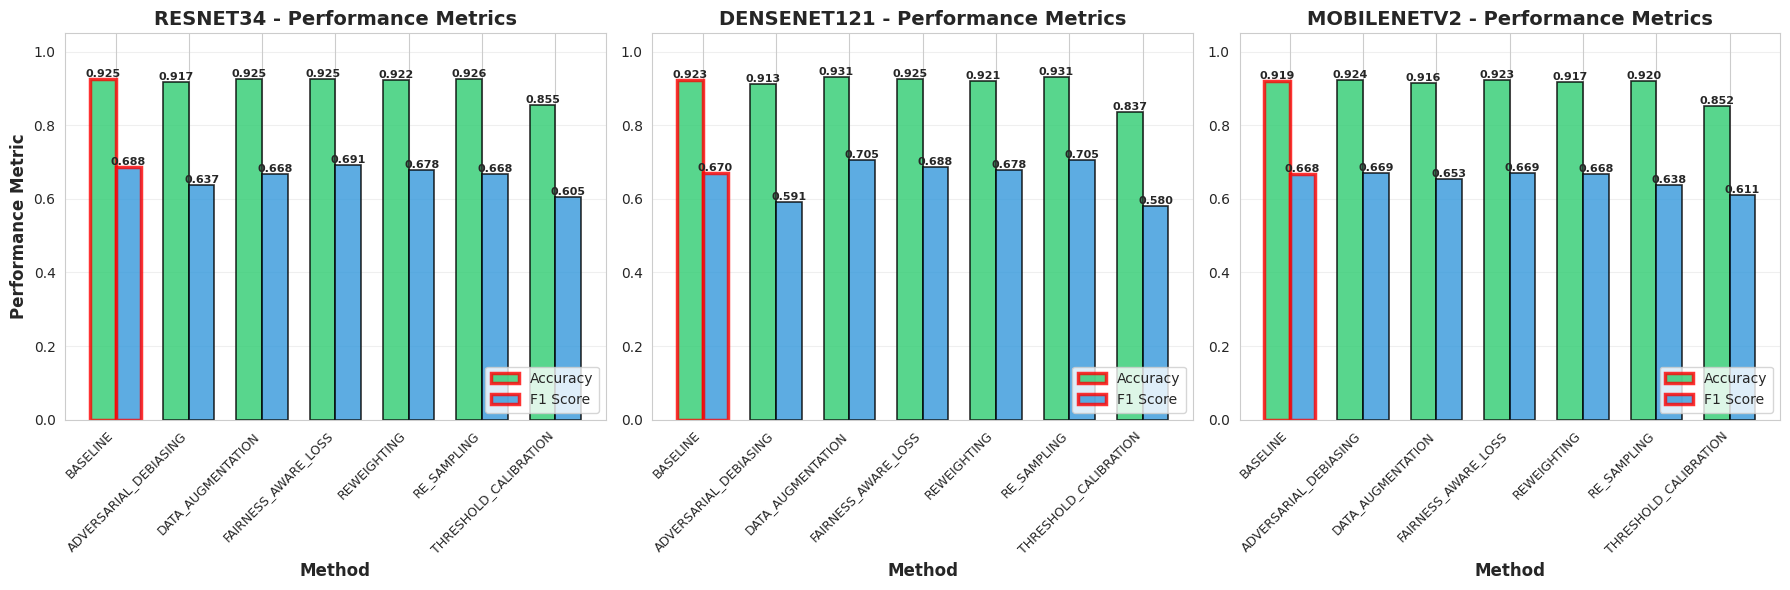

Saved: /content/drive/MyDrive/ELEC 509/Final Project/fitz_fairness_plots/fairness_metrics_by_model.png


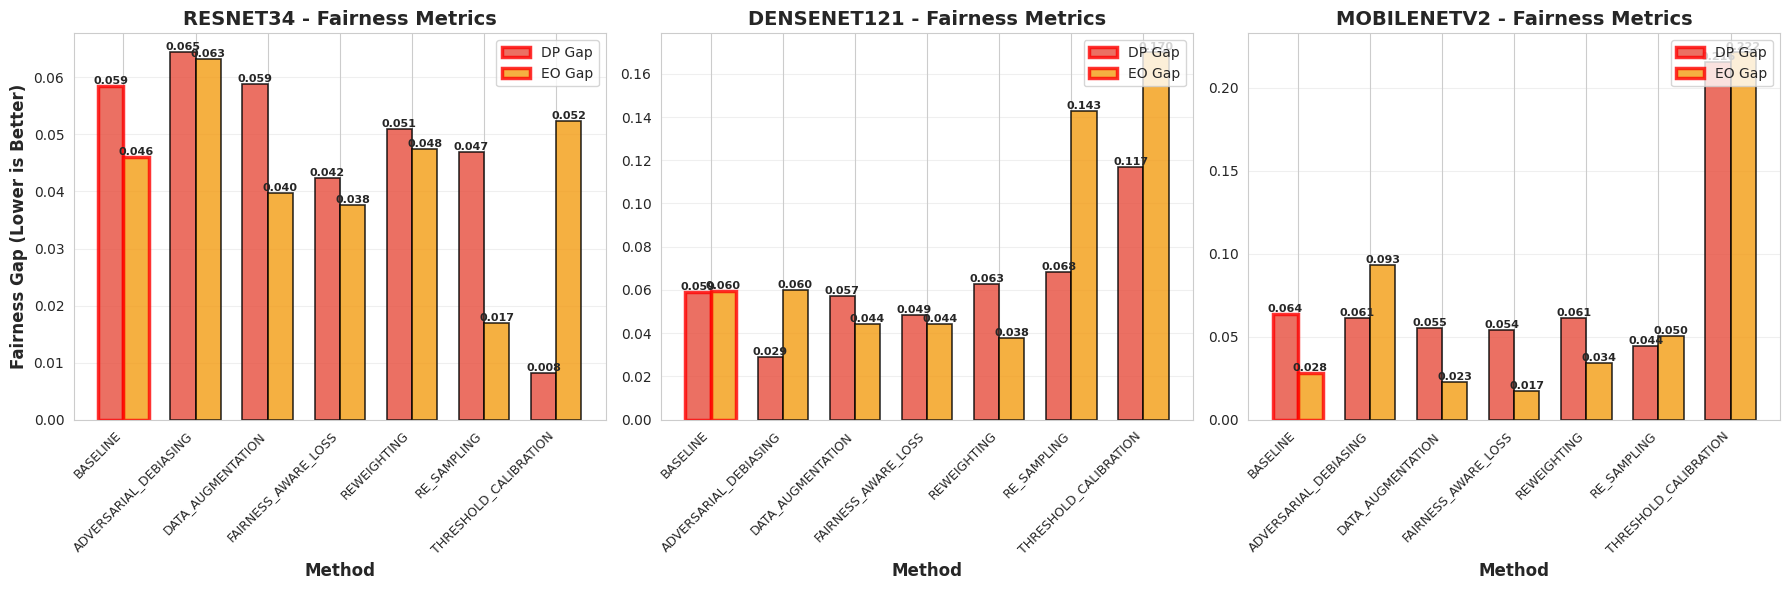

Saved: /content/drive/MyDrive/ELEC 509/Final Project/fitz_fairness_plots/statistical_significance_all.png


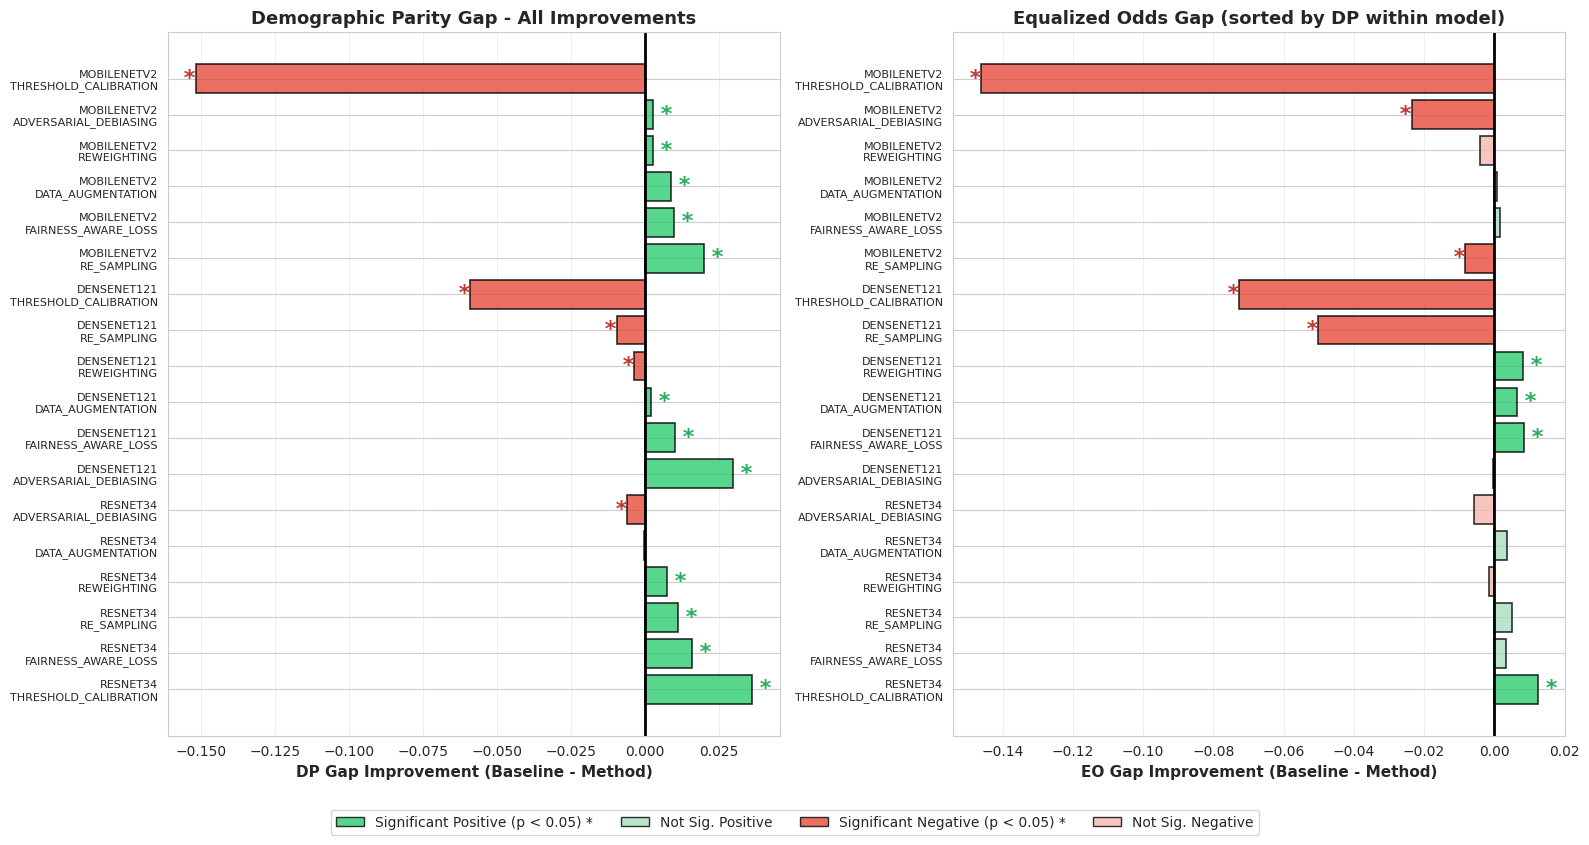

Saved: /content/drive/MyDrive/ELEC 509/Final Project/fitz_fairness_plots/statistical_significance_positive.png


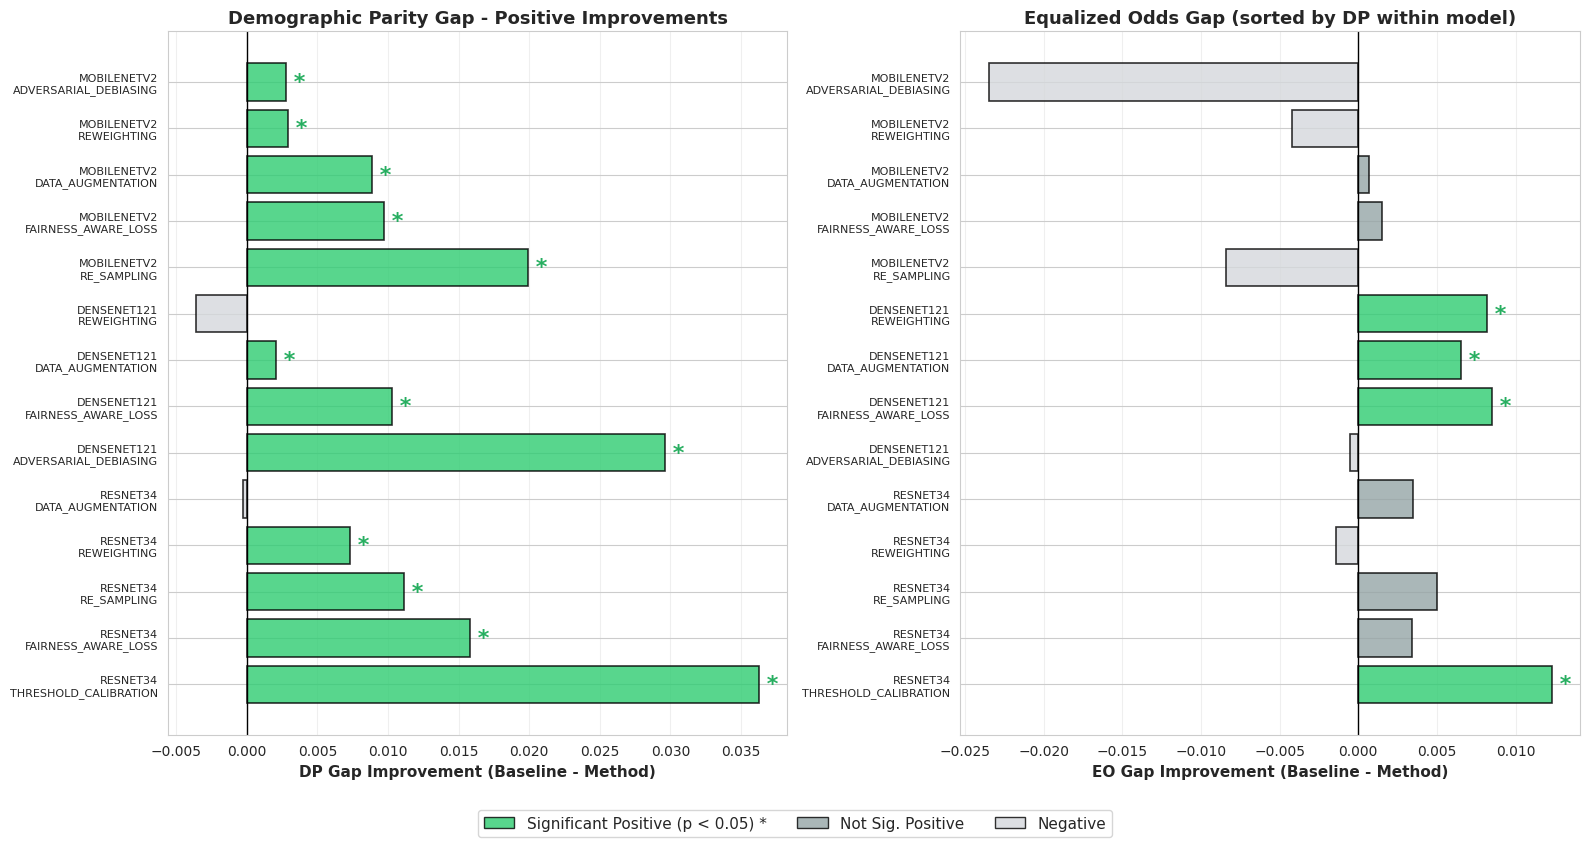

In [18]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


def create_output_folder(output_dir):
    """Create output directory if it doesn't exist"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    return output_dir


def load_results(results_file='fairness_comparison_results.csv'):
    """Load results from CSV"""
    df = pd.read_csv(results_file)
    return df


def create_accuracy_f1_by_model(df, filename, output_dir):
    """
    Create bar plot showing Accuracy and F1 Score together for each model
    """
    models = df['model'].unique()

    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 6), sharey=False)

    if len(models) == 1:
        axes = [axes]

    # Colors for metrics
    metric_colors = {
        'accuracy': '#2ecc71',  # Green
        'f1': '#3498db',         # Blue
    }

    for idx, model in enumerate(models):
        ax = axes[idx]
        model_data = df[df['model'] == model].copy()

        # Sort methods with BASELINE first
        method_order = []
        if 'BASELINE' in model_data['method'].values:
            method_order.append('BASELINE')
        other_methods = sorted([m for m in model_data['method'].unique() if m != 'BASELINE'])
        method_order.extend(other_methods)

        # Reorder dataframe
        model_data['method'] = pd.Categorical(model_data['method'], categories=method_order, ordered=True)
        model_data = model_data.sort_values('method')

        methods_list = model_data['method'].values
        x_pos = np.arange(len(methods_list))
        width = 0.35  # Width of each bar

        # Plot grouped bars for accuracy and F1
        accuracy_vals = model_data['accuracy'].values
        f1_vals = model_data['f1'].values

        bars1 = ax.bar(x_pos - width/2, accuracy_vals, width,
                      label='Accuracy', color=metric_colors['accuracy'],
                      alpha=0.8, edgecolor='black', linewidth=1.2)

        bars2 = ax.bar(x_pos + width/2, f1_vals, width,
                      label='F1 Score', color=metric_colors['f1'],
                      alpha=0.8, edgecolor='black', linewidth=1.2)

        # Highlight baseline with thicker border
        if methods_list[0] == 'BASELINE':
            bars1[0].set_edgecolor('red')
            bars1[0].set_linewidth(2.5)
            bars2[0].set_edgecolor('red')
            bars2[0].set_linewidth(2.5)

        # Add value labels on bars
        for bar, val in zip(bars1, accuracy_vals):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

        for bar, val in zip(bars2, f1_vals):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

        # Formatting
        ax.set_xlabel('Method', fontsize=12, fontweight='bold')
        ax.set_ylabel('Performance Metric' if idx == 0 else '', fontsize=12, fontweight='bold')
        ax.set_title(f'{model.upper()} - Performance Metrics', fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(methods_list, rotation=45, ha='right', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        ax.legend(loc='lower right', fontsize=10)

        # Set y-axis to show 0 to 1 range
        ax.set_ylim(0, 1.05)

    plt.tight_layout()
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.show()
    plt.close()


def create_fairness_by_model(df, filename, output_dir):
    """
    Create bar plot showing DP Gap and EO Gap together for each model
    """
    models = df['model'].unique()

    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 6), sharey=False)

    if len(models) == 1:
        axes = [axes]

    # Colors for fairness metrics
    metric_colors = {
        'dp_gap': '#e74c3c',     # Red
        'eo_gap': '#f39c12'      # Orange
    }

    for idx, model in enumerate(models):
        ax = axes[idx]
        model_data = df[df['model'] == model].copy()

        # Sort methods with BASELINE first
        method_order = []
        if 'BASELINE' in model_data['method'].values:
            method_order.append('BASELINE')
        other_methods = sorted([m for m in model_data['method'].unique() if m != 'BASELINE'])
        method_order.extend(other_methods)

        # Reorder dataframe
        model_data['method'] = pd.Categorical(model_data['method'], categories=method_order, ordered=True)
        model_data = model_data.sort_values('method')

        methods_list = model_data['method'].values
        x_pos = np.arange(len(methods_list))
        width = 0.35  # Width of each bar

        # Plot grouped bars for DP and EO gaps
        dp_vals = model_data['dp_gap'].values
        eo_vals = model_data['eo_gap'].values

        bars1 = ax.bar(x_pos - width/2, dp_vals, width,
                      label='DP Gap', color=metric_colors['dp_gap'],
                      alpha=0.8, edgecolor='black', linewidth=1.2)

        bars2 = ax.bar(x_pos + width/2, eo_vals, width,
                      label='EO Gap', color=metric_colors['eo_gap'],
                      alpha=0.8, edgecolor='black', linewidth=1.2)

        # Highlight baseline with thicker border
        if methods_list[0] == 'BASELINE':
            bars1[0].set_edgecolor('red')
            bars1[0].set_linewidth(2.5)
            bars2[0].set_edgecolor('red')
            bars2[0].set_linewidth(2.5)

        # Add value labels on bars
        for bar, val in zip(bars1, dp_vals):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

        for bar, val in zip(bars2, eo_vals):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

        # Formatting
        ax.set_xlabel('Method', fontsize=12, fontweight='bold')
        ax.set_ylabel('Fairness Gap (Lower is Better)' if idx == 0 else '', fontsize=12, fontweight='bold')
        ax.set_title(f'{model.upper()} - Fairness Metrics', fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(methods_list, rotation=45, ha='right', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        ax.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.show()
    plt.close()


def create_statistical_significance_plot_all(stat_df, filename, output_dir):
    """
    Create visualization showing ALL statistical improvements (positive and negative)
    """
    models = stat_df['model'].unique()

    fig, axes = plt.subplots(1, 2, figsize=(16, max(8, len(models) * len(stat_df['method'].unique()) * 0.3)))

    # Create unified order: for each model, sort methods by DP improvement
    all_labels = []
    all_rows = []

    for model in models:
        model_data = stat_df[stat_df['model'] == model].sort_values('dp_improvement', ascending=False)
        for _, row in model_data.iterrows():
            all_labels.append(f"{model.upper()}\n{row['method']}")
            all_rows.append(row)

    # DP Gap improvements - sorted by DP within each model
    ax1 = axes[0]
    improvement_data_dp = []
    colors_list_dp = []

    for row in all_rows:
        improvement_data_dp.append(row['dp_improvement'])

        # Color based on sign and significance
        if row['dp_improvement'] > 0:
            colors_list_dp.append('#2ecc71' if row['dp_significant'] else '#a9dfbf')  # Dark/light green
        else:
            colors_list_dp.append('#e74c3c' if row['dp_significant'] else '#f5b7b1')  # Dark/light red

    y_pos = np.arange(len(improvement_data_dp))
    bars = ax1.barh(y_pos, improvement_data_dp, color=colors_list_dp, alpha=0.8, edgecolor='black', linewidth=1.2)

    # Add significance markers
    for i, (bar, row) in enumerate(zip(bars, all_rows)):
        if row['dp_significant']:
            ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                    ' *', ha='left' if row['dp_improvement'] > 0 else 'right',
                    va='center', fontsize=16, fontweight='bold',
                    color='#27ae60' if row['dp_improvement'] > 0 else '#c0392b')

    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(all_labels, fontsize=8)
    ax1.set_xlabel('DP Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
    ax1.set_title('Demographic Parity Gap - All Improvements', fontsize=13, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax1.grid(axis='x', alpha=0.3)

    ax2 = axes[1]
    improvement_data_eo = []
    colors_list_eo = []

    for row in all_rows:
        improvement_data_eo.append(row['eo_improvement'])

        # Color based on sign and significance
        if row['eo_improvement'] > 0:
            colors_list_eo.append('#2ecc71' if row['eo_significant'] else '#a9dfbf')  # Dark/light green
        else:
            colors_list_eo.append('#e74c3c' if row['eo_significant'] else '#f5b7b1')  # Dark/light red

    y_pos = np.arange(len(improvement_data_eo))
    bars = ax2.barh(y_pos, improvement_data_eo, color=colors_list_eo, alpha=0.8, edgecolor='black', linewidth=1.2)

    # Add significance markers
    for i, (bar, row) in enumerate(zip(bars, all_rows)):
        if row['eo_significant']:
            ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                    ' *', ha='left' if row['eo_improvement'] > 0 else 'right',
                    va='center', fontsize=16, fontweight='bold',
                    color='#27ae60' if row['eo_improvement'] > 0 else '#c0392b')

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(all_labels, fontsize=8)
    ax2.set_xlabel('EO Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
    ax2.set_title('Equalized Odds Gap (sorted by DP within model)', fontsize=13, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax2.grid(axis='x', alpha=0.3)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', alpha=0.8, edgecolor='black', label='Significant Positive (p < 0.05) *'),
        Patch(facecolor='#a9dfbf', alpha=0.8, edgecolor='black', label='Not Sig. Positive'),
        Patch(facecolor='#e74c3c', alpha=0.8, edgecolor='black', label='Significant Negative (p < 0.05) *'),
        Patch(facecolor='#f5b7b1', alpha=0.8, edgecolor='black', label='Not Sig. Negative')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.01),
              ncol=4, fontsize=10)

    plt.tight_layout()
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.show()
    plt.close()


def create_statistical_significance_plot_positive(stat_df, filename, output_dir):
    """
    Create visualization showing only positive statistical improvements
    """
    models = stat_df['model'].unique()

    fig, axes = plt.subplots(1, 2, figsize=(16, max(8, len(models) * len(stat_df['method'].unique()) * 0.3)))

    all_labels = []
    all_rows = []

    for model in models:
        model_data = stat_df[stat_df['model'] == model].sort_values('dp_improvement', ascending=False)
        # Filter to keep only rows with at least one positive improvement
        model_data_filtered = model_data[(model_data['dp_improvement'] > 0) | (model_data['eo_improvement'] > 0)]
        for _, row in model_data_filtered.iterrows():
            all_labels.append(f"{model.upper()}\n{row['method']}")
            all_rows.append(row)

    ax1 = axes[0]
    improvement_data_dp = []
    colors_list_dp = []

    for row in all_rows:
        improvement_data_dp.append(row['dp_improvement'])

        # Color: green if significant positive, gray if not significant positive, light gray if negative
        if row['dp_improvement'] > 0:
            colors_list_dp.append('#2ecc71' if row['dp_significant'] else '#95a5a6')
        else:
            colors_list_dp.append('#d5d8dc')  # Very light gray for negative (alignment only)

    if len(improvement_data_dp) > 0:
        y_pos = np.arange(len(improvement_data_dp))
        bars = ax1.barh(y_pos, improvement_data_dp, color=colors_list_dp, alpha=0.8, edgecolor='black', linewidth=1.2)

        # Add significance markers for significant positive improvements
        for i, (bar, row) in enumerate(zip(bars, all_rows)):
            if row['dp_significant'] and row['dp_improvement'] > 0:
                ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                        ' *', ha='left', va='center', fontsize=16, fontweight='bold', color='#27ae60')

        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(all_labels, fontsize=8)
        ax1.set_xlabel('DP Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
        ax1.set_title('Demographic Parity Gap - Positive Improvements', fontsize=13, fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax1.grid(axis='x', alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No positive improvements',
                ha='center', va='center', fontsize=14, transform=ax1.transAxes)
        ax1.set_xlabel('DP Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
        ax1.set_title('Demographic Parity Gap - Positive Improvements', fontsize=13, fontweight='bold')

    # EO Gap improvements
    ax2 = axes[1]
    improvement_data_eo = []
    colors_list_eo = []

    for row in all_rows:
        improvement_data_eo.append(row['eo_improvement'])

        # Color: green if significant positive, gray if not significant positive, light gray if negative
        if row['eo_improvement'] > 0:
            colors_list_eo.append('#2ecc71' if row['eo_significant'] else '#95a5a6')
        else:
            colors_list_eo.append('#d5d8dc')  # Very light gray for negative (alignment only)

    if len(improvement_data_eo) > 0:
        y_pos = np.arange(len(improvement_data_eo))
        bars = ax2.barh(y_pos, improvement_data_eo, color=colors_list_eo, alpha=0.8, edgecolor='black', linewidth=1.2)

        # Add significance markers for significant positive improvements
        for i, (bar, row) in enumerate(zip(bars, all_rows)):
            if row['eo_significant'] and row['eo_improvement'] > 0:
                ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                        ' *', ha='left', va='center', fontsize=16, fontweight='bold', color='#27ae60')

        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(all_labels, fontsize=8)
        ax2.set_xlabel('EO Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
        ax2.set_title('Equalized Odds Gap (sorted by DP within model)', fontsize=13, fontweight='bold')
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax2.grid(axis='x', alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No positive improvements',
                ha='center', va='center', fontsize=14, transform=ax2.transAxes)
        ax2.set_xlabel('EO Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
        ax2.set_title('Equalized Odds Gap (sorted by DP within model)', fontsize=13, fontweight='bold')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', alpha=0.8, edgecolor='black', label='Significant Positive (p < 0.05) *'),
        Patch(facecolor='#95a5a6', alpha=0.8, edgecolor='black', label='Not Sig. Positive'),
        Patch(facecolor='#d5d8dc', alpha=0.8, edgecolor='black', label='Negative')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.01),
              ncol=3, fontsize=11)

    plt.tight_layout()
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.show()
    plt.close()



def main():
    OUTPUT_DIR = '/content/drive/MyDrive/ELEC 509/Final Project/fitz_fairness_plots'
    RESULTS_FILE = '/content/drive/MyDrive/ELEC 509/Final Project/fitz_fairness_comparison_results.csv'
    STATS_FILE = '/content/drive/MyDrive/ELEC 509/Final Project/fitz_statistical_comparison_results.csv'

    # Create output directory
    output_dir = create_output_folder(OUTPUT_DIR)

    # Load data
    results_df = load_results(RESULTS_FILE)

    try:
        stat_df = pd.read_csv(STATS_FILE)
        has_stats = True
    except:
        has_stats = False

    print(f"Loaded data for {len(results_df['model'].unique())} models")
    print(f"Models: {', '.join([m.upper() for m in results_df['model'].unique()])}")
    print(f"Methods: {len(results_df['method'].unique())}")

    # 1. Performance metrics (Accuracy + F1) per model
    create_accuracy_f1_by_model(results_df, 'performance_metrics_by_model.png', output_dir)

    # 2. Fairness metrics (DP Gap + EO Gap) per model
    create_fairness_by_model(results_df, 'fairness_metrics_by_model.png', output_dir)

    # 3. Statistical significance plot: All improvements
    if has_stats:
        create_statistical_significance_plot_all(stat_df, 'statistical_significance_all.png', output_dir)

    # 4. Statistical significance plot: Positive only
    if has_stats:
        create_statistical_significance_plot_positive(stat_df, 'statistical_significance_positive.png', output_dir)


if __name__ == "__main__":
    main()